# Projet Data Mining : Bank Churn Prediction - Kaggle Competition


## Importing Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from scipy.stats import anderson
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import optuna
import joblib
from tqdm import tqdm

## Importing the data

In [2]:
data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
data

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15660608.0,Ch'in,681.0,Spain,Male,31.0,1.0,0.00,2.0,1.0,1.0,125445.80,0.0
14996,14996,15767432.0,Fan,549.0,Germany,Male,34.0,7.0,134464.58,1.0,1.0,0.0,126535.92,0.0
14997,14997,15766896.0,Trevisano,550.0,France,Female,46.0,5.0,0.00,2.0,1.0,1.0,133897.32,0.0
14998,14998,15705412.0,Udegbulam,647.0,France,Female,25.0,4.0,141616.55,2.0,1.0,0.0,187597.98,0.0


In [4]:
test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15797736.0,Chikwendu,591.0,Germany,Female,32.0,2.0,106881.50,2.0,1.0,0.0,122810.53
1,15001,15676515.0,Lai,553.0,Spain,Male,37.0,2.0,0.00,2.0,1.0,0.0,63736.17
2,15002,15701291.0,Folliero,646.0,France,Female,29.0,7.0,0.00,2.0,1.0,0.0,121866.87
3,15003,15594812.0,Trevisani,603.0,Germany,Male,49.0,8.0,131394.56,1.0,0.0,1.0,147059.28
4,15004,15791321.0,Ch'ien,645.0,Spain,Female,39.0,3.0,0.00,2.0,1.0,0.0,129975.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642063.0,Tung,694.0,Spain,Male,41.0,6.0,0.00,2.0,0.0,0.0,171378.77
9996,24996,15731267.0,Hsiao,614.0,France,Female,55.0,8.0,157597.61,1.0,1.0,0.0,70974.13
9997,24997,15673367.0,Manna,589.0,France,Male,41.0,4.0,0.00,2.0,1.0,1.0,123475.88
9998,24998,15626141.0,Chukwumaobim,543.0,Germany,Male,33.0,2.0,151659.52,1.0,1.0,1.0,86911.49


## EDA

### Analyse des valeurs manquantes et types de donnees

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


Il n'y a pas de valeurs manquantes dans le dataset

### Analyse des valeurs aberrantes

In [6]:
data.describe(include = 'all')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,1.500000e+04,15000,15000.000000,15000,15000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
unique,NaN,NaN,755,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ch'iu,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,311,NaN,9048,8422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7499.500000,1.570073e+07,NaN,658.701800,NaN,NaN,37.660800,5.038800,42888.826095,1.589467,0.779800,0.497867,117892.175400,0.199333
std,4330.271354,1.162730e+06,NaN,80.238346,NaN,NaN,8.106408,2.810354,59695.877791,0.532430,0.414395,0.500012,45574.462515,0.399512
min,0.000000,1.557151e+05,NaN,431.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,3749.750000,1.563387e+07,NaN,602.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,82870.750000,0.000000
50%,7499.500000,1.569018e+07,NaN,661.000000,NaN,NaN,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123583.850000,0.000000
75%,11249.250000,1.575972e+07,NaN,709.000000,NaN,NaN,42.000000,7.000000,109844.810000,2.000000,1.000000,1.000000,157567.370000,0.000000


Remarques:
- Il y a 2 variables qualitatives (**Geography** et **Gender**), donc on n'aura pas de grand problemes de dimensionnalite avec le one hot encoding vu que ces variable ont que 2 et 3 valeurs uniques, donc on aura que 3 colonnes de plus
- Les variables **HasCrCard** et **IsActiveMemeber** sont aussi categorielles mais doivent etre transforme de float en categorielle
- Les scores de credit varient normalement entre 300 et 900, ici la valeur maximale est de 4818, ce qui montre qu'il ya des valeurs aberrantes
- Un **balance** de 207034.96 est un peu eleve, on fera un boxplot pour verifier si c'est normal ou pas
- **NumOfProducts** de 6 peut etre est aussi elever, a voir.
- Meme remarque pour **EstimatedSalary**

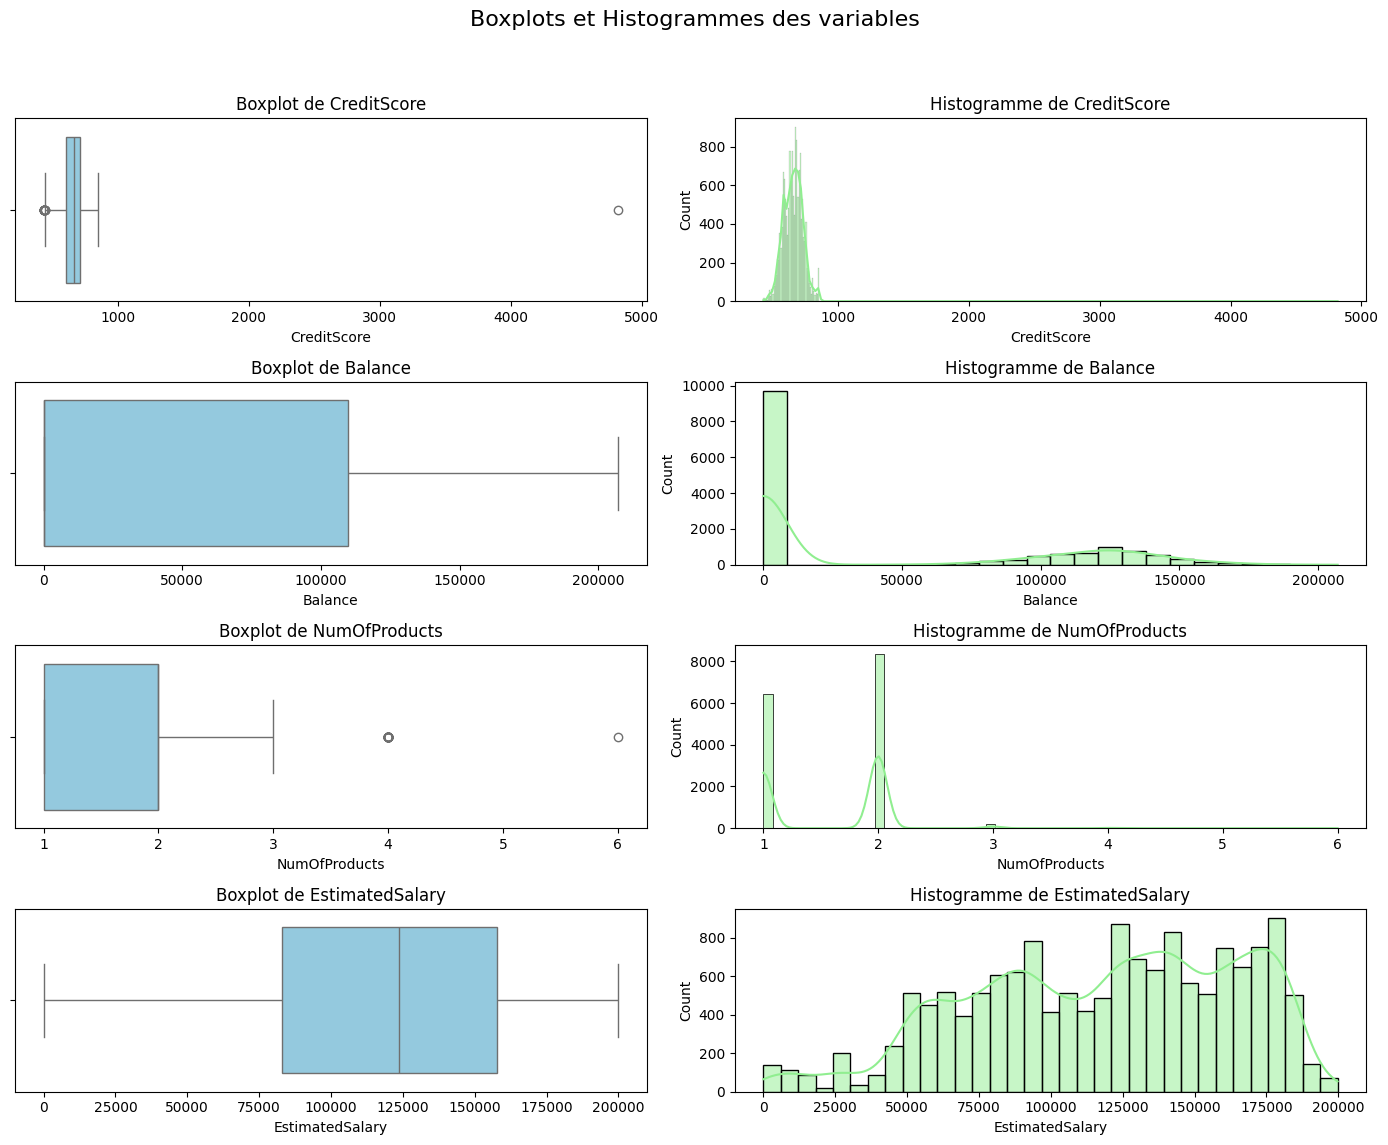

In [7]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
fig.suptitle("Boxplots et Histogrammes des variables", fontsize = 16)

# Variables qui nous interessent
variables = ["CreditScore", "Balance", "NumOfProducts", "EstimatedSalary"]

for i, var in enumerate(variables):
  # Boxplot
  sns.boxplot(x = data[var], ax = axes[i][0], color = "skyblue")
  axes[i][0].set_title(f"Boxplot de {var}")

  # Histogram
  sns.histplot(x = data[var], kde = True, ax = axes[i][1], color = "lightgreen")
  axes[i][1].set_title(f"Histogramme de {var}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Les valeurs ont l'air d'etre logiques, a part le **CreditScore** qui doit etre gere.

In [8]:
# data = data[data["CreditScore"] <= 900]
# data.info()

Dans ce qui suit, on fera la meme chose pour le dataset test:

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10000 non-null  int64  
 1   CustomerId       10000 non-null  float64
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  float64
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  float64
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  float64
 10  HasCrCard        10000 non-null  float64
 11  IsActiveMember   10000 non-null  float64
 12  EstimatedSalary  10000 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1015.8+ KB


In [10]:
test.describe(include = 'all')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.00000,1.000000e+04,10000,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
unique,NaN,NaN,712,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ch'iu,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,203,NaN,5970,5723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,19999.50000,1.569185e+07,NaN,658.34280,NaN,NaN,37.713000,5.080700,42988.997215,1.590800,0.785500,0.491100,1.197376e+05
std,2886.89568,7.141705e+04,NaN,73.15434,NaN,NaN,8.185764,2.793522,59821.063569,0.528378,0.410496,0.499946,2.003755e+05
min,15000.00000,1.556581e+07,NaN,431.00000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.781900e+02
25%,17499.75000,1.563365e+07,NaN,599.00000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,8.260242e+04
50%,19999.50000,1.568933e+07,NaN,661.00000,NaN,NaN,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,1.224355e+05
75%,22499.25000,1.575754e+07,NaN,709.00000,NaN,NaN,42.000000,8.000000,109766.095000,2.000000,1.000000,1.000000,1.575560e+05


On remarque qu'il n ya pas de valeurs manquantes ni de valeurs aberrantes

### Analyse des desequilibres de classes

Exited
0.0    12010
1.0     2990
Name: count, dtype: int64


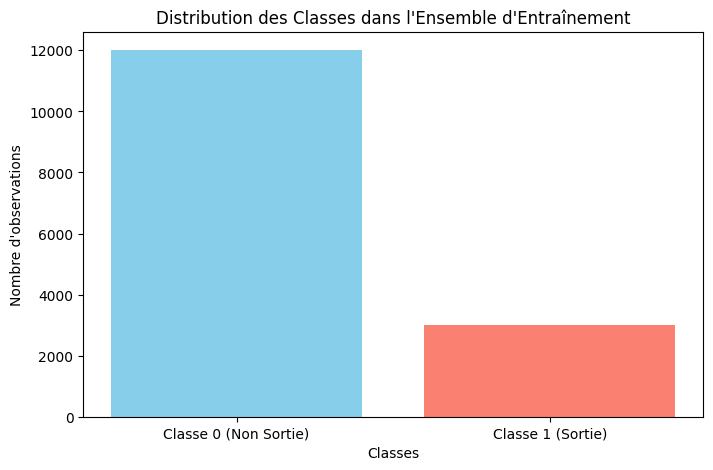

In [11]:
# Comptage des occurrences de chaque classe dans y_train
class_counts = data['Exited'].value_counts()

# Afficher les comptages
print(class_counts)

# Visualiser la distribution des classes
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Classes')
plt.ylabel('Nombre d\'observations')
plt.xticks([0, 1], ['Classe 0 (Non Sortie)', 'Classe 1 (Sortie)'])
plt.title('Distribution des Classes dans l\'Ensemble d\'Entraînement')
plt.show()

On remarque qu'il ya un grand desequilibre dans les observations, ce qui peut affecter les resultats car le modele va bien s'entrainer sur une classe plus que l'autre.

In [12]:
# Liste des featutres numériques dans data
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
# Liste des features catégorielles dans data
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

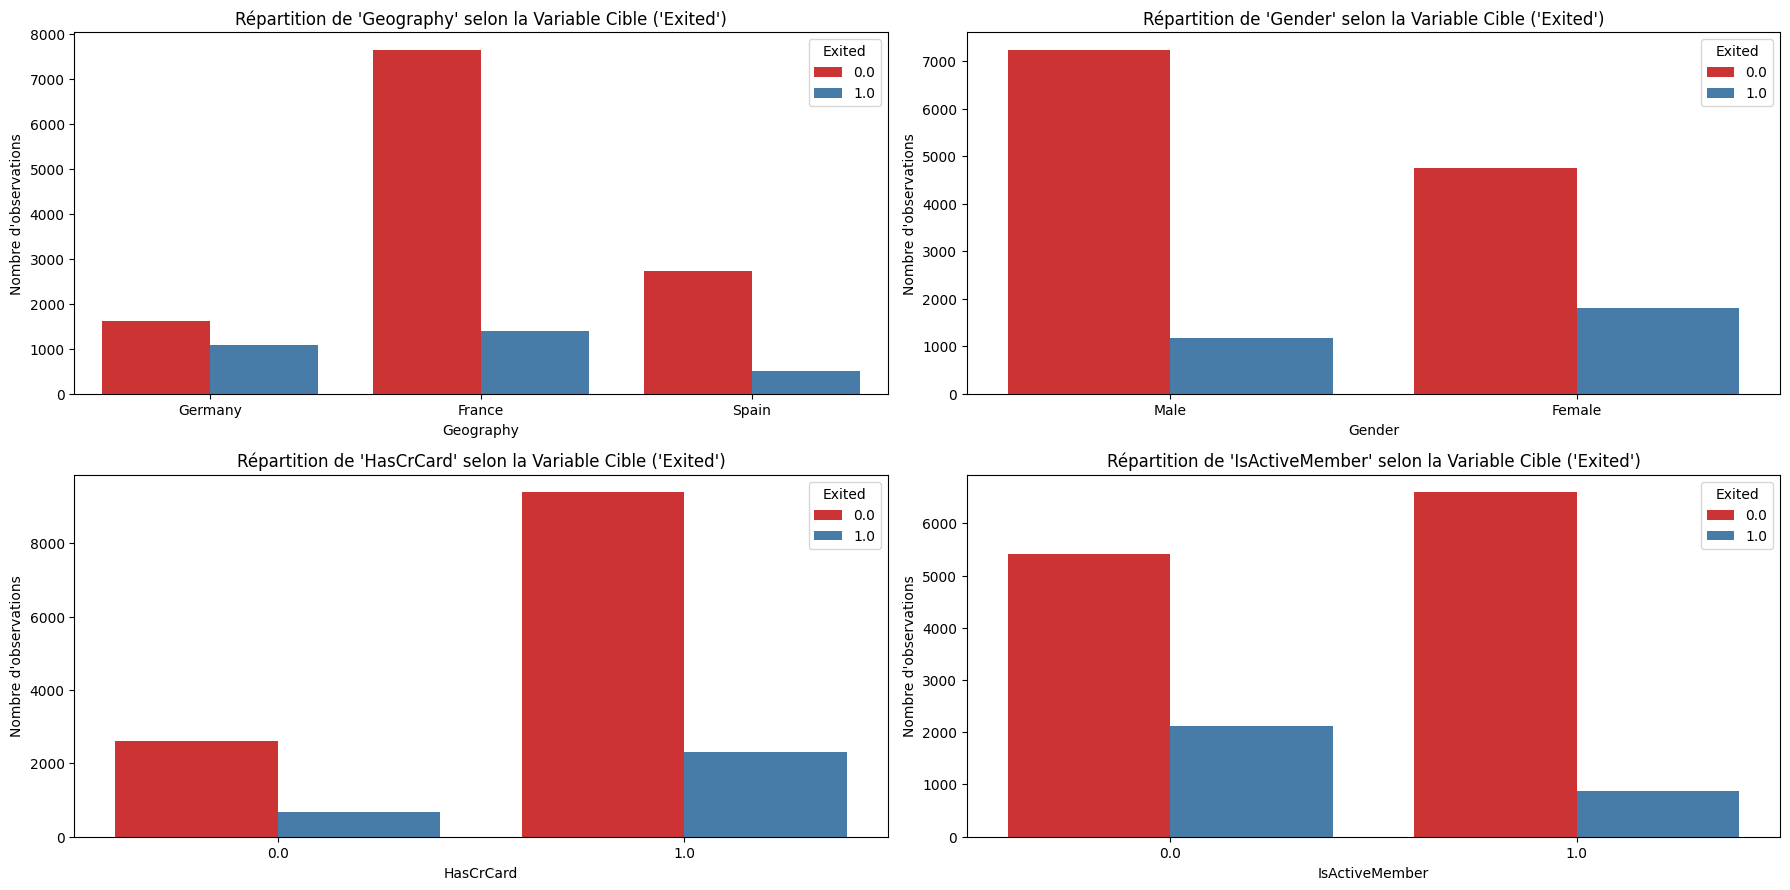

In [13]:
plt.figure(figsize=(18, 13))

# Visualiser chaque features catégorielle selon la variable cible
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=data[feature], hue=data['Exited'], palette='Set1', dodge=True)
    plt.title(f"Répartition de '{feature}' selon la Variable Cible ('Exited')")
    plt.xlabel(feature)
    plt.ylabel('Nombre d\'observations')

plt.tight_layout()
plt.show()

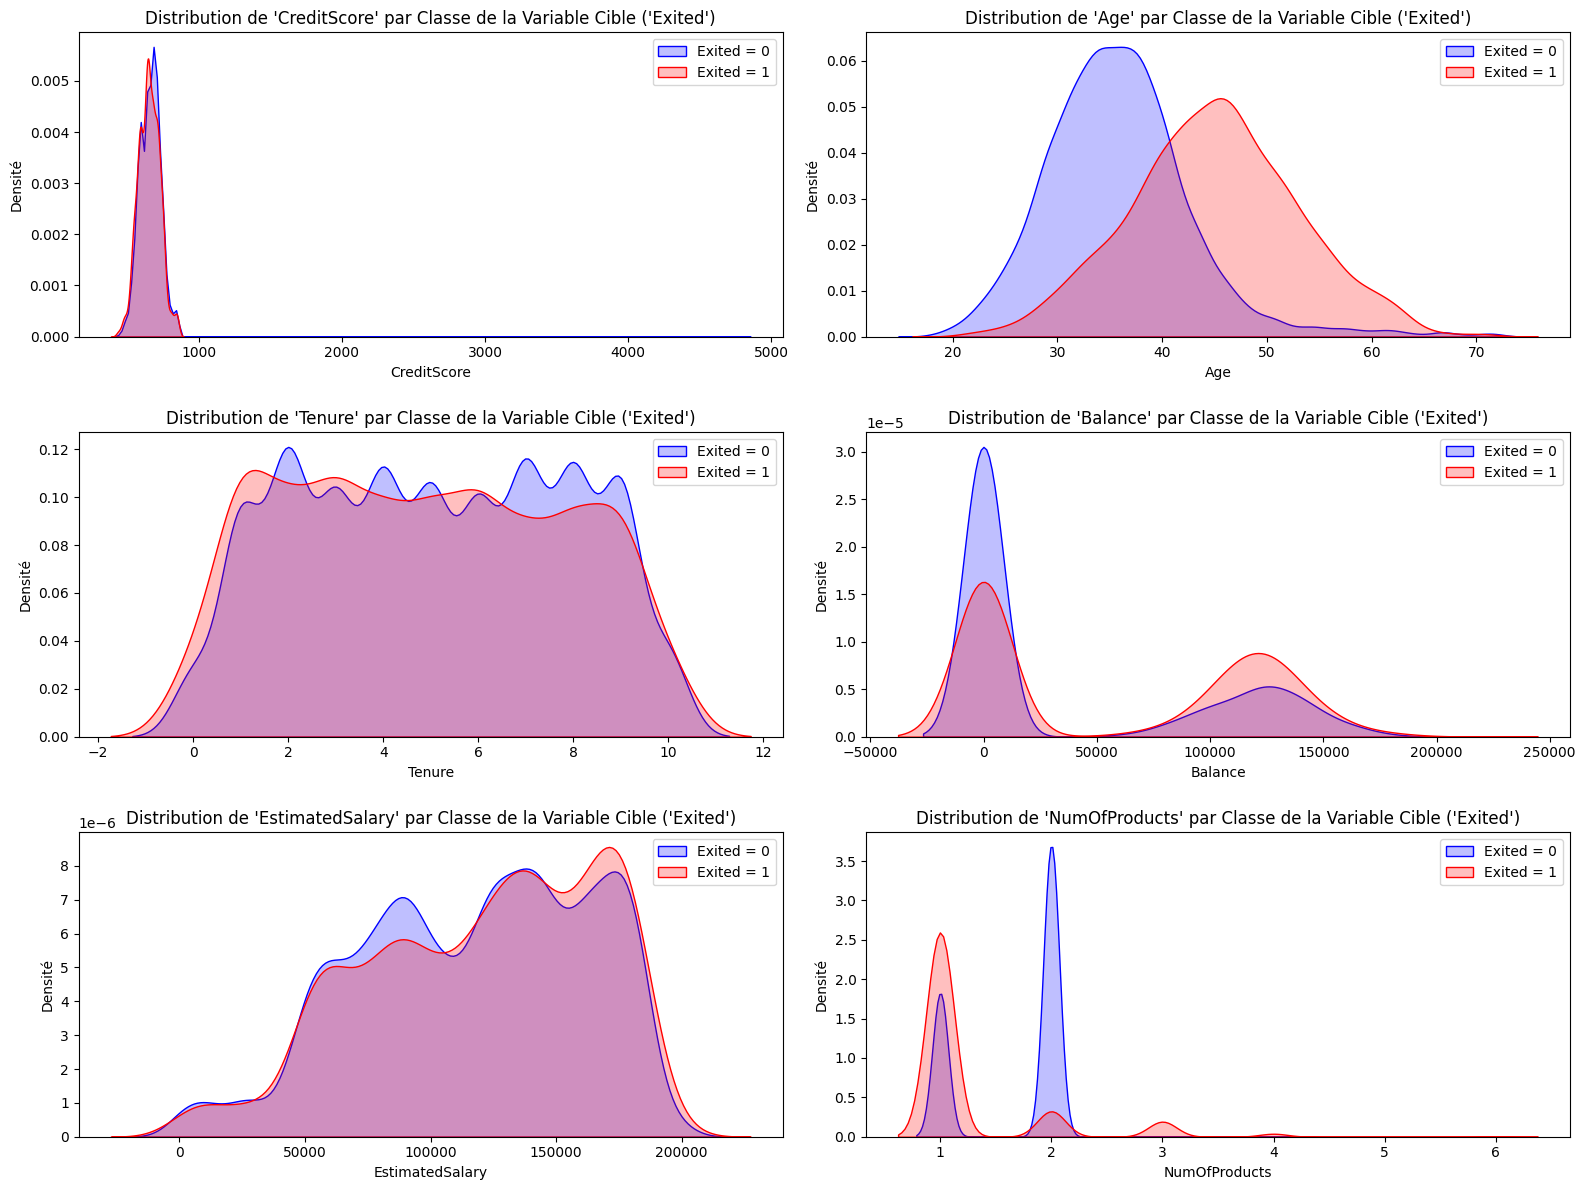

In [14]:
plt.figure(figsize=(16, 12))

# Visualiser la distribution de chaque caractéristique numérique selon la variable cible
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(data[feature][data['Exited'] == 0], label='Exited = 0', color='blue', fill=True)
    sns.kdeplot(data[feature][data['Exited'] == 1], label='Exited = 1', color='red', fill=True)
    plt.title(f"Distribution de '{feature}' par Classe de la Variable Cible ('Exited')")
    plt.xlabel(feature)
    plt.ylabel('Densité')
    plt.legend()

plt.tight_layout()
plt.show()

### Analyse des correlations

In [15]:
# Variables qualtitatives et quantitatives
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

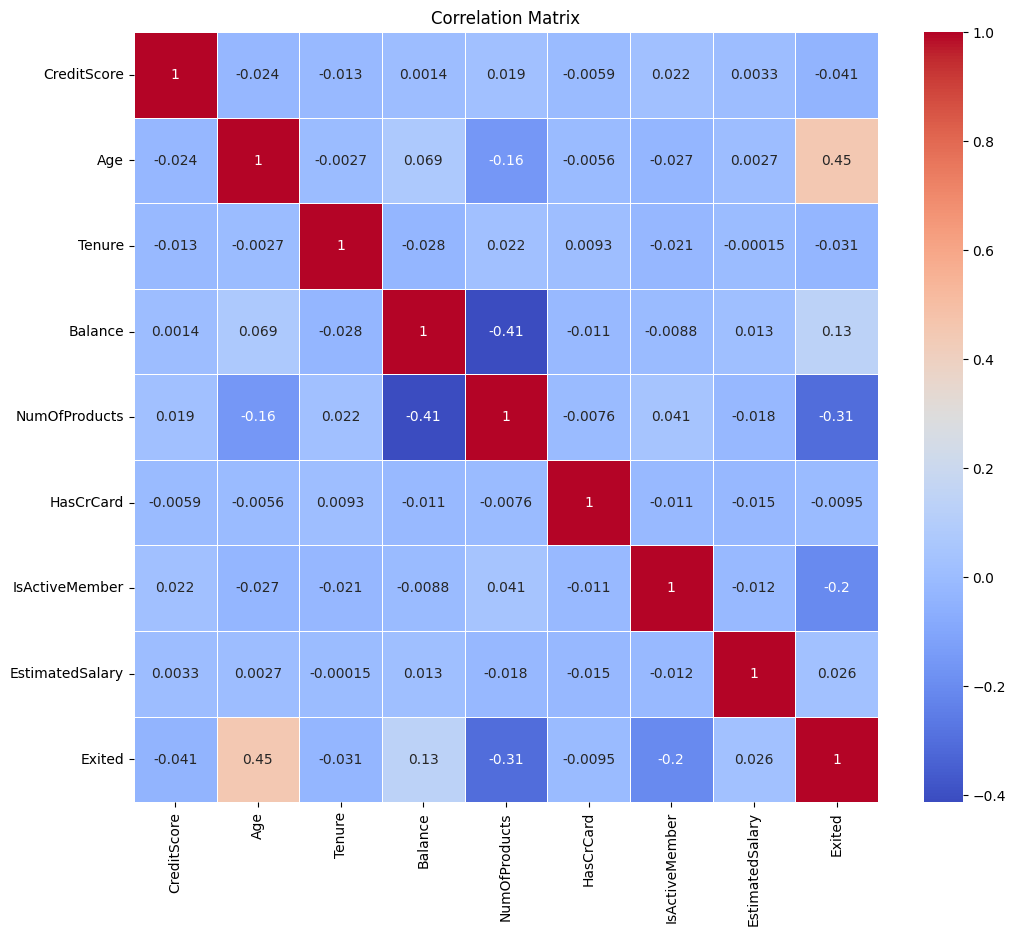

In [16]:
correlations = data[numerical_features + ['Exited']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

- On remarque qu'il y a peu de correlations entre les variables numeriques
- La corrélation entre **`Age`** et **`Exited`** est de **0.45**, ce qui est relativement élevée. Cela suggère que l'âge est une variable très importante pour prédire si un client quitte la banque.
- **`Balance`** a une corrélation de **0.13** avec **`Exited`**, ce qui indique que les clients avec un certain niveau de balance sont plus susceptibles de quitter.
- **`NumOfProducts`** a une **corrélation négative (-0.31)** avec **`Exited`**, ce qui pourrait indiquer que plus un client utilise de produits, moins il est susceptible de quitter. 
- **`IsActiveMember`** a une **corrélation négative (-0.2)** avec **`Exited`**. Cela montre que l'engagement est un facteur important pour la rétention des clients.
- Il y a une correlation negative entre **`NumOfProducts`** et **`Balance`** et **`NumOfProducts`** et **`Age`**.
- on verra pas la suite la correlation avec les variables categoriques aussi

In [17]:
# Cramer's V pour correlation entre variables categoriques
def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

categorical_correlations = {}

# Corrélations entre variables catégoriques
for i, cat1 in enumerate(categorical_features):
    for cat2 in categorical_features[i+1:]:
        contingency_table = pd.crosstab(data[cat1], data[cat2])
        categorical_correlations[(cat1, cat2)] = cramers_v(contingency_table)

# Corrélations entre chaque variable catégorielle et la variable cible (Exited)
for cat in categorical_features:
    contingency_table = pd.crosstab(data[cat], data['Exited'])
    categorical_correlations[(cat, 'Exited')] = cramers_v(contingency_table)

categorical_correlations

{('Geography', 'Gender'): 0.02186418822932761,
 ('Geography', 'Exited'): 0.23569787581852736,
 ('Gender', 'Exited'): 0.1687277872702606}

- Il y a très peu d'association entre la région géographique et le genre des clients
- La corrélation entre **`Geography`** et **`Exited`** est de **0.2357**. Cela indique une corrélation modérée entre la localisation géographique et la probabilité de quitter la banque. La région du client a donc un impact non négligeable sur la rétention.
- La corrélation entre **`Gender`** et **`Exited`** est de **0.1688**. Cela montre une corrélation faible à modérée entre le genre du client et sa décision de quitter la banque. 

Dans ce qui suit, nous allons encoder les variables categoriques et puis effectuer un test de correlation de Spearman pour vois si les variables numeriques et categoriques sont correlees entre elles.

## Feature Engineering

### Test de normalite des variables numeriques


Avant de scaler les variables numeriques, nous allons tester si elles suivent une loi normale ou pas pour voir s'il sera judicieux de les normaliser avec MinMaxScaler ou de les standardiser avec StandardScaler.

In [18]:
# Variables numériques continues et binaires
numerical_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']
binary_features = ['HasCrCard', 'IsActiveMember']

# Variables catégoriques
categorical_features = ['Geography', 'Gender']

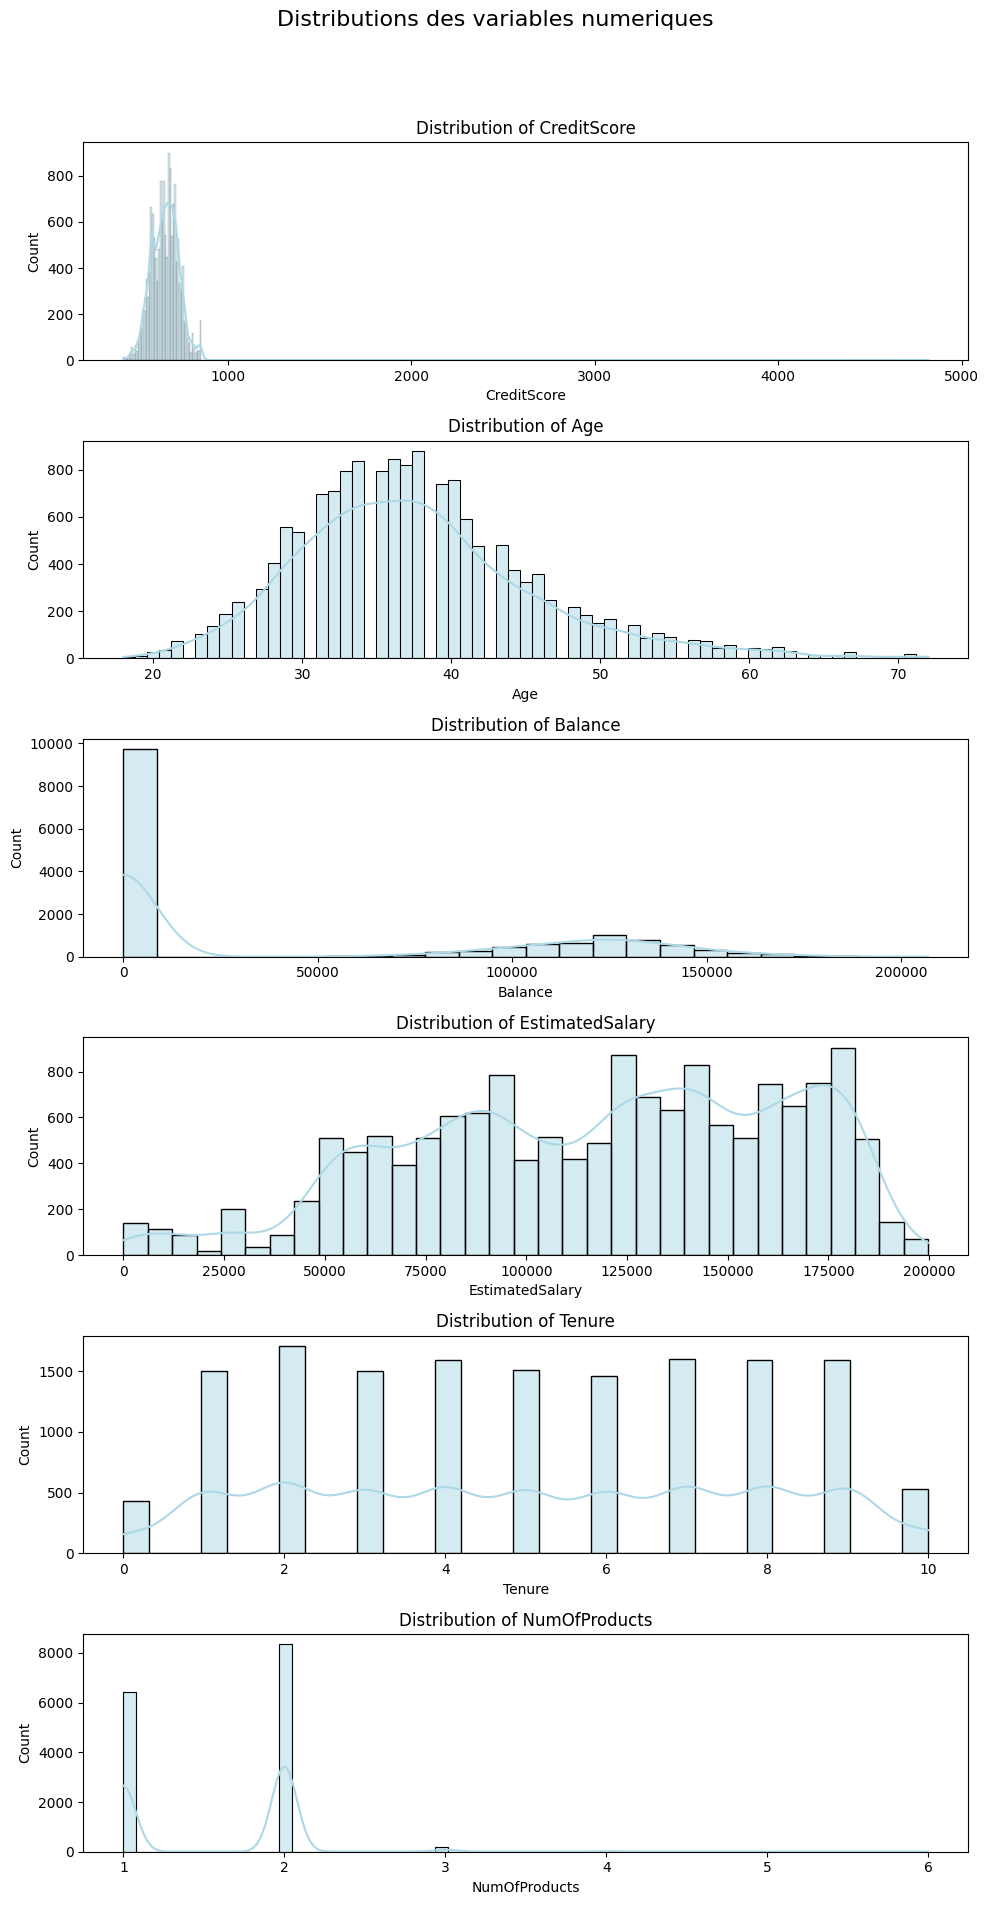

In [19]:
# Visualisation de la distribution des variables numeriques
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, 20))
fig.suptitle("Distributions des variables numeriques", fontsize=16)

# Plot histograms
for i, feature in enumerate(numerical_features):
    sns.histplot(data[feature], kde=True, ax=axes[i], color="lightblue")
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

On remarque que la plupart des variables ne suivent pas une distribution normale. On fera un test de normalite pour verifier ceci

In [20]:
# verifions la normalite des variables numeriques avec le test Anderson-Darling
anderson_results = {}
for feature in numerical_features:
    result = anderson(data[feature].dropna())
    anderson_results[feature] = result.statistic

anderson_results

{'CreditScore': 47.657945175007626,
 'Age': 128.9802740603409,
 'Balance': 2394.6688929559386,
 'EstimatedSalary': 135.85417571817925,
 'Tenure': 240.46111283013488,
 'NumOfProducts': 2349.7524345467464}

On a obtenu des valeurs tres grandes ce qui signifie que les variables s'eloignent beaucoup de la distribution normale. Pour normaliser les donnees, on va alors utiliser le MinmaxScaler au lieu de StandardScaler.

### Encodage des variables et normalisation

In [21]:
# ColumnTransformer avec OneHotEncoder et MinMaxScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', MinMaxScaler(), numerical_features)
    ]
)

encoded_normalized_data_full = preprocessor.fit_transform(data)
encoded_normalized_test = preprocessor.transform(test)

encoded_features = preprocessor.get_feature_names_out()
data_transformed_full = pd.DataFrame(encoded_normalized_data_full, columns=encoded_features)
test_transformed = pd.DataFrame(encoded_normalized_test, columns=encoded_features)

# Ajouter les variables binaires au DataFrame final
binary_data_full = data[binary_features].reset_index(drop=True)
binary_data_test = test[binary_features].reset_index(drop=True)

# Concaténer les variables binaires avec les données encodées et normalisées
data_transformed_full = pd.concat([data_transformed_full, binary_data_full], axis=1)
test_transformed = pd.concat([test_transformed, binary_data_test], axis=1)

data_transformed_full

,cat__Geography_Germany,cat__Geography_Spain,cat__Gender_Male,num__CreditScore,num__Age,num__Balance,num__EstimatedSalary,num__Tenure,num__NumOfProducts,HasCrCard,IsActiveMember
0,1.0,0.0,1.0,0.057442,0.574074,0.598150,0.694315,0.7,0.2,1.0,1.0
1,0.0,0.0,0.0,0.040346,0.222222,0.000000,0.734480,1.0,0.2,1.0,1.0
2,0.0,0.0,0.0,0.024618,0.259259,0.000000,0.474904,0.8,0.0,1.0,1.0
3,0.0,1.0,0.0,0.022567,0.388889,0.000000,0.890541,0.8,0.2,0.0,0.0
4,0.0,0.0,0.0,0.041486,0.500000,0.000000,0.584414,1.0,0.2,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,1.0,1.0,0.056987,0.240741,0.000000,0.627957,0.1,0.2,1.0,1.0
14996,1.0,0.0,1.0,0.026898,0.296296,0.649478,0.633414,0.7,0.0,1.0,0.0
14997,0.0,0.0,0.0,0.027126,0.518519,0.000000,0.670268,0.5,0.2,1.0,1.0
14998,0.0,0.0,0.0,0.049236,0.129630,0.684022,0.939107,0.4,0.2,1.0,0.0


In [22]:
def convert_encoded_columns_to_int(df):
    for col in df.columns:
        if 'cat__' in col:
            df[col] = df[col].astype(int)
    return df

In [23]:
data_transformed_full = convert_encoded_columns_to_int(data_transformed_full)
test_transformed = convert_encoded_columns_to_int(test_transformed)

data_transformed_full, test_transformed

(       cat__Geography_Germany  cat__Geography_Spain  cat__Gender_Male  \
 0                           1                     0                 1   
 1                           0                     0                 0   
 2                           0                     0                 0   
 3                           0                     1                 0   
 4                           0                     0                 0   
 ...                       ...                   ...               ...   
 14995                       0                     1                 1   
 14996                       1                     0                 1   
 14997                       0                     0                 0   
 14998                       0                     0                 0   
 14999                       0                     1                 1   
 
        num__CreditScore  num__Age  num__Balance  num__EstimatedSalary  \
 0              0.057442  0.574074  

Maintenant qu'on a encoder les variable categoriques, on peut verifier les correlations entre les variables num et cat avec le test de Spearman :

In [24]:
# Recalculer les corrélations entre les variables catégorielles encodées et les variables numériques non normalisées
combined_df = pd.concat([data_transformed_full, data[numerical_features]], axis=1)
combined_df = combined_df.dropna().reset_index(drop=True)

# Définir les caractéristiques catégorielles encodées et les variables numériques originales
encoded_categorical_features = [feature for feature in encoded_features if 'cat__' in feature]
original_numerical_features = numerical_features

num_cat_correlations_transformed = {}

# Calculer les corrélations de Spearman entre les variables numériques et les variables catégorielles encodées
for num in original_numerical_features:
    for cat in encoded_categorical_features:
        # Extraire les données des colonnes catégorielles et numériques pour le calcul
        categorical_data = combined_df[cat]
        numerical_data = combined_df[num]

        corr, _ = spearmanr(numerical_data, categorical_data)
        num_cat_correlations_transformed[(num, cat)] = corr

num_cat_correlation = pd.DataFrame.from_dict(num_cat_correlations_transformed, orient='index', columns=['Spearman Correlation'])
num_cat_correlation

,Spearman Correlation
"(CreditScore, cat__Geography_Germany)",-0.004325
"(CreditScore, cat__Geography_Spain)",0.002703
"(CreditScore, cat__Gender_Male)",0.000028
"(Age, cat__Geography_Germany)",0.111475
"(Age, cat__Geography_Spain)",-0.016160
"(Age, cat__Gender_Male)",-0.069814
"(Balance, cat__Geography_Germany)",0.611684
"(Balance, cat__Geography_Spain)",-0.156793
"(Balance, cat__Gender_Male)",-0.003169
"(EstimatedSalary, cat__Geography_Germany)",0.018010


- La corrélation entre **Balance** et **cat_Geography_Germany** est relativement élevée (0.611684), indiquant une association modérée entre ces deux variables.
- D'autres corrélations, telles que celles entre **NumOfProducts** et **cat_Geography_Germany** (-0.157979), montrent également un certain niveau d'association.
- La plupart des autres corrélations sont faibles, proches de zéro, ce qui suggère qu'il y a peu ou pas de relation linéaire entre les variables concernées.

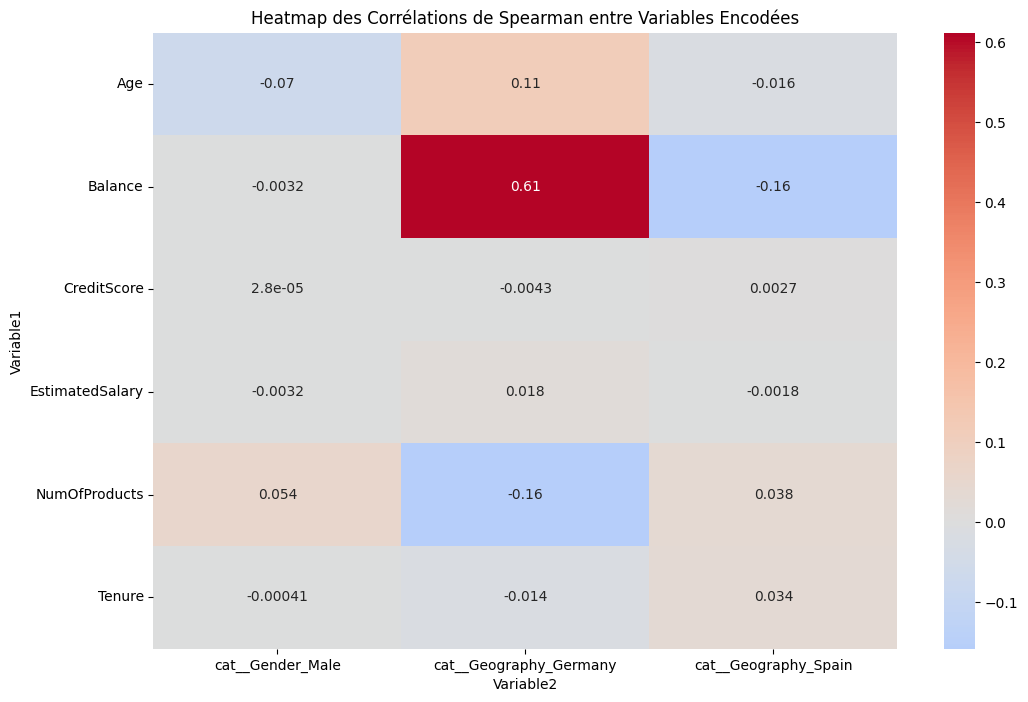

In [25]:
# Heatmap des correlations
num_cat_correlation.reset_index(inplace=True)
num_cat_correlation[['Variable1', 'Variable2']] = pd.DataFrame(num_cat_correlation['index'].tolist(), index=num_cat_correlation.index)
num_cat_correlation.drop(columns=['index'], inplace=True)

# Réorganiser les corrélations sous forme de matrice
correlation_matrix = num_cat_correlation.pivot(index='Variable1', columns='Variable2', values='Spearman Correlation')

# Créer une heatmap pour visualiser les corrélations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap des Corrélations de Spearman entre Variables Encodées")
plt.show()


### Separation Train-Validation

Dans les etapes precedentes, nous avons encode et normalise tout les dataset data et test, mais vu que nous avons separe data en test et validation, nous allons cette fois transformer que X_train et fitter X_val pour eviter le data leakage

In [26]:
# Define features and target variable
X = data.drop(columns=['id', 'CustomerId', 'Surname', 'Exited'])
y = data['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# ColumnTransformer avec OneHotEncoder et MinMaxScaler
encoded_normalized_train_only = preprocessor.fit_transform(X_train)
encoded_normalized_val_only = preprocessor.transform(X_val)

X_train_transformed = pd.DataFrame(encoded_normalized_train_only, columns=encoded_features)
X_val_transformed = pd.DataFrame(encoded_normalized_val_only, columns=encoded_features)

# Ajouter les variables binaires au DataFrame final
X_train_binary = X_train[binary_features].reset_index(drop=True)
X_val_binary = X_val[binary_features].reset_index(drop=True)

# Concaténer les variables binaires avec les données encodées et normalisées
X_train_transformed = pd.concat([X_train_transformed, X_train_binary], axis=1)
X_val_transformed = pd.concat([X_val_transformed, X_val_binary], axis=1)

X_train_transformed, X_val_transformed

(       cat__Geography_Germany  cat__Geography_Spain  cat__Gender_Male  \
 0                         0.0                   0.0               1.0   
 1                         0.0                   0.0               0.0   
 2                         0.0                   0.0               1.0   
 3                         1.0                   0.0               1.0   
 4                         0.0                   0.0               1.0   
 ...                       ...                   ...               ...   
 11995                     0.0                   0.0               1.0   
 11996                     1.0                   0.0               0.0   
 11997                     0.0                   1.0               1.0   
 11998                     0.0                   1.0               1.0   
 11999                     0.0                   0.0               1.0   
 
        num__CreditScore  num__Age  num__Balance  num__EstimatedSalary  \
 0              0.030545  0.351852  

In [28]:
X_train_transformed = convert_encoded_columns_to_int(X_train_transformed)
X_val_transformed = convert_encoded_columns_to_int(X_val_transformed)

X_train_transformed, X_val_transformed

(       cat__Geography_Germany  cat__Geography_Spain  cat__Gender_Male  \
 0                           0                     0                 1   
 1                           0                     0                 0   
 2                           0                     0                 1   
 3                           1                     0                 1   
 4                           0                     0                 1   
 ...                       ...                   ...               ...   
 11995                       0                     0                 1   
 11996                       1                     0                 0   
 11997                       0                     1                 1   
 11998                       0                     1                 1   
 11999                       0                     0                 1   
 
        num__CreditScore  num__Age  num__Balance  num__EstimatedSalary  \
 0              0.030545  0.351852  

## Modelisation

In [29]:
# Fonction pour effectuer une validation croisée sur un modèle et retourner les AUC scores.
def cross_validate_model(model, X, y, cv_folds=5):

    print(f"Starting cross-validation with {cv_folds} folds...")

    auc_scores = cross_val_score(model, X, y, cv=cv_folds, scoring='roc_auc', n_jobs=-1)

    scores_mean = np.mean(auc_scores)
    scores_std = np.std(auc_scores)

    print(f"Scores AUC pour chaque fold : {auc_scores}")
    print(f"Moyenne des scores AUC : {scores_mean:.4f}")
    print(f"Écart-type des scores AUC : {scores_std:.4f}")
    
    return scores_mean, scores_std


In [31]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_model(model, X, y, cv_folds=5):
    print(f"Starting cross-validation with {cv_folds} folds...")

    # Convert X to NumPy array if it's a DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values

    # Convert y to NumPy array if it's a Series
    if isinstance(y, pd.Series):
        y = y.values

    # Use StratifiedKFold for classification problems
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Initialize an array to store AUC scores
    auc_scores = []

    # Perform cross-validation manually
    for train_index, val_index in skf.split(X, y):
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict probabilities
        y_val_pred_prob = model.predict_proba(X_val)[:, 1]
        
        # Calculate AUC for this fold
        auc_score = roc_auc_score(y_val, y_val_pred_prob)
        auc_scores.append(auc_score)

    # Calculate mean and standard deviation of AUC scores
    scores_mean = np.mean(auc_scores)
    scores_std = np.std(auc_scores)

    print(f"Scores AUC pour chaque fold : {auc_scores}")
    print(f"Moyenne des scores AUC : {scores_mean:.4f}")
    print(f"Écart-type des scores AUC : {scores_std:.4f}")
    
    return scores_mean, scores_std

In [32]:
# Fonction pour entraîner un modèle et évaluer l'AUC sur l'ensemble de validation
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, model_name):

    # Create the 'models' folder if it doesn't exist
    models_dir = os.path.join(os.getcwd(), 'models')
    os.makedirs(models_dir, exist_ok=True)

    # Full path to the model file
    model_path = os.path.join(models_dir, model_name)
    
    try:
        # Check if a pre-trained model exists
        print(f"Looking for saved model '{model_path}'...")
        model = joblib.load(model_path)
        print(f"Loaded pre-trained model from {model_path}.")
    except FileNotFoundError:
        print(f"No pre-trained model found. Training model from scratch...")


    model.fit(X_train, y_train)

    joblib.dump(model, model_path)
    print(f"Model saved as {model_path}.")
    
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    print(f"AUC Score pour le modèle {model.__class__.__name__}: {auc_score:.4f}")
    
    return model, auc_score

In [33]:
# Fonction pour évaluer un modèle de classification en affichant la matrice de confusion et le rapport de classification
def evaluate_classification_model(model, X_val, y_val):

    # Prédictions des classes sur l'ensemble de validation
    y_val_pred = model.predict(X_val)

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_val, y_val_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.title(f'Matrice de Confusion pour le Modèle {model.__class__.__name__}')
    plt.show()

    # Afficher le rapport de classification
    classif_report = classification_report(y_val, y_val_pred)
    print(f"Rapport de Classification pour le Modèle {model.__class__.__name__} :\n")
    print(classif_report)

    return conf_matrix, classif_report


In [34]:
# Fonction pour entraîner un modèle, prédire sur l'ensemble de test, et sauvegarder les prédictions dans un fichier CSV
def save_predictions_to_csv(model, X_test, test_id, output_file):
    
    # Prédire les probabilités sur l'ensemble de test
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]

    # Créer le DataFrame final avec les prédictions
    predictions_df = pd.DataFrame({
        'id': test_id,
        'Exited': y_test_pred_prob
    })

    # Sauvegarder les prédictions dans un fichier CSV
    predictions_df.to_csv(output_file, index=False)
    print(f"Les prédictions ont été sauvegardées dans le fichier : {output_file}")

    return predictions_df


In [35]:
# Fonction pour entraîner le dataset train complet avec le modèle selectionne, prédire sur l'ensemble de test, et sauvegarder les prédictions dans un fichier CSV
def train_and_save_final_predictions(model, X_full, y_full, X_test, test_id, model_name, output_file):

    # Create the 'models' folder if it doesn't exist
    models_dir = os.path.join(os.getcwd(), 'models')
    os.makedirs(models_dir, exist_ok=True)
    
    # Full path to the model file
    model_path = os.path.join(models_dir, model_name)
    
    try:
        # Check if a pre-trained model exists
        print(f"Looking for saved model '{model_path}'...")
        model = joblib.load(model_path)
        print(f"Loaded pre-trained model from {model_path}.")
    except FileNotFoundError:
        print(f"No pre-trained model found. Training model from scratch...")    
    
        model.fit(X_full, y_full)
        print(f"Le modele {model.__class__.__name__} entraine sur le dataset train complet.")

        # Save the model for future use
        joblib.dump(model, model_path)
        print(f"Model saved as {model_path}.")
    
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    predictions_df = pd.DataFrame({'id': test_id, 'Exited': y_test_pred_prob})

    predictions_df.to_csv(output_file, index=False)
    print(f"Les prédictions ont été sauvegardées dans le fichier : {output_file}")

    return predictions_df

In [105]:
def tune_hyperparameters(objective, n_trials=200, study_name="optuna_study", resume_study=False):
    """
    This function tunes hyperparameters using Optuna.
    
    Args:
    - objective: The objective function that Optuna will call.
    - n_trials: Number of trials to run for Optuna.
    - study_name: Name of the study (for saving and reloading).
    - resume_study: If True, resume from an existing study if it exists.

    Returns:
    - best_params: The best parameters found during the study.
    - best_score: The best AUC score achieved.
    - study: The Optuna study (to view the history of trials).
    """
    if resume_study:
        try:
            study = joblib.load(f"{study_name}.pkl")
            print(f"Resuming previous study '{study_name}' with {len(study.trials)} trials.")
        except FileNotFoundError:
            print(f"No previous study found. Starting new study '{study_name}'.")
            study = optuna.create_study(direction='maximize')
    else:
        study = optuna.create_study(direction='maximize')

    study.optimize(objective, n_trials=n_trials)
    
    # Save the study to disk to avoid losing it
    joblib.dump(study, f"{study_name}.pkl")
    print(f"Study saved to {study_name}.pkl")

    best_params = study.best_params
    best_score = study.best_value

    print(f"Best AUC: {best_score}")
    print(f"Best Parameters: {best_params}")
    
    return best_params, best_score, study

### Regression logistique

#### Test des resultat sur l'ensemble de validation

In [37]:
# Régression logistique
reg_log_base_model = LogisticRegression(
    penalty='elasticnet', tol=0.0001, C=0.5, fit_intercept=True, intercept_scaling=1,
    class_weight='balanced', random_state=42, solver='saga', max_iter=100, l1_ratio=0.5
)

auc_mean, auc_std = cross_validate_model(reg_log_base_model, X_train_transformed, y_train, cv_folds = 5)
reg_log_base_model, auc_score_reglog_base = train_and_evaluate_model(reg_log_base_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = "log_reg_base.pkl")

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.8737816053594782, 0.874482536658491, 0.8888632481581807, 0.8900828602977967, 0.8866795924705395]
Moyenne des scores AUC : 0.8828
Écart-type des scores AUC : 0.0071
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/log_reg_base.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/log_reg_base.pkl.
AUC Score pour le modèle LogisticRegression: 0.8846


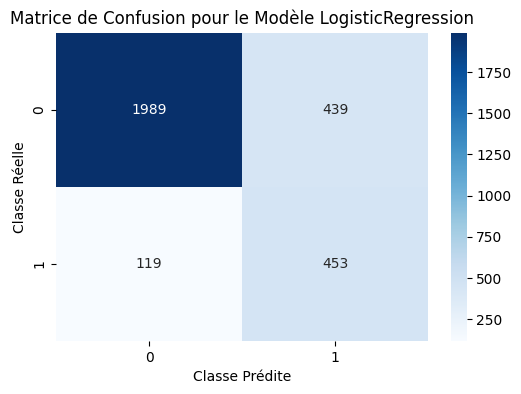

Rapport de Classification pour le Modèle LogisticRegression :

              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      2428
         1.0       0.51      0.79      0.62       572

    accuracy                           0.81      3000
   macro avg       0.73      0.81      0.75      3000
weighted avg       0.86      0.81      0.83      3000



In [38]:
conf_matrix_reglog, classif_report_reglog = evaluate_classification_model(reg_log_base_model, X_val_transformed, y_val)

In [39]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_reglog_base = save_predictions_to_csv(
    model=reg_log_base_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/reglog_base.csv"
)

Les prédictions ont été sauvegardées dans le fichier : ../data/val/reglog_base.csv


#### Test sur l'ensemble test

Maintenant qu'on a teste sur l'ensemble de validation, on va reentraine le modele sur l'ensemble des donnees et le tester sur test (sur kaggle)

In [40]:
reg_log_final_model = LogisticRegression(
    penalty='elasticnet', tol=0.0001, C=0.5, fit_intercept=True, intercept_scaling=1,
    class_weight='balanced', random_state=42, solver='saga', max_iter=100, l1_ratio=0.5
)

predictions_final_reglog = train_and_save_final_predictions(
    model=reg_log_final_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],
    model_name = 'log_reg_final.pkl',
    output_file="../data/test/reglog_final.csv"
)


Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/log_reg_final.pkl'...
No pre-trained model found. Training model from scratch...
Le modele LogisticRegression entraine sur le dataset train complet.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/log_reg_final.pkl.
Les prédictions ont été sauvegardées dans le fichier : ../data/test/reglog_final.csv


### Random Forest

#### Test des resultat sur l'ensemble de validation

In [42]:
# Random Forest
random_forest_model = RandomForestClassifier(
    class_weight = 'balanced', 
    bootstrap = True, 
    max_depth = 15, 
    random_state=42, 
    n_estimators=200
)

auc_mean, auc_std = cross_validate_model(random_forest_model, X_train_transformed, y_train, cv_folds = 5)
random_forest_model, auc_score_random_forest_base = train_and_evaluate_model(random_forest_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'rf_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.9209902463627714, 0.9248534686379144, 0.9358253247985644, 0.938206857433703, 0.9252041313687261]
Moyenne des scores AUC : 0.9290
Écart-type des scores AUC : 0.0067
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/rf_base.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/rf_base.pkl.
AUC Score pour le modèle RandomForestClassifier: 0.9212


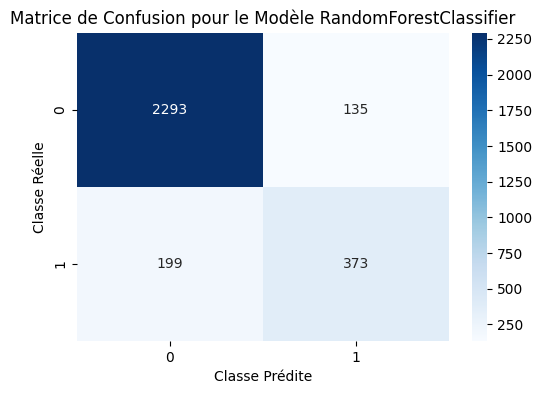

Rapport de Classification pour le Modèle RandomForestClassifier :

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      2428
         1.0       0.73      0.65      0.69       572

    accuracy                           0.89      3000
   macro avg       0.83      0.80      0.81      3000
weighted avg       0.88      0.89      0.89      3000



In [44]:
conf_matrix_random_forest, classif_report_random_forest = evaluate_classification_model(random_forest_model, X_val_transformed, y_val)

In [45]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_random_forest_base = save_predictions_to_csv(
    model=random_forest_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/rf_base.csv"
)

Les prédictions ont été sauvegardées dans le fichier : ../data/val/rf_base.csv


#### Test sur l'ensemble test

In [46]:
predictions_final_random_forest = train_and_save_final_predictions(
    model=random_forest_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'], 
    model_name = 'rf_final.pkl' , 
    output_file="../data/test/rf_final.csv"
)


Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/rf_final.pkl'...
No pre-trained model found. Training model from scratch...
Le modele RandomForestClassifier entraine sur le dataset train complet.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/rf_final.pkl.
Les prédictions ont été sauvegardées dans le fichier : ../data/test/rf_final.csv


#### Test de Hyperparameter tuning avec Optuna

In [51]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    return auc_score


In [52]:
best_rf_params, best_rf_score, rf_study = tune_hyperparameters(
    objective=objective_rf, 
    n_trials=400,
    study_name="rf_study", 
    resume_study=True
)

[I 2024-12-17 22:22:04,582] A new study created in memory with name: no-name-174d9cf5-ca4b-408a-b822-7feb46e57a0c


No previous study found. Starting new study 'rf_study'.


[I 2024-12-17 22:22:14,306] Trial 0 finished with value: 0.9247942132003089 and parameters: {'n_estimators': 459, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9247942132003089.
[I 2024-12-17 22:22:25,996] Trial 1 finished with value: 0.9166941481088928 and parameters: {'n_estimators': 275, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.9247942132003089.
[I 2024-12-17 22:22:29,373] Trial 2 finished with value: 0.9249252600776487 and parameters: {'n_estimators': 167, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.9249252600776487.
[I 2024-12-17 22:22:47,563] Trial 3 finished with value: 0.9255005702699278 and parameters: {'n_estimators': 941, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_featur

Study saved to rf_study.pkl
Best AUC: 0.9288264248107742
Best Parameters: {'n_estimators': 124, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}


In [53]:
# Create the RandomForest model with best parameters
rf_model_test = RandomForestClassifier(
    n_estimators=124, 
    max_depth=10, 
    min_samples_split=15, 
    min_samples_leaf=5, 
    max_features='log2', 
    bootstrap=True, 
    random_state=42
)

# Cross-Validate the Model
auc_mean, auc_std = cross_validate_model(rf_model_test, X_train_transformed, y_train)
rf_model_test, auc_score_random_forest_base = train_and_evaluate_model(rf_model_test, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'rf_optuna_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.9247422268446966, 0.9330540408311382, 0.9398928552942597, 0.9418608412843562, 0.9304077019962387]
Moyenne des scores AUC : 0.9340
Écart-type des scores AUC : 0.0063
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_base.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_base.pkl.
AUC Score pour le modèle RandomForestClassifier: 0.9288


In [54]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_random_forest_base = save_predictions_to_csv(
    model=rf_model_test,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/rf_optuna_base.csv"
)

Les prédictions ont été sauvegardées dans le fichier : ../data/val/rf_optuna_base.csv


In [55]:
predictions_final_random_forest = train_and_save_final_predictions(
    model=rf_model_test,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='rf_optuna_final.pkl',
    output_file="../data/test/rf_optuna_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_final.pkl'...
No pre-trained model found. Training model from scratch...
Le modele RandomForestClassifier entraine sur le dataset train complet.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_final.pkl.
Les prédictions ont été sauvegardées dans le fichier : ../data/test/rf_optuna_final.csv


### SVM

#### Test des resultat sur l'ensemble de validation

In [56]:
# SVM
svm_model = SVC(
    kernel='poly', 
    C=10, 
    gamma='scale', 
    class_weight='balanced',  
    probability=True, 
    random_state=42
)

auc_mean, auc_std = cross_validate_model(svm_model, X_train_transformed, y_train)
svm_model, auc_score_svm_base = train_and_evaluate_model(svm_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name ='svm_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.9132341013337136, 0.9165859353652781, 0.9294323357890923, 0.925442985558757, 0.9153561138045861]
Moyenne des scores AUC : 0.9200
Écart-type des scores AUC : 0.0063
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/svm_base.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/svm_base.pkl.
AUC Score pour le modèle SVC: 0.9168


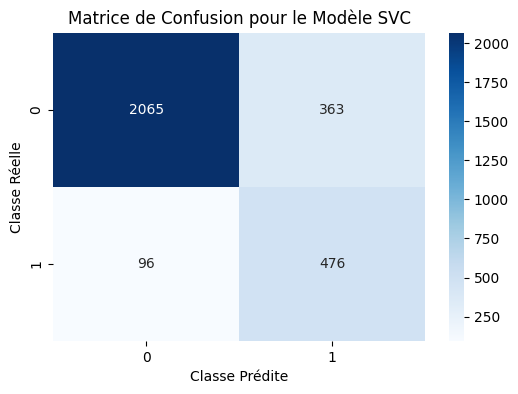

Rapport de Classification pour le Modèle SVC :

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      2428
         1.0       0.57      0.83      0.67       572

    accuracy                           0.85      3000
   macro avg       0.76      0.84      0.79      3000
weighted avg       0.88      0.85      0.86      3000



In [57]:
conf_matrix_svm, classif_report_svm = evaluate_classification_model(svm_model, X_val_transformed, y_val)

In [58]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_svm_base = save_predictions_to_csv(
    model=svm_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/svm_base.csv"
)

Les prédictions ont été sauvegardées dans le fichier : ../data/val/svm_base.csv


#### Test sur l'ensemble test

In [59]:
predictions_final_svm = train_and_save_final_predictions(
    model=svm_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],  
    model_name ='svm_final.pkl',
    output_file="../data/test/svm_final.csv"
)


Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/svm_final.pkl'...
No pre-trained model found. Training model from scratch...
Le modele SVC entraine sur le dataset train complet.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/svm_final.pkl.
Les prédictions ont été sauvegardées dans le fichier : ../data/test/svm_final.csv


### KNN

In [60]:
# KNN
knn_model = KNeighborsClassifier(
    n_neighbors=5, 
    weights = 'distance', 
    p = 2
)

auc_mean, auc_std = cross_validate_model(knn_model, X_train_transformed, y_train)
knn_model, auc_score_knn_base = train_and_evaluate_model(knn_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name ='knn_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.8585236594013895, 0.8608635171198957, 0.8721008600907536, 0.871807010127849, 0.859167687503235]
Moyenne des scores AUC : 0.8645
Écart-type des scores AUC : 0.0061
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/knn_base.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/knn_base.pkl.
AUC Score pour le modèle KNeighborsClassifier: 0.8517


### Naive Bayes

In [61]:
# Naive Bayes Gaussien
nb_model = GaussianNB(var_smoothing=1e-8)

auc_mean, auc_std = cross_validate_model(nb_model, X_train_transformed, y_train)
nb_model, auc_score_nb_base = train_and_evaluate_model(nb_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name ='nb_base.pkl')

Starting cross-validation with 5 folds...


Scores AUC pour chaque fold : [0.8575089830448066, 0.8704605518240955, 0.8755844648803465, 0.890293138252903, 0.875992080608706]
Moyenne des scores AUC : 0.8740
Écart-type des scores AUC : 0.0105
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/nb_base.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/nb_base.pkl.
AUC Score pour le modèle GaussianNB: 0.8699


### Decision Tree Classifier

In [62]:
# Decision Tree
decision_tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)

auc_mean, auc_std = cross_validate_model(decision_tree_model, X_train_transformed, y_train)
decision_tree_model, auc_score_decision_tree_base = train_and_evaluate_model(decision_tree_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'dt_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.8988380092687094, 0.9149059682842087, 0.9205553710381476, 0.9244509049500509, 0.9122154238340896]
Moyenne des scores AUC : 0.9142
Écart-type des scores AUC : 0.0088
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/dt_base.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/dt_base.pkl.
AUC Score pour le modèle DecisionTreeClassifier: 0.9064


### XGBoost

#### Test des resultat sur l'ensemble de validation

In [63]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    eval_metric='logloss'
)

auc_mean, auc_std = cross_validate_model(xgb_model, X_train_transformed, y_train)
xgb_model, auc_score_xgb_base = train_and_evaluate_model(xgb_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'xgb_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.9297572876874775, 0.9362255119552527, 0.9445044126020118, 0.9445669568142997, 0.9345361591814904]
Moyenne des scores AUC : 0.9379
Écart-type des scores AUC : 0.0058
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/xgb_base.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/xgb_base.pkl.
AUC Score pour le modèle XGBClassifier: 0.9303


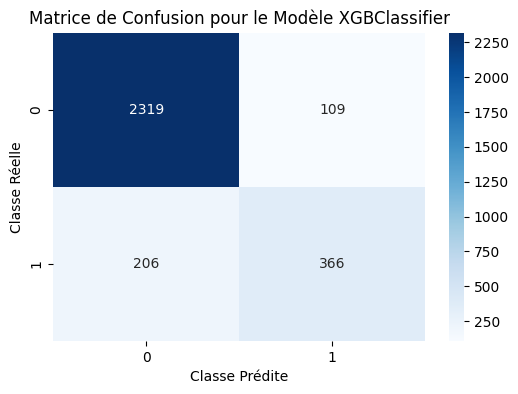

Rapport de Classification pour le Modèle XGBClassifier :

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2428
         1.0       0.77      0.64      0.70       572

    accuracy                           0.90      3000
   macro avg       0.84      0.80      0.82      3000
weighted avg       0.89      0.90      0.89      3000



In [64]:
conf_matrix_xgb, classif_report_xgb = evaluate_classification_model(xgb_model, X_val_transformed, y_val)

In [65]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_xgb_base = save_predictions_to_csv(
    model=xgb_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/xgb_base.csv"
)

Les prédictions ont été sauvegardées dans le fichier : ../data/val/xgb_base.csv


#### Test sur l'ensemble test

In [66]:
predictions_final_xgb = train_and_save_final_predictions(
    model=xgb_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name = 'xgb_final.pkl',
    output_file="../data/test/xgb_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/xgb_final.pkl'...
No pre-trained model found. Training model from scratch...
Le modele XGBClassifier entraine sur le dataset train complet.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/xgb_final.pkl.
Les prédictions ont été sauvegardées dans le fichier : ../data/test/xgb_final.csv


#### Tuning des Hyperparametres avec Optuna

In [67]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),

        # Additional parameters to tune
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),  # Minimum loss reduction
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),  # L2 regularization
    }
    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    return roc_auc_score(y_val, y_val_pred_prob)

In [68]:
best_xgb_params, best_xgb_score, xgb_study = tune_hyperparameters(
    objective=objective_xgb,
    n_trials=400,
    study_name="xgb_study", 
    resume_study=True
)

[I 2024-12-17 23:00:49,006] A new study created in memory with name: no-name-f5cf26e5-87bc-46d5-8b09-83c878276353


No previous study found. Starting new study 'xgb_study'.


[I 2024-12-17 23:01:38,904] Trial 0 finished with value: 0.9269312853538554 and parameters: {'n_estimators': 6744, 'max_depth': 12, 'learning_rate': 0.11702236120849113, 'subsample': 0.5084695763285288, 'colsample_bytree': 0.9939116301573981, 'min_child_weight': 8, 'gamma': 4.342325395807275, 'reg_alpha': 1.9430463686083734, 'reg_lambda': 1.8858161401700932}. Best is trial 0 with value: 0.9269312853538554.
[I 2024-12-17 23:02:13,628] Trial 1 finished with value: 0.9179128120643771 and parameters: {'n_estimators': 9774, 'max_depth': 17, 'learning_rate': 0.18447854021896215, 'subsample': 0.7049447544073759, 'colsample_bytree': 0.6109457023660988, 'min_child_weight': 2, 'gamma': 1.740116610266476, 'reg_alpha': 1.2297561546370759, 'reg_lambda': 1.8303371226604939}. Best is trial 0 with value: 0.9269312853538554.
[I 2024-12-17 23:03:00,575] Trial 2 finished with value: 0.9159672699623277 and parameters: {'n_estimators': 6165, 'max_depth': 9, 'learning_rate': 0.27041776027693065, 'subsample'

Study saved to xgb_study.pkl
Best AUC: 0.9309141743758712
Best Parameters: {'n_estimators': 674, 'max_depth': 3, 'learning_rate': 0.12402933865669706, 'subsample': 0.9434834005597181, 'colsample_bytree': 0.9630982386256489, 'min_child_weight': 2, 'gamma': 3.705054738113971, 'reg_alpha': 0.2989282412992995, 'reg_lambda': 1.162380760830386}


In [72]:
# XGBoost
xgb_model_test = xgb.XGBClassifier(
    n_estimators=674,
    learning_rate=0.12402933865669706,
    max_depth=3,
    random_state=42,
    subsample= 0.9434834005597181, 
    colsample_bytree=0.9630982386256489,
    min_child_weight= 2, 
    gamma= 3.705054738113971, 
    reg_alpha= 0.2989282412992995, 
    reg_lambda=1.162380760830386
)

auc_mean, auc_std = cross_validate_model(xgb_model_test, X_train_transformed, y_train)
xgb_model, auc_score_xgb_base = train_and_evaluate_model(xgb_model_test, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'xgb_optuna_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.9291173773721233, 0.9359938482208334, 0.9450414301488983, 0.9440056764264394, 0.9344213150675478]
Moyenne des scores AUC : 0.9377
Écart-type des scores AUC : 0.0060
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_base.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_base.pkl.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_base.pkl.
AUC Score pour le modèle XGBClassifier: 0.9309


In [73]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_xgb_optuna_base = save_predictions_to_csv(
    model=xgb_model_test,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/xgb_optuna_base.csv"
)

Les prédictions ont été sauvegardées dans le fichier : ../data/val/xgb_optuna_base.csv


In [74]:
predictions_final_xgb_optuna = train_and_save_final_predictions(
    model=xgb_model_test,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='xgb_optuna_final.pkl',
    output_file="../data/test/xgb_optuna_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_final.pkl'...
No pre-trained model found. Training model from scratch...
Le modele XGBClassifier entraine sur le dataset train complet.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_final.pkl.
Les prédictions ont été sauvegardées dans le fichier : ../data/test/xgb_optuna_final.csv


### LightGBM

#### Test des resultat sur l'ensemble de validation

In [75]:
# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

auc_mean, auc_std = cross_validate_model(lgb_model, X_train_transformed, y_train)
lgb_model, auc_score_lgb_base = train_and_evaluate_model(lgb_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'lgb_base.pkl')

Starting cross-validation with 5 folds...
[LightGBM] [Info] Number of positive: 1935, number of negative: 7665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201563 -> initscore=-1.376557
[LightGBM] [Info] Start training from score -1.376557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2418, number of negative: 9582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201500 -> initscore=-1.376946
[LightGBM] [Info] Start training from score -1.376946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

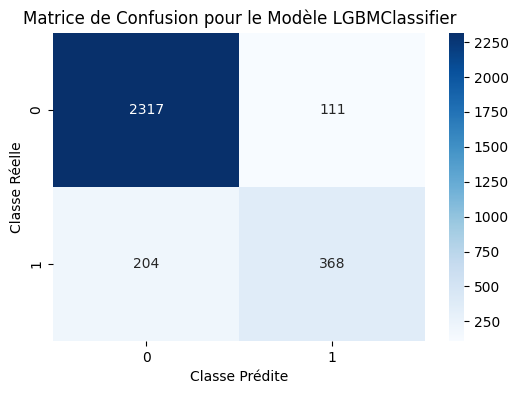

Rapport de Classification pour le Modèle LGBMClassifier :

              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      2428
         1.0       0.77      0.64      0.70       572

    accuracy                           0.90      3000
   macro avg       0.84      0.80      0.82      3000
weighted avg       0.89      0.90      0.89      3000



In [76]:
conf_matrix_lgb, classif_report_lgb = evaluate_classification_model(lgb_model, X_val_transformed, y_val)

In [78]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_lgb_base = save_predictions_to_csv(
    model=lgb_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/lgb_base.csv"
)

Les prédictions ont été sauvegardées dans le fichier : ../data/val/lgb_base.csv


#### Sur l'ensemble test

In [79]:
predictions_final_lgb = train_and_save_final_predictions(
    model=lgb_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name = 'lgb_final.pkl',
    output_file="../data/test/lgb_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/lgb_final.pkl'...
No pre-trained model found. Training model from scratch...
[LightGBM] [Info] Number of positive: 2990, number of negative: 12010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

#### Finetuning des hyperparametres avec Optuna

In [82]:
def objective_lgb(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    #     'num_leaves': trial.suggest_int('num_leaves', 20, 300),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0)
    # }

    params = {
    # Core hyperparameters
    'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
    'max_depth': trial.suggest_int('max_depth', 3, 20),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
    
    # Sampling parameters
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    
    # Regularization parameters
    'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0),
    'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
    'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    
    # Advanced parameters
    'num_leaves': trial.suggest_int('num_leaves', 20, 200),
    'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
    
    # Boosting type
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
    
    # Loss function
    'objective': 'binary',
    'metric': 'auc',
    'class_weight' : 'balanced'
}

    model = lgb.LGBMClassifier(**params, random_state=42)
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    return roc_auc_score(y_val, y_val_pred_prob)


In [83]:
best_lgb_params, best_lgb_score, lgb_study = tune_hyperparameters(
    objective=objective_lgb,
    n_trials=10,
    study_name="lgb_study", 
    resume_study=True
)

Resuming previous study 'lgb_study' with 400 trials.
[LightGBM] [Warning] feature_fraction is set=0.6039354121913731, colsample_bytree=0.8874968119943794 will be ignored. Current value: feature_fraction=0.6039354121913731
[LightGBM] [Warning] bagging_fraction is set=0.9305015498313971, subsample=0.7799508129958291 will be ignored. Current value: bagging_fraction=0.9305015498313971
[LightGBM] [Warning] feature_fraction is set=0.6039354121913731, colsample_bytree=0.8874968119943794 will be ignored. Current value: feature_fraction=0.6039354121913731
[LightGBM] [Warning] bagging_fraction is set=0.9305015498313971, subsample=0.7799508129958291 will be ignored. Current value: bagging_fraction=0.9305015498313971
[LightGBM] [Info] Number of positive: 2418, number of negative: 9582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

[I 2024-12-18 00:29:49,288] Trial 400 finished with value: 0.9290366758447482 and parameters: {'n_estimators': 811, 'max_depth': 3, 'learning_rate': 0.039284178224654825, 'subsample': 0.7799508129958291, 'subsample_freq': 3, 'colsample_bytree': 0.8874968119943794, 'min_child_samples': 54, 'min_child_weight': 8.314815688770395, 'reg_alpha': 3.0856343319891333, 'reg_lambda': 3.310817864161113, 'num_leaves': 97, 'feature_fraction': 0.6039354121913731, 'bagging_fraction': 0.9305015498313971, 'boosting_type': 'gbdt'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6039354121913731, colsample_bytree=0.8874968119943794 will be ignored. Current value: feature_fraction=0.6039354121913731
[LightGBM] [Warning] bagging_fraction is set=0.9305015498313971, subsample=0.7799508129958291 will be ignored. Current value: bagging_fraction=0.9305015498313971
[LightGBM] [Warning] feature_fraction is set=0.5907480233568831, colsample_bytree=0.7536686407135859 will be ignored. Current value: feature_fraction=0.5907480233568831
[LightGBM] [Warning] bagging_fraction is set=0.9122415426579142, subsample=0.56015231625586 will be ignored. Current value: bagging_fraction=0.9122415426579142
[LightGBM] [Warning] feature_fraction is

[I 2024-12-18 00:29:51,173] Trial 401 finished with value: 0.9282179928802663 and parameters: {'n_estimators': 791, 'max_depth': 4, 'learning_rate': 0.06593361310984827, 'subsample': 0.56015231625586, 'subsample_freq': 3, 'colsample_bytree': 0.7536686407135859, 'min_child_samples': 50, 'min_child_weight': 8.447068800913415, 'reg_alpha': 9.068810432469796, 'reg_lambda': 2.948161565205333, 'num_leaves': 94, 'feature_fraction': 0.5907480233568831, 'bagging_fraction': 0.9122415426579142, 'boosting_type': 'gbdt'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] feature_fraction is set=0.5907480233568831, colsample_bytree=0.7536686407135859 will be ignored. Current value: feature_fraction=0.5907480233568831
[LightGBM] [Warning] bagging_fraction is set=0.9122415426579142, subsample=0.56015231625586 will be ignored. Current value: bagging_fraction=0.9122415426579142
[LightGBM] [Warning] feature_fraction is set=0.5648613188051792, colsample_bytree=0.9053624898272473 will be ignored. Current value: feature_fraction=0.5648613188051792
[LightGBM] [Warning] bagging_fraction is set=0.9344093963501156, subsample=0.5480061194470551 will be ignored. Current value: bagging_fraction=0.9344093963501156
[LightGBM] [Warning] feature_fraction is set=0.5648613188051792, colsample_bytree=0.9053624898272473 will be ignored. Current value: feature_fraction=0.5648613188051792
[LightGBM] [Warning] bagging_fraction is set=0.9344093963501156, subsample=0.5480061194470551 will be ignored. Current value: bagging_fraction=0.9344093963501156
[LightGBM

[I 2024-12-18 00:29:53,007] Trial 402 finished with value: 0.9296098259236645 and parameters: {'n_estimators': 823, 'max_depth': 3, 'learning_rate': 0.05030309557260225, 'subsample': 0.5480061194470551, 'subsample_freq': 3, 'colsample_bytree': 0.9053624898272473, 'min_child_samples': 52, 'min_child_weight': 8.713261564149681, 'reg_alpha': 9.267847865376702, 'reg_lambda': 2.5815235381409516, 'num_leaves': 89, 'feature_fraction': 0.5648613188051792, 'bagging_fraction': 0.9344093963501156, 'boosting_type': 'gbdt'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5648613188051792, colsample_bytree=0.9053624898272473 will be ignored. Current value: feature_fraction=0.5648613188051792
[LightGBM] [Warning] bagging_fraction is set=0.9344093963501156, subsample=0.5480061194470551 will be ignored. Current value: bagging_fraction=0.9344093963501156
[LightGBM] [Warning] feature_fraction is set=0.610123063480934, colsample_bytree=0.8963698316906561 will be ignored. Current value: feature_frac

[I 2024-12-18 00:29:54,446] Trial 403 finished with value: 0.9294730187440235 and parameters: {'n_estimators': 848, 'max_depth': 3, 'learning_rate': 0.05637300074536669, 'subsample': 0.5002976461201774, 'subsample_freq': 3, 'colsample_bytree': 0.8963698316906561, 'min_child_samples': 58, 'min_child_weight': 8.160540898793046, 'reg_alpha': 9.518757345906677, 'reg_lambda': 3.348753676299285, 'num_leaves': 82, 'feature_fraction': 0.610123063480934, 'bagging_fraction': 0.9185523784263437, 'boosting_type': 'gbdt'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-18 00:29:55,908] Trial 404 finished with value: 0.9293160505063306 and parameters: {'n_estimators': 759, 'max_depth': 4, 'learning_rate': 0.03162982583573902, 'subsample': 0.5354479689851889, 'subsample_freq': 3, 'colsample_bytree': 0.9192571323727188, 'min_child_samples': 55, 'min_child_weight': 8.9948246243797, 'reg_alpha': 9.470446199060731, 'reg_lambda': 3.1590625630382347, 'num_leaves': 87, 'feature_fraction': 0.573940035316053, 'bagging_fraction': 0.8936021792791017, 'boosting_type': 'gbdt'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-18 00:29:57,959] Trial 405 finished with value: 0.9192513623114941 and parameters: {'n_estimators': 1279, 'max_depth': 3, 'learning_rate': 0.3035230046190781, 'subsample': 0.5202835367766697, 'subsample_freq': 3, 'colsample_bytree': 0.8720469330861962, 'min_child_samples': 59, 'min_child_weight': 8.467854247457472, 'reg_alpha': 8.677266383374388, 'reg_lambda': 3.4747557833580456, 'num_leaves': 93, 'feature_fraction': 0.6002365673726319, 'bagging_fraction': 0.5109427292585926, 'boosting_type': 'gbdt'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-18 00:29:59,422] Trial 406 finished with value: 0.9296011854702135 and parameters: {'n_estimators': 875, 'max_depth': 3, 'learning_rate': 0.042607692183103084, 'subsample': 0.5589304086216607, 'subsample_freq': 3, 'colsample_bytree': 0.9132733640435009, 'min_child_samples': 48, 'min_child_weight': 8.820718009996845, 'reg_alpha': 9.185164415730188, 'reg_lambda': 2.898861463826649, 'num_leaves': 101, 'feature_fraction': 0.5846601619159406, 'bagging_fraction': 0.9222238841771626, 'boosting_type': 'gbdt'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] feature_fraction is set=0.5607318725518624, colsample_bytree=0.8936922470545868 will be ignored. Current value: feature_fraction=0.5607318725518624
[LightGBM] [Warning] bagging_fraction is set=0.9352000598801034, subsample=0.5453960578975312 will be ignored. Current value: bagging_fraction=0.9352000598801034
[LightGBM] [Warning] feature_fraction is set=0.5607318725518624, colsample_bytree=0.8936922470545868 will be ignored. Current value: feature_fraction=0.5607318725518624
[LightGBM] [Warning] bagging_fraction is set=0.9352000598801034, subsample=0.5453960578975312 will be ignored. Current value: bagging_fraction=0.9352000598801034
[LightGBM] [Info] Number of positive: 2418, number of negative: 9582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 838
[LightGBM]

[I 2024-12-18 00:30:01,002] Trial 407 finished with value: 0.9297041508738378 and parameters: {'n_estimators': 791, 'max_depth': 3, 'learning_rate': 0.06864166258608459, 'subsample': 0.5453960578975312, 'subsample_freq': 3, 'colsample_bytree': 0.8936922470545868, 'min_child_samples': 56, 'min_child_weight': 8.204849362243143, 'reg_alpha': 9.65362878600025, 'reg_lambda': 3.8349145976960943, 'num_leaves': 82, 'feature_fraction': 0.5607318725518624, 'bagging_fraction': 0.9352000598801034, 'boosting_type': 'gbdt'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-18 00:30:03,030] Trial 408 finished with value: 0.9288782675314802 and parameters: {'n_estimators': 757, 'max_depth': 4, 'learning_rate': 0.04796618712146467, 'subsample': 0.5318302595423828, 'subsample_freq': 3, 'colsample_bytree': 0.5324249150052109, 'min_child_samples': 54, 'min_child_weight': 8.59928820715781, 'reg_alpha': 9.29468728417006, 'reg_lambda': 3.2270646378082835, 'num_leaves': 96, 'feature_fraction': 0.5882136275516553, 'bagging_fraction': 0.9081386962145399, 'boosting_type': 'gbdt'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-18 00:30:12,189] Trial 409 finished with value: 0.9293556525846477 and parameters: {'n_estimators': 798, 'max_depth': 3, 'learning_rate': 0.06112576900304017, 'subsample': 0.552823873615254, 'subsample_freq': 3, 'colsample_bytree': 0.9279933835188845, 'min_child_samples': 59, 'min_child_weight': 8.346103078585761, 'reg_alpha': 5.713910926744544, 'reg_lambda': 3.5494106194251063, 'num_leaves': 87, 'feature_fraction': 0.5760994600225241, 'bagging_fraction': 0.9295109099672376, 'boosting_type': 'dart'}. Best is trial 364 with value: 0.9303910669231921.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5760994600225241, colsample_bytree=0.9279933835188845 will be ignored. Current value: feature_fraction=0.5760994600225241
[LightGBM] [Warning] bagging_fraction is set=0.9295109099672376, subsample=0.552823873615254 will be ignored. Current value: bagging_fraction=0.9295109099672376
Study saved to lgb_study.pkl
Best AUC: 0.9303910669231921
Best Parameters: {'n_estimators': 693, 'max_depth': 3, 'learning_rate': 0.053472179753032416, 'subsample': 0.5495575892119915, 'subsample_freq': 3, 'colsample_bytree': 0.8893838908599233, 'min_child_samples': 59, 'min_child_weight': 8.603273347220174, 'reg_alpha': 8.930393068193757, 'reg_lambda': 3.355874162357054, 'num_leaves': 90, 'feature_fraction': 0.6466947186842841, 'bagging_fra

In [87]:
# XGBoost
lgb_model_test = lgb.LGBMClassifier(
    n_estimators=693,
    learning_rate=0.053472179753032416,
    max_depth=3,
    random_state=42,
    subsample= 0.5495575892119915, 
    subsample_freq = 3,
    colsample_bytree=0.8893838908599233,
    min_child_samples= 59,
    min_child_weight= 8.603273347220174, 
    reg_alpha= 8.930393068193757, 
    reg_lambda=3.355874162357054,
    num_leaves= 90,
    feature_fraction= 0.6466947186842841, 
    bagging_fraction= 0.9122464230327145, 
    boosting_type= 'gbdt',
    class_weight = 'balanced'
)

auc_mean, auc_std = cross_validate_model(lgb_model_test, X_train_transformed, y_train)
lgb_model, auc_score_lgb_base = train_and_evaluate_model(lgb_model_test, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'lgb_optuna_base.pkl')

Starting cross-validation with 5 folds...
[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Info] Number of positive: 1935, number of negative: 7665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Info] Number of positive: 1935, number of negative: 7665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 840
[LightGBM]

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Info] Number of positive: 1934, number of negative: 7666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Info] Number of positive: 1934, number of negative: 7666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 840
[LightGBM]

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [88]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_lgb_optuna_base = save_predictions_to_csv(
    model=lgb_model_test,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/lgb_optuna_base.csv"
)

[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
Les prédictions ont été sauvegardées dans le fichier : ../data/val/lgb_optuna_base.csv


In [89]:
predictions_final_lgb_optuna = train_and_save_final_predictions(
    model=lgb_model_test,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='lgb_optuna_final.pkl',
    output_file="../data/test/lgb_optuna_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/lgb_optuna_final.pkl'...
No pre-trained model found. Training model from scratch...
[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Info] Number of positive: 2990, number of negative: 12010
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003681 seconds.
You can s

### CatBoost

#### Test des resultat sur l'ensemble de validation

In [90]:
# CatBoost
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    verbose=0,
    random_state=42
)

auc_mean, auc_std = cross_validate_model(catboost_model, X_train_transformed, y_train)
catboost_model, auc_score_catboost_base = train_and_evaluate_model(catboost_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'catboost_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.930223315199841, 0.9364420554459337, 0.9426771510895632, 0.9447659121102849, 0.9361790231025382]
Moyenne des scores AUC : 0.9381
Écart-type des scores AUC : 0.0052
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/catboost_base.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/catboost_base.pkl.
AUC Score pour le modèle CatBoostClassifier: 0.9311


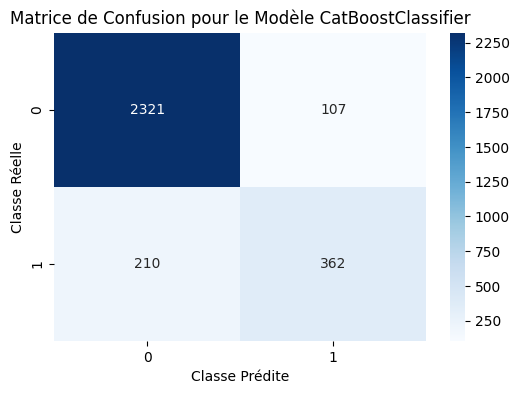

Rapport de Classification pour le Modèle CatBoostClassifier :

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2428
         1.0       0.77      0.63      0.70       572

    accuracy                           0.89      3000
   macro avg       0.84      0.79      0.82      3000
weighted avg       0.89      0.89      0.89      3000



In [91]:
conf_matrix_catboost, classif_report_catboost = evaluate_classification_model(catboost_model, X_val_transformed, y_val)

In [92]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_catboost_base = save_predictions_to_csv(
    model=catboost_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/catboost_base.csv"
)

Les prédictions ont été sauvegardées dans le fichier : ../data/val/catboost_base.csv


#### Sur l'ensemble test

In [94]:
predictions_final_catboost = train_and_save_final_predictions(
    model=catboost_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name = 'catboost_final.pkl',
    output_file="../data/test/catboost_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/catboost_final.pkl'...
No pre-trained model found. Training model from scratch...
Le modele CatBoostClassifier entraine sur le dataset train complet.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/catboost_final.pkl.
Les prédictions ont été sauvegardées dans le fichier : ../data/test/catboost_final.csv


#### Finetuning des hyperparametres avec Optuna

In [106]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 200),  # Restrict range
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Reduce range
        'depth': trial.suggest_int('depth', 4, 6),  # Reduce range
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),  # Reduce range
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Standard range
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),  # Reasonable range
        'rsm': trial.suggest_float('rsm', 0.7, 1.0),  # Smaller range
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'grow_policy': 'Depthwise',
    }

    model = CatBoostClassifier(**params, verbose=0, random_state=42)
    model.fit(X_train_transformed, y_train, eval_set=(X_val_transformed, y_val), early_stopping_rounds=50)

    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    
    print(f"Trial {trial.number}: AUC = {auc_score:.4f} | Params = {params}")
    trial.report(auc_score, step=trial.number)
    
    return auc_score

In [107]:
best_catboost_params, best_catboost_score, catboost_study = tune_hyperparameters(
    objective=objective_catboost,
    n_trials=200,
    study_name="catboost_study", 
    resume_study=True
)

[I 2024-12-18 01:15:44,929] A new study created in memory with name: no-name-fdd25be2-a427-493e-bc7d-e6c8f2afe804


No previous study found. Starting new study 'catboost_study'.


[I 2024-12-18 01:15:45,712] Trial 0 finished with value: 0.9279605793712054 and parameters: {'iterations': 155, 'learning_rate': 0.16553821979216427, 'depth': 6, 'l2_leaf_reg': 4.316258582980088, 'subsample': 0.8053359868213527, 'min_data_in_leaf': 12, 'rsm': 0.8119351837239337}. Best is trial 0 with value: 0.9279605793712054.


Trial 0: AUC = 0.9280 | Params = {'iterations': 155, 'learning_rate': 0.16553821979216427, 'depth': 6, 'l2_leaf_reg': 4.316258582980088, 'subsample': 0.8053359868213527, 'min_data_in_leaf': 12, 'rsm': 0.8119351837239337, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:46,495] Trial 1 finished with value: 0.928764501561042 and parameters: {'iterations': 71, 'learning_rate': 0.16931989845323123, 'depth': 5, 'l2_leaf_reg': 3.7831862233432987, 'subsample': 0.9466112380772895, 'min_data_in_leaf': 25, 'rsm': 0.9001719129360556}. Best is trial 1 with value: 0.928764501561042.


Trial 1: AUC = 0.9288 | Params = {'iterations': 71, 'learning_rate': 0.16931989845323123, 'depth': 5, 'l2_leaf_reg': 3.7831862233432987, 'subsample': 0.9466112380772895, 'min_data_in_leaf': 25, 'rsm': 0.9001719129360556, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:47,355] Trial 2 finished with value: 0.9277654491307704 and parameters: {'iterations': 186, 'learning_rate': 0.1359543267713475, 'depth': 6, 'l2_leaf_reg': 4.879349698622608, 'subsample': 0.916072471687128, 'min_data_in_leaf': 26, 'rsm': 0.9262970869398307}. Best is trial 1 with value: 0.928764501561042.


Trial 2: AUC = 0.9278 | Params = {'iterations': 186, 'learning_rate': 0.1359543267713475, 'depth': 6, 'l2_leaf_reg': 4.879349698622608, 'subsample': 0.916072471687128, 'min_data_in_leaf': 26, 'rsm': 0.9262970869398307, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:48,359] Trial 3 finished with value: 0.9297027107982626 and parameters: {'iterations': 191, 'learning_rate': 0.17781146225877603, 'depth': 4, 'l2_leaf_reg': 4.88082269577664, 'subsample': 0.9796332410109498, 'min_data_in_leaf': 6, 'rsm': 0.9984695386735785}. Best is trial 3 with value: 0.9297027107982626.


Trial 3: AUC = 0.9297 | Params = {'iterations': 191, 'learning_rate': 0.17781146225877603, 'depth': 4, 'l2_leaf_reg': 4.88082269577664, 'subsample': 0.9796332410109498, 'min_data_in_leaf': 6, 'rsm': 0.9984695386735785, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:48,888] Trial 4 finished with value: 0.9287302997661318 and parameters: {'iterations': 85, 'learning_rate': 0.1991041923460194, 'depth': 5, 'l2_leaf_reg': 4.722269902151606, 'subsample': 0.8067869751819551, 'min_data_in_leaf': 25, 'rsm': 0.7699275169103308}. Best is trial 3 with value: 0.9297027107982626.


Trial 4: AUC = 0.9287 | Params = {'iterations': 85, 'learning_rate': 0.1991041923460194, 'depth': 5, 'l2_leaf_reg': 4.722269902151606, 'subsample': 0.8067869751819551, 'min_data_in_leaf': 25, 'rsm': 0.7699275169103308, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:49,668] Trial 5 finished with value: 0.9298092763908249 and parameters: {'iterations': 159, 'learning_rate': 0.10930277628306065, 'depth': 4, 'l2_leaf_reg': 2.404143529011138, 'subsample': 0.8156917789900934, 'min_data_in_leaf': 27, 'rsm': 0.7777082147051123}. Best is trial 5 with value: 0.9298092763908249.


Trial 5: AUC = 0.9298 | Params = {'iterations': 159, 'learning_rate': 0.10930277628306065, 'depth': 4, 'l2_leaf_reg': 2.404143529011138, 'subsample': 0.8156917789900934, 'min_data_in_leaf': 27, 'rsm': 0.7777082147051123, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:50,407] Trial 6 finished with value: 0.9296983905715371 and parameters: {'iterations': 151, 'learning_rate': 0.12220389953166741, 'depth': 5, 'l2_leaf_reg': 4.493443209725613, 'subsample': 0.8003486808143918, 'min_data_in_leaf': 4, 'rsm': 0.9609530410304463}. Best is trial 5 with value: 0.9298092763908249.


Trial 6: AUC = 0.9297 | Params = {'iterations': 151, 'learning_rate': 0.12220389953166741, 'depth': 5, 'l2_leaf_reg': 4.493443209725613, 'subsample': 0.8003486808143918, 'min_data_in_leaf': 4, 'rsm': 0.9609530410304463, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:50,923] Trial 7 finished with value: 0.9290960789622239 and parameters: {'iterations': 128, 'learning_rate': 0.18473005702474915, 'depth': 4, 'l2_leaf_reg': 3.5983996034239034, 'subsample': 0.712057943849061, 'min_data_in_leaf': 5, 'rsm': 0.8324035596267472}. Best is trial 5 with value: 0.9298092763908249.


Trial 7: AUC = 0.9291 | Params = {'iterations': 128, 'learning_rate': 0.18473005702474915, 'depth': 4, 'l2_leaf_reg': 3.5983996034239034, 'subsample': 0.712057943849061, 'min_data_in_leaf': 5, 'rsm': 0.8324035596267472, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:51,632] Trial 8 finished with value: 0.9289877132751927 and parameters: {'iterations': 188, 'learning_rate': 0.10387852333446772, 'depth': 5, 'l2_leaf_reg': 2.8251642518311977, 'subsample': 0.7437075218499962, 'min_data_in_leaf': 18, 'rsm': 0.777148431197224}. Best is trial 5 with value: 0.9298092763908249.


Trial 8: AUC = 0.9290 | Params = {'iterations': 188, 'learning_rate': 0.10387852333446772, 'depth': 5, 'l2_leaf_reg': 2.8251642518311977, 'subsample': 0.7437075218499962, 'min_data_in_leaf': 18, 'rsm': 0.777148431197224, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:52,407] Trial 9 finished with value: 0.9289499112913446 and parameters: {'iterations': 130, 'learning_rate': 0.1483420546629839, 'depth': 5, 'l2_leaf_reg': 3.589270655960395, 'subsample': 0.761094930651975, 'min_data_in_leaf': 17, 'rsm': 0.8915832248496007}. Best is trial 5 with value: 0.9298092763908249.


Trial 9: AUC = 0.9289 | Params = {'iterations': 130, 'learning_rate': 0.1483420546629839, 'depth': 5, 'l2_leaf_reg': 3.589270655960395, 'subsample': 0.761094930651975, 'min_data_in_leaf': 17, 'rsm': 0.8915832248496007, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:52,987] Trial 10 finished with value: 0.9294136156265481 and parameters: {'iterations': 98, 'learning_rate': 0.05159026177223944, 'depth': 4, 'l2_leaf_reg': 1.680542841643974, 'subsample': 0.8745134631510323, 'min_data_in_leaf': 30, 'rsm': 0.7144268972342396}. Best is trial 5 with value: 0.9298092763908249.


Trial 10: AUC = 0.9294 | Params = {'iterations': 98, 'learning_rate': 0.05159026177223944, 'depth': 4, 'l2_leaf_reg': 1.680542841643974, 'subsample': 0.8745134631510323, 'min_data_in_leaf': 30, 'rsm': 0.7144268972342396, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:53,835] Trial 11 finished with value: 0.9297153114595454 and parameters: {'iterations': 166, 'learning_rate': 0.09078160429354412, 'depth': 4, 'l2_leaf_reg': 2.3864359426373576, 'subsample': 0.9869753965378785, 'min_data_in_leaf': 11, 'rsm': 0.9972040308445662}. Best is trial 5 with value: 0.9298092763908249.


Trial 11: AUC = 0.9297 | Params = {'iterations': 166, 'learning_rate': 0.09078160429354412, 'depth': 4, 'l2_leaf_reg': 2.3864359426373576, 'subsample': 0.9869753965378785, 'min_data_in_leaf': 11, 'rsm': 0.9972040308445662, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:54,531] Trial 12 finished with value: 0.9297505933111371 and parameters: {'iterations': 160, 'learning_rate': 0.0859535377485946, 'depth': 4, 'l2_leaf_reg': 2.147331517381221, 'subsample': 0.8760058970942433, 'min_data_in_leaf': 11, 'rsm': 0.7487728040020281}. Best is trial 5 with value: 0.9298092763908249.


Trial 12: AUC = 0.9298 | Params = {'iterations': 160, 'learning_rate': 0.0859535377485946, 'depth': 4, 'l2_leaf_reg': 2.147331517381221, 'subsample': 0.8760058970942433, 'min_data_in_leaf': 11, 'rsm': 0.7487728040020281, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:55,326] Trial 13 finished with value: 0.929826557297727 and parameters: {'iterations': 112, 'learning_rate': 0.07631570329190397, 'depth': 4, 'l2_leaf_reg': 1.0030481099814534, 'subsample': 0.8723489321217542, 'min_data_in_leaf': 20, 'rsm': 0.7028042218717467}. Best is trial 13 with value: 0.929826557297727.


Trial 13: AUC = 0.9298 | Params = {'iterations': 112, 'learning_rate': 0.07631570329190397, 'depth': 4, 'l2_leaf_reg': 1.0030481099814534, 'subsample': 0.8723489321217542, 'min_data_in_leaf': 20, 'rsm': 0.7028042218717467, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:55,953] Trial 14 finished with value: 0.9302193379108535 and parameters: {'iterations': 110, 'learning_rate': 0.059103166727927925, 'depth': 4, 'l2_leaf_reg': 1.1029803017141662, 'subsample': 0.8660464325950981, 'min_data_in_leaf': 21, 'rsm': 0.7013298934482345}. Best is trial 14 with value: 0.9302193379108535.


Trial 14: AUC = 0.9302 | Params = {'iterations': 110, 'learning_rate': 0.059103166727927925, 'depth': 4, 'l2_leaf_reg': 1.1029803017141662, 'subsample': 0.8660464325950981, 'min_data_in_leaf': 21, 'rsm': 0.7013298934482345, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:56,578] Trial 15 finished with value: 0.9293110102418175 and parameters: {'iterations': 106, 'learning_rate': 0.05427611908348222, 'depth': 4, 'l2_leaf_reg': 1.0599173256645413, 'subsample': 0.8961609015231102, 'min_data_in_leaf': 20, 'rsm': 0.7047382567875826}. Best is trial 14 with value: 0.9302193379108535.


Trial 15: AUC = 0.9293 | Params = {'iterations': 106, 'learning_rate': 0.05427611908348222, 'depth': 4, 'l2_leaf_reg': 1.0599173256645413, 'subsample': 0.8961609015231102, 'min_data_in_leaf': 20, 'rsm': 0.7047382567875826, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:57,077] Trial 16 finished with value: 0.9275047954516653 and parameters: {'iterations': 58, 'learning_rate': 0.07250035640149849, 'depth': 4, 'l2_leaf_reg': 1.0112165710153287, 'subsample': 0.8442514250100909, 'min_data_in_leaf': 21, 'rsm': 0.7335204365264237}. Best is trial 14 with value: 0.9302193379108535.


Trial 16: AUC = 0.9275 | Params = {'iterations': 58, 'learning_rate': 0.07250035640149849, 'depth': 4, 'l2_leaf_reg': 1.0112165710153287, 'subsample': 0.8442514250100909, 'min_data_in_leaf': 21, 'rsm': 0.7335204365264237, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:58,004] Trial 17 finished with value: 0.9280729052660683 and parameters: {'iterations': 116, 'learning_rate': 0.07037380814430585, 'depth': 6, 'l2_leaf_reg': 1.5855733185986238, 'subsample': 0.9347049619466865, 'min_data_in_leaf': 22, 'rsm': 0.812619517266388}. Best is trial 14 with value: 0.9302193379108535.


Trial 17: AUC = 0.9281 | Params = {'iterations': 116, 'learning_rate': 0.07037380814430585, 'depth': 6, 'l2_leaf_reg': 1.5855733185986238, 'subsample': 0.9347049619466865, 'min_data_in_leaf': 22, 'rsm': 0.812619517266388, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:58,615] Trial 18 finished with value: 0.92951730106796 and parameters: {'iterations': 88, 'learning_rate': 0.07294151541958598, 'depth': 4, 'l2_leaf_reg': 1.5550209641133006, 'subsample': 0.8484964412733406, 'min_data_in_leaf': 13, 'rsm': 0.7021254088151774}. Best is trial 14 with value: 0.9302193379108535.


Trial 18: AUC = 0.9295 | Params = {'iterations': 88, 'learning_rate': 0.07294151541958598, 'depth': 4, 'l2_leaf_reg': 1.5550209641133006, 'subsample': 0.8484964412733406, 'min_data_in_leaf': 13, 'rsm': 0.7021254088151774, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:59,415] Trial 19 finished with value: 0.9292332461607585 and parameters: {'iterations': 135, 'learning_rate': 0.08631235643361573, 'depth': 5, 'l2_leaf_reg': 1.9404158947270698, 'subsample': 0.8765932013899509, 'min_data_in_leaf': 22, 'rsm': 0.8578799032280223}. Best is trial 14 with value: 0.9302193379108535.


Trial 19: AUC = 0.9292 | Params = {'iterations': 135, 'learning_rate': 0.08631235643361573, 'depth': 5, 'l2_leaf_reg': 1.9404158947270698, 'subsample': 0.8765932013899509, 'min_data_in_leaf': 22, 'rsm': 0.8578799032280223, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:15:59,704] Trial 20 finished with value: 0.9284307640464969 and parameters: {'iterations': 113, 'learning_rate': 0.062483625960993015, 'depth': 5, 'l2_leaf_reg': 1.348984256101856, 'subsample': 0.9535615570665488, 'min_data_in_leaf': 15, 'rsm': 0.7415268046507004}. Best is trial 14 with value: 0.9302193379108535.


Trial 20: AUC = 0.9284 | Params = {'iterations': 113, 'learning_rate': 0.062483625960993015, 'depth': 5, 'l2_leaf_reg': 1.348984256101856, 'subsample': 0.9535615570665488, 'min_data_in_leaf': 15, 'rsm': 0.7415268046507004, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:00,446] Trial 21 finished with value: 0.9290571969216945 and parameters: {'iterations': 143, 'learning_rate': 0.10871501603706801, 'depth': 4, 'l2_leaf_reg': 2.6113038393216, 'subsample': 0.8341128230340454, 'min_data_in_leaf': 30, 'rsm': 0.7777411261980953}. Best is trial 14 with value: 0.9302193379108535.


Trial 21: AUC = 0.9291 | Params = {'iterations': 143, 'learning_rate': 0.10871501603706801, 'depth': 4, 'l2_leaf_reg': 2.6113038393216, 'subsample': 0.8341128230340454, 'min_data_in_leaf': 30, 'rsm': 0.7777411261980953, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:01,159] Trial 22 finished with value: 0.9305782767479638 and parameters: {'iterations': 168, 'learning_rate': 0.10580018182129233, 'depth': 4, 'l2_leaf_reg': 3.0371115510149824, 'subsample': 0.8268036749019643, 'min_data_in_leaf': 27, 'rsm': 0.7518632711159945}. Best is trial 22 with value: 0.9305782767479638.


Trial 22: AUC = 0.9306 | Params = {'iterations': 168, 'learning_rate': 0.10580018182129233, 'depth': 4, 'l2_leaf_reg': 3.0371115510149824, 'subsample': 0.8268036749019643, 'min_data_in_leaf': 27, 'rsm': 0.7518632711159945, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:02,619] Trial 23 finished with value: 0.9292494470109791 and parameters: {'iterations': 174, 'learning_rate': 0.0939793904425247, 'depth': 4, 'l2_leaf_reg': 3.1719473138560006, 'subsample': 0.7718558461672007, 'min_data_in_leaf': 23, 'rsm': 0.727192280129131}. Best is trial 22 with value: 0.9305782767479638.


Trial 23: AUC = 0.9292 | Params = {'iterations': 174, 'learning_rate': 0.0939793904425247, 'depth': 4, 'l2_leaf_reg': 3.1719473138560006, 'subsample': 0.7718558461672007, 'min_data_in_leaf': 23, 'rsm': 0.727192280129131, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:03,501] Trial 24 finished with value: 0.9296609486065829 and parameters: {'iterations': 118, 'learning_rate': 0.12056444687401774, 'depth': 4, 'l2_leaf_reg': 3.2193111097653793, 'subsample': 0.888943817064306, 'min_data_in_leaf': 19, 'rsm': 0.7546903251644739}. Best is trial 22 with value: 0.9305782767479638.


Trial 24: AUC = 0.9297 | Params = {'iterations': 118, 'learning_rate': 0.12056444687401774, 'depth': 4, 'l2_leaf_reg': 3.2193111097653793, 'subsample': 0.888943817064306, 'min_data_in_leaf': 19, 'rsm': 0.7546903251644739, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:04,169] Trial 25 finished with value: 0.9298946008686536 and parameters: {'iterations': 90, 'learning_rate': 0.06348677056436618, 'depth': 4, 'l2_leaf_reg': 1.9445384193405992, 'subsample': 0.9091362136629986, 'min_data_in_leaf': 28, 'rsm': 0.7225206543666519}. Best is trial 22 with value: 0.9305782767479638.


Trial 25: AUC = 0.9299 | Params = {'iterations': 90, 'learning_rate': 0.06348677056436618, 'depth': 4, 'l2_leaf_reg': 1.9445384193405992, 'subsample': 0.9091362136629986, 'min_data_in_leaf': 28, 'rsm': 0.7225206543666519, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:04,653] Trial 26 finished with value: 0.9289290301955047 and parameters: {'iterations': 77, 'learning_rate': 0.060177863946137465, 'depth': 4, 'l2_leaf_reg': 2.017929002298026, 'subsample': 0.8266195439927608, 'min_data_in_leaf': 28, 'rsm': 0.7997838758375594}. Best is trial 22 with value: 0.9305782767479638.


Trial 26: AUC = 0.9289 | Params = {'iterations': 77, 'learning_rate': 0.060177863946137465, 'depth': 4, 'l2_leaf_reg': 2.017929002298026, 'subsample': 0.8266195439927608, 'min_data_in_leaf': 28, 'rsm': 0.7997838758375594, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:05,054] Trial 27 finished with value: 0.9300206074814806 and parameters: {'iterations': 52, 'learning_rate': 0.14128334669149673, 'depth': 4, 'l2_leaf_reg': 2.9222934927764235, 'subsample': 0.9115286388924665, 'min_data_in_leaf': 28, 'rsm': 0.7271060484132669}. Best is trial 22 with value: 0.9305782767479638.


Trial 27: AUC = 0.9300 | Params = {'iterations': 52, 'learning_rate': 0.14128334669149673, 'depth': 4, 'l2_leaf_reg': 2.9222934927764235, 'subsample': 0.9115286388924665, 'min_data_in_leaf': 28, 'rsm': 0.7271060484132669, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:05,533] Trial 28 finished with value: 0.9288221045840486 and parameters: {'iterations': 52, 'learning_rate': 0.14661176762419448, 'depth': 5, 'l2_leaf_reg': 4.170308708754154, 'subsample': 0.9225636806639879, 'min_data_in_leaf': 23, 'rsm': 0.7585995635912557}. Best is trial 22 with value: 0.9305782767479638.


Trial 28: AUC = 0.9288 | Params = {'iterations': 52, 'learning_rate': 0.14661176762419448, 'depth': 5, 'l2_leaf_reg': 4.170308708754154, 'subsample': 0.9225636806639879, 'min_data_in_leaf': 23, 'rsm': 0.7585995635912557, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:06,247] Trial 29 finished with value: 0.9278086513980253 and parameters: {'iterations': 69, 'learning_rate': 0.13852220290012016, 'depth': 6, 'l2_leaf_reg': 2.9147009681135216, 'subsample': 0.7819102836088366, 'min_data_in_leaf': 1, 'rsm': 0.8079729743602324}. Best is trial 22 with value: 0.9305782767479638.


Trial 29: AUC = 0.9278 | Params = {'iterations': 69, 'learning_rate': 0.13852220290012016, 'depth': 6, 'l2_leaf_reg': 2.9147009681135216, 'subsample': 0.7819102836088366, 'min_data_in_leaf': 1, 'rsm': 0.8079729743602324, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:07,273] Trial 30 finished with value: 0.9290334356747041 and parameters: {'iterations': 200, 'learning_rate': 0.15679145184622928, 'depth': 4, 'l2_leaf_reg': 4.0924889890304375, 'subsample': 0.8578096602676385, 'min_data_in_leaf': 24, 'rsm': 0.8512402731265044}. Best is trial 22 with value: 0.9305782767479638.


Trial 30: AUC = 0.9290 | Params = {'iterations': 200, 'learning_rate': 0.15679145184622928, 'depth': 4, 'l2_leaf_reg': 4.0924889890304375, 'subsample': 0.8578096602676385, 'min_data_in_leaf': 24, 'rsm': 0.8512402731265044, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:07,912] Trial 31 finished with value: 0.9300854108823632 and parameters: {'iterations': 99, 'learning_rate': 0.0630241627000952, 'depth': 4, 'l2_leaf_reg': 2.651385760735744, 'subsample': 0.9051691425852008, 'min_data_in_leaf': 28, 'rsm': 0.7227708305402457}. Best is trial 22 with value: 0.9305782767479638.


Trial 31: AUC = 0.9301 | Params = {'iterations': 99, 'learning_rate': 0.0630241627000952, 'depth': 4, 'l2_leaf_reg': 2.651385760735744, 'subsample': 0.9051691425852008, 'min_data_in_leaf': 28, 'rsm': 0.7227708305402457, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:08,714] Trial 32 finished with value: 0.9299864056865701 and parameters: {'iterations': 140, 'learning_rate': 0.13268350656178562, 'depth': 4, 'l2_leaf_reg': 3.4650734372013923, 'subsample': 0.9573836860308563, 'min_data_in_leaf': 29, 'rsm': 0.7270289490591039}. Best is trial 22 with value: 0.9305782767479638.


Trial 32: AUC = 0.9300 | Params = {'iterations': 140, 'learning_rate': 0.13268350656178562, 'depth': 4, 'l2_leaf_reg': 3.4650734372013923, 'subsample': 0.9573836860308563, 'min_data_in_leaf': 29, 'rsm': 0.7270289490591039, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:09,290] Trial 33 finished with value: 0.929867959470513 and parameters: {'iterations': 101, 'learning_rate': 0.09838218228420842, 'depth': 4, 'l2_leaf_reg': 2.6788898471564986, 'subsample': 0.9342597290558164, 'min_data_in_leaf': 26, 'rsm': 0.7422113007587198}. Best is trial 22 with value: 0.9305782767479638.


Trial 33: AUC = 0.9299 | Params = {'iterations': 101, 'learning_rate': 0.09838218228420842, 'depth': 4, 'l2_leaf_reg': 2.6788898471564986, 'subsample': 0.9342597290558164, 'min_data_in_leaf': 26, 'rsm': 0.7422113007587198, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:09,854] Trial 34 finished with value: 0.9282593950530524 and parameters: {'iterations': 64, 'learning_rate': 0.16375818142880721, 'depth': 5, 'l2_leaf_reg': 3.1616221596126173, 'subsample': 0.8997073897143376, 'min_data_in_leaf': 25, 'rsm': 0.7936663345473541}. Best is trial 22 with value: 0.9305782767479638.


Trial 34: AUC = 0.9283 | Params = {'iterations': 64, 'learning_rate': 0.16375818142880721, 'depth': 5, 'l2_leaf_reg': 3.1616221596126173, 'subsample': 0.8997073897143376, 'min_data_in_leaf': 25, 'rsm': 0.7936663345473541, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:10,736] Trial 35 finished with value: 0.9296803896268475 and parameters: {'iterations': 123, 'learning_rate': 0.08141081040344571, 'depth': 4, 'l2_leaf_reg': 3.823402173836726, 'subsample': 0.9721517377717293, 'min_data_in_leaf': 27, 'rsm': 0.7164670012869214}. Best is trial 22 with value: 0.9305782767479638.


Trial 35: AUC = 0.9297 | Params = {'iterations': 123, 'learning_rate': 0.08141081040344571, 'depth': 4, 'l2_leaf_reg': 3.823402173836726, 'subsample': 0.9721517377717293, 'min_data_in_leaf': 27, 'rsm': 0.7164670012869214, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:11,158] Trial 36 finished with value: 0.9284714461814956 and parameters: {'iterations': 78, 'learning_rate': 0.11760120898265755, 'depth': 4, 'l2_leaf_reg': 2.3576546727497556, 'subsample': 0.9257838528159155, 'min_data_in_leaf': 26, 'rsm': 0.7648960075441047}. Best is trial 22 with value: 0.9305782767479638.


Trial 36: AUC = 0.9285 | Params = {'iterations': 78, 'learning_rate': 0.11760120898265755, 'depth': 4, 'l2_leaf_reg': 2.3576546727497556, 'subsample': 0.9257838528159155, 'min_data_in_leaf': 26, 'rsm': 0.7648960075441047, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:11,782] Trial 37 finished with value: 0.9297037908549439 and parameters: {'iterations': 99, 'learning_rate': 0.13137035216685808, 'depth': 4, 'l2_leaf_reg': 3.320595330781829, 'subsample': 0.854464933712071, 'min_data_in_leaf': 28, 'rsm': 0.7390238239879857}. Best is trial 22 with value: 0.9305782767479638.


Trial 37: AUC = 0.9297 | Params = {'iterations': 99, 'learning_rate': 0.13137035216685808, 'depth': 4, 'l2_leaf_reg': 3.320595330781829, 'subsample': 0.854464933712071, 'min_data_in_leaf': 28, 'rsm': 0.7390238239879857, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:12,858] Trial 38 finished with value: 0.9298186368820636 and parameters: {'iterations': 147, 'learning_rate': 0.05004343020596894, 'depth': 5, 'l2_leaf_reg': 2.62883390953749, 'subsample': 0.7980816821629997, 'min_data_in_leaf': 24, 'rsm': 0.824899980435537}. Best is trial 22 with value: 0.9305782767479638.


Trial 38: AUC = 0.9298 | Params = {'iterations': 147, 'learning_rate': 0.05004343020596894, 'depth': 5, 'l2_leaf_reg': 2.62883390953749, 'subsample': 0.7980816821629997, 'min_data_in_leaf': 24, 'rsm': 0.824899980435537, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:13,228] Trial 39 finished with value: 0.9289977938042188 and parameters: {'iterations': 80, 'learning_rate': 0.17456075642188462, 'depth': 4, 'l2_leaf_reg': 3.009251226080264, 'subsample': 0.9041334768624069, 'min_data_in_leaf': 30, 'rsm': 0.7880492716728202}. Best is trial 22 with value: 0.9305782767479638.


Trial 39: AUC = 0.9290 | Params = {'iterations': 80, 'learning_rate': 0.17456075642188462, 'depth': 4, 'l2_leaf_reg': 3.009251226080264, 'subsample': 0.9041334768624069, 'min_data_in_leaf': 30, 'rsm': 0.7880492716728202, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:14,081] Trial 40 finished with value: 0.9290075143143512 and parameters: {'iterations': 171, 'learning_rate': 0.11385789954648008, 'depth': 6, 'l2_leaf_reg': 3.8618077846371093, 'subsample': 0.8198781722304823, 'min_data_in_leaf': 16, 'rsm': 0.8927850807816512}. Best is trial 22 with value: 0.9305782767479638.


Trial 40: AUC = 0.9290 | Params = {'iterations': 171, 'learning_rate': 0.11385789954648008, 'depth': 6, 'l2_leaf_reg': 3.8618077846371093, 'subsample': 0.8198781722304823, 'min_data_in_leaf': 16, 'rsm': 0.8927850807816512, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:14,935] Trial 41 finished with value: 0.9296533882098132 and parameters: {'iterations': 141, 'learning_rate': 0.13550772447557924, 'depth': 4, 'l2_leaf_reg': 3.405188477062536, 'subsample': 0.9562515483263915, 'min_data_in_leaf': 29, 'rsm': 0.7226368416182174}. Best is trial 22 with value: 0.9305782767479638.


Trial 41: AUC = 0.9297 | Params = {'iterations': 141, 'learning_rate': 0.13550772447557924, 'depth': 4, 'l2_leaf_reg': 3.405188477062536, 'subsample': 0.9562515483263915, 'min_data_in_leaf': 29, 'rsm': 0.7226368416182174, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:15,471] Trial 42 finished with value: 0.9292318060851833 and parameters: {'iterations': 178, 'learning_rate': 0.12592003407945251, 'depth': 4, 'l2_leaf_reg': 3.6848281222298844, 'subsample': 0.9721142363819726, 'min_data_in_leaf': 26, 'rsm': 0.7298229558249112}. Best is trial 22 with value: 0.9305782767479638.


Trial 42: AUC = 0.9292 | Params = {'iterations': 178, 'learning_rate': 0.12592003407945251, 'depth': 4, 'l2_leaf_reg': 3.6848281222298844, 'subsample': 0.9721142363819726, 'min_data_in_leaf': 26, 'rsm': 0.7298229558249112, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:16,004] Trial 43 finished with value: 0.9301962967016508 and parameters: {'iterations': 137, 'learning_rate': 0.14402925541345785, 'depth': 4, 'l2_leaf_reg': 3.401451451834471, 'subsample': 0.941150020218291, 'min_data_in_leaf': 28, 'rsm': 0.7134189376181728}. Best is trial 22 with value: 0.9305782767479638.


Trial 43: AUC = 0.9302 | Params = {'iterations': 137, 'learning_rate': 0.14402925541345785, 'depth': 4, 'l2_leaf_reg': 3.401451451834471, 'subsample': 0.941150020218291, 'min_data_in_leaf': 28, 'rsm': 0.7134189376181728, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:16,661] Trial 44 finished with value: 0.9300144871602861 and parameters: {'iterations': 153, 'learning_rate': 0.14224659523571187, 'depth': 4, 'l2_leaf_reg': 3.0341106697914597, 'subsample': 0.9953530114790483, 'min_data_in_leaf': 27, 'rsm': 0.7131839328629719}. Best is trial 22 with value: 0.9305782767479638.


Trial 44: AUC = 0.9300 | Params = {'iterations': 153, 'learning_rate': 0.14224659523571187, 'depth': 4, 'l2_leaf_reg': 3.0341106697914597, 'subsample': 0.9953530114790483, 'min_data_in_leaf': 27, 'rsm': 0.7131839328629719, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:17,342] Trial 45 finished with value: 0.9292710481446067 and parameters: {'iterations': 131, 'learning_rate': 0.15729449773051435, 'depth': 4, 'l2_leaf_reg': 2.775832273575179, 'subsample': 0.9421057747174131, 'min_data_in_leaf': 25, 'rsm': 0.7526179515631902}. Best is trial 22 with value: 0.9305782767479638.


Trial 45: AUC = 0.9293 | Params = {'iterations': 131, 'learning_rate': 0.15729449773051435, 'depth': 4, 'l2_leaf_reg': 2.775832273575179, 'subsample': 0.9421057747174131, 'min_data_in_leaf': 25, 'rsm': 0.7526179515631902, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:17,829] Trial 46 finished with value: 0.9304202284535892 and parameters: {'iterations': 107, 'learning_rate': 0.18834280533482955, 'depth': 4, 'l2_leaf_reg': 2.260852303757096, 'subsample': 0.8884874485015521, 'min_data_in_leaf': 29, 'rsm': 0.8677799078285716}. Best is trial 22 with value: 0.9305782767479638.


Trial 46: AUC = 0.9304 | Params = {'iterations': 107, 'learning_rate': 0.18834280533482955, 'depth': 4, 'l2_leaf_reg': 2.260852303757096, 'subsample': 0.8884874485015521, 'min_data_in_leaf': 29, 'rsm': 0.8677799078285716, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:18,385] Trial 47 finished with value: 0.9288537862467021 and parameters: {'iterations': 108, 'learning_rate': 0.19372559174212087, 'depth': 5, 'l2_leaf_reg': 2.2861728409728372, 'subsample': 0.8662830166243749, 'min_data_in_leaf': 30, 'rsm': 0.8673661823230978}. Best is trial 22 with value: 0.9305782767479638.


Trial 47: AUC = 0.9289 | Params = {'iterations': 108, 'learning_rate': 0.19372559174212087, 'depth': 5, 'l2_leaf_reg': 2.2861728409728372, 'subsample': 0.8662830166243749, 'min_data_in_leaf': 30, 'rsm': 0.8673661823230978, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:18,976] Trial 48 finished with value: 0.9300310480294006 and parameters: {'iterations': 97, 'learning_rate': 0.17773869615812782, 'depth': 4, 'l2_leaf_reg': 2.5072161994414524, 'subsample': 0.8875458322294449, 'min_data_in_leaf': 24, 'rsm': 0.9277322376828845}. Best is trial 22 with value: 0.9305782767479638.


Trial 48: AUC = 0.9300 | Params = {'iterations': 97, 'learning_rate': 0.17773869615812782, 'depth': 4, 'l2_leaf_reg': 2.5072161994414524, 'subsample': 0.8875458322294449, 'min_data_in_leaf': 24, 'rsm': 0.9277322376828845, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:19,684] Trial 49 finished with value: 0.929963004458474 and parameters: {'iterations': 121, 'learning_rate': 0.1877912720194202, 'depth': 4, 'l2_leaf_reg': 3.5427002910353282, 'subsample': 0.8358648293586316, 'min_data_in_leaf': 7, 'rsm': 0.871922231723975}. Best is trial 22 with value: 0.9305782767479638.


Trial 49: AUC = 0.9300 | Params = {'iterations': 121, 'learning_rate': 0.1877912720194202, 'depth': 4, 'l2_leaf_reg': 3.5427002910353282, 'subsample': 0.8358648293586316, 'min_data_in_leaf': 7, 'rsm': 0.871922231723975, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:20,357] Trial 50 finished with value: 0.9303842265642102 and parameters: {'iterations': 106, 'learning_rate': 0.1673284095421519, 'depth': 4, 'l2_leaf_reg': 1.7825915486450992, 'subsample': 0.8871889785792306, 'min_data_in_leaf': 27, 'rsm': 0.9154352011377881}. Best is trial 22 with value: 0.9305782767479638.


Trial 50: AUC = 0.9304 | Params = {'iterations': 106, 'learning_rate': 0.1673284095421519, 'depth': 4, 'l2_leaf_reg': 1.7825915486450992, 'subsample': 0.8871889785792306, 'min_data_in_leaf': 27, 'rsm': 0.9154352011377881, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:20,848] Trial 51 finished with value: 0.9287767422034309 and parameters: {'iterations': 94, 'learning_rate': 0.16943701013786408, 'depth': 4, 'l2_leaf_reg': 1.2678699632781738, 'subsample': 0.8851848719666615, 'min_data_in_leaf': 27, 'rsm': 0.9192175184842922}. Best is trial 22 with value: 0.9305782767479638.


Trial 51: AUC = 0.9288 | Params = {'iterations': 94, 'learning_rate': 0.16943701013786408, 'depth': 4, 'l2_leaf_reg': 1.2678699632781738, 'subsample': 0.8851848719666615, 'min_data_in_leaf': 27, 'rsm': 0.9192175184842922, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:21,373] Trial 52 finished with value: 0.9299183621156438 and parameters: {'iterations': 106, 'learning_rate': 0.19975502050643237, 'depth': 4, 'l2_leaf_reg': 1.7309409497780757, 'subsample': 0.863377274269511, 'min_data_in_leaf': 29, 'rsm': 0.9710888956125902}. Best is trial 22 with value: 0.9305782767479638.


Trial 52: AUC = 0.9299 | Params = {'iterations': 106, 'learning_rate': 0.19975502050643237, 'depth': 4, 'l2_leaf_reg': 1.7309409497780757, 'subsample': 0.863377274269511, 'min_data_in_leaf': 29, 'rsm': 0.9710888956125902, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:21,918] Trial 53 finished with value: 0.9297664341424636 and parameters: {'iterations': 109, 'learning_rate': 0.1873069848115542, 'depth': 4, 'l2_leaf_reg': 1.7801365962052422, 'subsample': 0.9224209064933573, 'min_data_in_leaf': 21, 'rsm': 0.8796763496553649}. Best is trial 22 with value: 0.9305782767479638.


Trial 53: AUC = 0.9298 | Params = {'iterations': 109, 'learning_rate': 0.1873069848115542, 'depth': 4, 'l2_leaf_reg': 1.7801365962052422, 'subsample': 0.9224209064933573, 'min_data_in_leaf': 21, 'rsm': 0.8796763496553649, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:22,596] Trial 54 finished with value: 0.9294388169491136 and parameters: {'iterations': 127, 'learning_rate': 0.15816026769895558, 'depth': 4, 'l2_leaf_reg': 2.18235019575529, 'subsample': 0.8404088093087769, 'min_data_in_leaf': 26, 'rsm': 0.9065467157622495}. Best is trial 22 with value: 0.9305782767479638.


Trial 54: AUC = 0.9294 | Params = {'iterations': 127, 'learning_rate': 0.15816026769895558, 'depth': 4, 'l2_leaf_reg': 2.18235019575529, 'subsample': 0.8404088093087769, 'min_data_in_leaf': 26, 'rsm': 0.9065467157622495, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:23,133] Trial 55 finished with value: 0.9302175378163846 and parameters: {'iterations': 162, 'learning_rate': 0.18319252097892974, 'depth': 4, 'l2_leaf_reg': 2.088726021989197, 'subsample': 0.8785855454831513, 'min_data_in_leaf': 29, 'rsm': 0.9409305898119357}. Best is trial 22 with value: 0.9305782767479638.


Trial 55: AUC = 0.9302 | Params = {'iterations': 162, 'learning_rate': 0.18319252097892974, 'depth': 4, 'l2_leaf_reg': 2.088726021989197, 'subsample': 0.8785855454831513, 'min_data_in_leaf': 29, 'rsm': 0.9409305898119357, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:23,585] Trial 56 finished with value: 0.930543354915266 and parameters: {'iterations': 180, 'learning_rate': 0.19413099442999168, 'depth': 4, 'l2_leaf_reg': 1.4274772904161868, 'subsample': 0.8077240058331157, 'min_data_in_leaf': 18, 'rsm': 0.9527340079168635}. Best is trial 22 with value: 0.9305782767479638.


Trial 56: AUC = 0.9305 | Params = {'iterations': 180, 'learning_rate': 0.19413099442999168, 'depth': 4, 'l2_leaf_reg': 1.4274772904161868, 'subsample': 0.8077240058331157, 'min_data_in_leaf': 18, 'rsm': 0.9527340079168635, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:24,063] Trial 57 finished with value: 0.9298197169387449 and parameters: {'iterations': 184, 'learning_rate': 0.18506588807524746, 'depth': 4, 'l2_leaf_reg': 1.4325864319483061, 'subsample': 0.8077033504070413, 'min_data_in_leaf': 18, 'rsm': 0.9566124348357063}. Best is trial 22 with value: 0.9305782767479638.


Trial 57: AUC = 0.9298 | Params = {'iterations': 184, 'learning_rate': 0.18506588807524746, 'depth': 4, 'l2_leaf_reg': 1.4325864319483061, 'subsample': 0.8077033504070413, 'min_data_in_leaf': 18, 'rsm': 0.9566124348357063, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:24,640] Trial 58 finished with value: 0.928821384546261 and parameters: {'iterations': 159, 'learning_rate': 0.19422430257680928, 'depth': 4, 'l2_leaf_reg': 1.2259038394814405, 'subsample': 0.7886833827183152, 'min_data_in_leaf': 14, 'rsm': 0.9451690609214506}. Best is trial 22 with value: 0.9305782767479638.


Trial 58: AUC = 0.9288 | Params = {'iterations': 159, 'learning_rate': 0.19422430257680928, 'depth': 4, 'l2_leaf_reg': 1.2259038394814405, 'subsample': 0.7886833827183152, 'min_data_in_leaf': 14, 'rsm': 0.9451690609214506, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:25,115] Trial 59 finished with value: 0.9289337104411239 and parameters: {'iterations': 165, 'learning_rate': 0.18046053503862394, 'depth': 4, 'l2_leaf_reg': 1.5483370934235756, 'subsample': 0.8259403960399462, 'min_data_in_leaf': 17, 'rsm': 0.9793395907612624}. Best is trial 22 with value: 0.9305782767479638.


Trial 59: AUC = 0.9289 | Params = {'iterations': 165, 'learning_rate': 0.18046053503862394, 'depth': 4, 'l2_leaf_reg': 1.5483370934235756, 'subsample': 0.8259403960399462, 'min_data_in_leaf': 17, 'rsm': 0.9793395907612624, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:25,913] Trial 60 finished with value: 0.9277719294708586 and parameters: {'iterations': 194, 'learning_rate': 0.19426349034918644, 'depth': 5, 'l2_leaf_reg': 1.1637353639477184, 'subsample': 0.7484123466816283, 'min_data_in_leaf': 20, 'rsm': 0.9375530261200129}. Best is trial 22 with value: 0.9305782767479638.


Trial 60: AUC = 0.9278 | Params = {'iterations': 194, 'learning_rate': 0.19426349034918644, 'depth': 5, 'l2_leaf_reg': 1.1637353639477184, 'subsample': 0.7484123466816283, 'min_data_in_leaf': 20, 'rsm': 0.9375530261200129, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:26,619] Trial 61 finished with value: 0.9299378031359087 and parameters: {'iterations': 180, 'learning_rate': 0.1730129282967561, 'depth': 4, 'l2_leaf_reg': 1.4241934266851577, 'subsample': 0.8133725997010068, 'min_data_in_leaf': 29, 'rsm': 0.9137384924341315}. Best is trial 22 with value: 0.9305782767479638.


Trial 61: AUC = 0.9299 | Params = {'iterations': 180, 'learning_rate': 0.1730129282967561, 'depth': 4, 'l2_leaf_reg': 1.4241934266851577, 'subsample': 0.8133725997010068, 'min_data_in_leaf': 29, 'rsm': 0.9137384924341315, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:27,063] Trial 62 finished with value: 0.9295515028628702 and parameters: {'iterations': 171, 'learning_rate': 0.18205860453319386, 'depth': 4, 'l2_leaf_reg': 1.875490919676274, 'subsample': 0.8463426565081505, 'min_data_in_leaf': 18, 'rsm': 0.8381713200360794}. Best is trial 22 with value: 0.9305782767479638.


Trial 62: AUC = 0.9296 | Params = {'iterations': 171, 'learning_rate': 0.18205860453319386, 'depth': 4, 'l2_leaf_reg': 1.875490919676274, 'subsample': 0.8463426565081505, 'min_data_in_leaf': 18, 'rsm': 0.8381713200360794, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:27,528] Trial 63 finished with value: 0.9299730849875003 and parameters: {'iterations': 116, 'learning_rate': 0.1634833705795548, 'depth': 4, 'l2_leaf_reg': 2.1026954204660235, 'subsample': 0.8785987707803206, 'min_data_in_leaf': 23, 'rsm': 0.9481063278285099}. Best is trial 22 with value: 0.9305782767479638.


Trial 63: AUC = 0.9300 | Params = {'iterations': 116, 'learning_rate': 0.1634833705795548, 'depth': 4, 'l2_leaf_reg': 2.1026954204660235, 'subsample': 0.8785987707803206, 'min_data_in_leaf': 23, 'rsm': 0.9481063278285099, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:28,049] Trial 64 finished with value: 0.9285808919252082 and parameters: {'iterations': 167, 'learning_rate': 0.1507552256372822, 'depth': 4, 'l2_leaf_reg': 1.6069768937366198, 'subsample': 0.868299676522306, 'min_data_in_leaf': 30, 'rsm': 0.9865256627081076}. Best is trial 22 with value: 0.9305782767479638.


Trial 64: AUC = 0.9286 | Params = {'iterations': 167, 'learning_rate': 0.1507552256372822, 'depth': 4, 'l2_leaf_reg': 1.6069768937366198, 'subsample': 0.868299676522306, 'min_data_in_leaf': 30, 'rsm': 0.9865256627081076, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:28,600] Trial 65 finished with value: 0.9290885185654543 and parameters: {'iterations': 136, 'learning_rate': 0.1900745863681747, 'depth': 4, 'l2_leaf_reg': 1.4547827590433053, 'subsample': 0.8557460643474871, 'min_data_in_leaf': 10, 'rsm': 0.9376101703731643}. Best is trial 22 with value: 0.9305782767479638.


Trial 65: AUC = 0.9291 | Params = {'iterations': 136, 'learning_rate': 0.1900745863681747, 'depth': 4, 'l2_leaf_reg': 1.4547827590433053, 'subsample': 0.8557460643474871, 'min_data_in_leaf': 10, 'rsm': 0.9376101703731643, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:29,277] Trial 66 finished with value: 0.9292710481446067 and parameters: {'iterations': 189, 'learning_rate': 0.16925963034414396, 'depth': 4, 'l2_leaf_reg': 1.7882620618369867, 'subsample': 0.7082462768583135, 'min_data_in_leaf': 25, 'rsm': 0.7002878415543253}. Best is trial 22 with value: 0.9305782767479638.


Trial 66: AUC = 0.9293 | Params = {'iterations': 189, 'learning_rate': 0.16925963034414396, 'depth': 4, 'l2_leaf_reg': 1.7882620618369867, 'subsample': 0.7082462768583135, 'min_data_in_leaf': 25, 'rsm': 0.7002878415543253, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:29,914] Trial 67 finished with value: 0.9297563536134378 and parameters: {'iterations': 157, 'learning_rate': 0.105034275198345, 'depth': 4, 'l2_leaf_reg': 1.0897731513103683, 'subsample': 0.8919396568490844, 'min_data_in_leaf': 21, 'rsm': 0.9031277112088719}. Best is trial 22 with value: 0.9305782767479638.


Trial 67: AUC = 0.9298 | Params = {'iterations': 157, 'learning_rate': 0.105034275198345, 'depth': 4, 'l2_leaf_reg': 1.0897731513103683, 'subsample': 0.8919396568490844, 'min_data_in_leaf': 21, 'rsm': 0.9031277112088719, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:30,333] Trial 68 finished with value: 0.9297837150493659 and parameters: {'iterations': 148, 'learning_rate': 0.18150958566561642, 'depth': 4, 'l2_leaf_reg': 1.336613069490821, 'subsample': 0.7973650305705553, 'min_data_in_leaf': 27, 'rsm': 0.9626110298191219}. Best is trial 22 with value: 0.9305782767479638.


Trial 68: AUC = 0.9298 | Params = {'iterations': 148, 'learning_rate': 0.18150958566561642, 'depth': 4, 'l2_leaf_reg': 1.336613069490821, 'subsample': 0.7973650305705553, 'min_data_in_leaf': 27, 'rsm': 0.9626110298191219, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:30,926] Trial 69 finished with value: 0.929976685176438 and parameters: {'iterations': 162, 'learning_rate': 0.1523537097891635, 'depth': 4, 'l2_leaf_reg': 2.160282665415728, 'subsample': 0.8311201893135072, 'min_data_in_leaf': 22, 'rsm': 0.9274961637807247}. Best is trial 22 with value: 0.9305782767479638.


Trial 69: AUC = 0.9300 | Params = {'iterations': 162, 'learning_rate': 0.1523537097891635, 'depth': 4, 'l2_leaf_reg': 2.160282665415728, 'subsample': 0.8311201893135072, 'min_data_in_leaf': 22, 'rsm': 0.9274961637807247, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:31,399] Trial 70 finished with value: 0.9300645297865231 and parameters: {'iterations': 104, 'learning_rate': 0.19132024236581763, 'depth': 4, 'l2_leaf_reg': 1.9930453622646866, 'subsample': 0.8764329239897286, 'min_data_in_leaf': 29, 'rsm': 0.95784026911759}. Best is trial 22 with value: 0.9305782767479638.


Trial 70: AUC = 0.9301 | Params = {'iterations': 104, 'learning_rate': 0.19132024236581763, 'depth': 4, 'l2_leaf_reg': 1.9930453622646866, 'subsample': 0.8764329239897286, 'min_data_in_leaf': 29, 'rsm': 0.95784026911759, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:31,453] Trial 71 finished with value: 0.9296875900047235 and parameters: {'iterations': 92, 'learning_rate': 0.06905087327476195, 'depth': 4, 'l2_leaf_reg': 2.469968187752721, 'subsample': 0.9138795167546737, 'min_data_in_leaf': 27, 'rsm': 0.7110887776661466}. Best is trial 22 with value: 0.9305782767479638.


Trial 71: AUC = 0.9297 | Params = {'iterations': 92, 'learning_rate': 0.06905087327476195, 'depth': 4, 'l2_leaf_reg': 2.469968187752721, 'subsample': 0.9138795167546737, 'min_data_in_leaf': 27, 'rsm': 0.7110887776661466, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:32,158] Trial 72 finished with value: 0.928381081439154 and parameters: {'iterations': 112, 'learning_rate': 0.05765826162174057, 'depth': 4, 'l2_leaf_reg': 2.4893019269798975, 'subsample': 0.8985335225461053, 'min_data_in_leaf': 28, 'rsm': 0.7089837278442239}. Best is trial 22 with value: 0.9305782767479638.


Trial 72: AUC = 0.9284 | Params = {'iterations': 112, 'learning_rate': 0.05765826162174057, 'depth': 4, 'l2_leaf_reg': 2.4893019269798975, 'subsample': 0.8985335225461053, 'min_data_in_leaf': 28, 'rsm': 0.7089837278442239, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:32,983] Trial 73 finished with value: 0.929724671950784 and parameters: {'iterations': 102, 'learning_rate': 0.05636062260397028, 'depth': 4, 'l2_leaf_reg': 2.341732632416521, 'subsample': 0.8812276921434056, 'min_data_in_leaf': 28, 'rsm': 0.7170977168062}. Best is trial 22 with value: 0.9305782767479638.


Trial 73: AUC = 0.9297 | Params = {'iterations': 102, 'learning_rate': 0.05636062260397028, 'depth': 4, 'l2_leaf_reg': 2.341732632416521, 'subsample': 0.8812276921434056, 'min_data_in_leaf': 28, 'rsm': 0.7170977168062, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:33,780] Trial 74 finished with value: 0.9304385894171726 and parameters: {'iterations': 118, 'learning_rate': 0.0685999111414675, 'depth': 4, 'l2_leaf_reg': 2.787712973635844, 'subsample': 0.9049708455080697, 'min_data_in_leaf': 26, 'rsm': 0.7378687632809181}. Best is trial 22 with value: 0.9305782767479638.


Trial 74: AUC = 0.9304 | Params = {'iterations': 118, 'learning_rate': 0.0685999111414675, 'depth': 4, 'l2_leaf_reg': 2.787712973635844, 'subsample': 0.9049708455080697, 'min_data_in_leaf': 26, 'rsm': 0.7378687632809181, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:34,394] Trial 75 finished with value: 0.9296915502125551 and parameters: {'iterations': 119, 'learning_rate': 0.066702977873382, 'depth': 4, 'l2_leaf_reg': 2.8436559426192956, 'subsample': 0.8630534906673033, 'min_data_in_leaf': 26, 'rsm': 0.7433272995978187}. Best is trial 22 with value: 0.9305782767479638.


Trial 75: AUC = 0.9297 | Params = {'iterations': 119, 'learning_rate': 0.066702977873382, 'depth': 4, 'l2_leaf_reg': 2.8436559426192956, 'subsample': 0.8630534906673033, 'min_data_in_leaf': 26, 'rsm': 0.7433272995978187, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:35,218] Trial 76 finished with value: 0.9296328671328671 and parameters: {'iterations': 126, 'learning_rate': 0.08009619274775956, 'depth': 4, 'l2_leaf_reg': 3.183672495225193, 'subsample': 0.9351309629630328, 'min_data_in_leaf': 24, 'rsm': 0.8871867634217057}. Best is trial 22 with value: 0.9305782767479638.


Trial 76: AUC = 0.9296 | Params = {'iterations': 126, 'learning_rate': 0.08009619274775956, 'depth': 4, 'l2_leaf_reg': 3.183672495225193, 'subsample': 0.9351309629630328, 'min_data_in_leaf': 24, 'rsm': 0.8871867634217057, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:36,431] Trial 77 finished with value: 0.9276376424234742 and parameters: {'iterations': 132, 'learning_rate': 0.1767854303846406, 'depth': 6, 'l2_leaf_reg': 3.305582126629383, 'subsample': 0.8943281927100079, 'min_data_in_leaf': 16, 'rsm': 0.763806153464055}. Best is trial 22 with value: 0.9305782767479638.


Trial 77: AUC = 0.9276 | Params = {'iterations': 132, 'learning_rate': 0.1767854303846406, 'depth': 6, 'l2_leaf_reg': 3.305582126629383, 'subsample': 0.8943281927100079, 'min_data_in_leaf': 16, 'rsm': 0.763806153464055, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:37,149] Trial 78 finished with value: 0.9303003421619568 and parameters: {'iterations': 86, 'learning_rate': 0.1267618996400605, 'depth': 4, 'l2_leaf_reg': 3.046821459090919, 'subsample': 0.8498490253787945, 'min_data_in_leaf': 19, 'rsm': 0.7762299539521831}. Best is trial 22 with value: 0.9305782767479638.


Trial 78: AUC = 0.9303 | Params = {'iterations': 86, 'learning_rate': 0.1267618996400605, 'depth': 4, 'l2_leaf_reg': 3.046821459090919, 'subsample': 0.8498490253787945, 'min_data_in_leaf': 19, 'rsm': 0.7762299539521831, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:37,679] Trial 79 finished with value: 0.9286518156472852 and parameters: {'iterations': 71, 'learning_rate': 0.09524590903537229, 'depth': 4, 'l2_leaf_reg': 1.6505218120558038, 'subsample': 0.8507510893029989, 'min_data_in_leaf': 19, 'rsm': 0.7739012227196445}. Best is trial 22 with value: 0.9305782767479638.


Trial 79: AUC = 0.9287 | Params = {'iterations': 71, 'learning_rate': 0.09524590903537229, 'depth': 4, 'l2_leaf_reg': 1.6505218120558038, 'subsample': 0.8507510893029989, 'min_data_in_leaf': 19, 'rsm': 0.7739012227196445, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:38,502] Trial 80 finished with value: 0.9300026065367911 and parameters: {'iterations': 86, 'learning_rate': 0.19765644771711538, 'depth': 4, 'l2_leaf_reg': 2.778860171594257, 'subsample': 0.8442082798544083, 'min_data_in_leaf': 19, 'rsm': 0.8428976035974667}. Best is trial 22 with value: 0.9305782767479638.


Trial 80: AUC = 0.9300 | Params = {'iterations': 86, 'learning_rate': 0.19765644771711538, 'depth': 4, 'l2_leaf_reg': 2.778860171594257, 'subsample': 0.8442082798544083, 'min_data_in_leaf': 19, 'rsm': 0.8428976035974667, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:39,378] Trial 81 finished with value: 0.9294222560799991 and parameters: {'iterations': 112, 'learning_rate': 0.1296801913134313, 'depth': 4, 'l2_leaf_reg': 2.247254448660457, 'subsample': 0.8599190663918014, 'min_data_in_leaf': 15, 'rsm': 0.7483967359152448}. Best is trial 22 with value: 0.9305782767479638.


Trial 81: AUC = 0.9294 | Params = {'iterations': 112, 'learning_rate': 0.1296801913134313, 'depth': 4, 'l2_leaf_reg': 2.247254448660457, 'subsample': 0.8599190663918014, 'min_data_in_leaf': 15, 'rsm': 0.7483967359152448, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:40,036] Trial 82 finished with value: 0.9301289731685118 and parameters: {'iterations': 176, 'learning_rate': 0.11256605703035835, 'depth': 4, 'l2_leaf_reg': 3.0636045852154448, 'subsample': 0.8709580932331147, 'min_data_in_leaf': 30, 'rsm': 0.7347416594480097}. Best is trial 22 with value: 0.9305782767479638.


Trial 82: AUC = 0.9301 | Params = {'iterations': 176, 'learning_rate': 0.11256605703035835, 'depth': 4, 'l2_leaf_reg': 3.0636045852154448, 'subsample': 0.8709580932331147, 'min_data_in_leaf': 30, 'rsm': 0.7347416594480097, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:40,594] Trial 83 finished with value: 0.9302078173062523 and parameters: {'iterations': 82, 'learning_rate': 0.12351281998259009, 'depth': 4, 'l2_leaf_reg': 1.8659172638372894, 'subsample': 0.8207927020645096, 'min_data_in_leaf': 17, 'rsm': 0.782975349390238}. Best is trial 22 with value: 0.9305782767479638.


Trial 83: AUC = 0.9302 | Params = {'iterations': 82, 'learning_rate': 0.12351281998259009, 'depth': 4, 'l2_leaf_reg': 1.8659172638372894, 'subsample': 0.8207927020645096, 'min_data_in_leaf': 17, 'rsm': 0.782975349390238, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:41,161] Trial 84 finished with value: 0.9294449372703079 and parameters: {'iterations': 82, 'learning_rate': 0.12179212466955089, 'depth': 4, 'l2_leaf_reg': 2.05402746483375, 'subsample': 0.817900193007095, 'min_data_in_leaf': 17, 'rsm': 0.8219269222663501}. Best is trial 22 with value: 0.9305782767479638.


Trial 84: AUC = 0.9294 | Params = {'iterations': 82, 'learning_rate': 0.12179212466955089, 'depth': 4, 'l2_leaf_reg': 2.05402746483375, 'subsample': 0.817900193007095, 'min_data_in_leaf': 17, 'rsm': 0.8219269222663501, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:42,132] Trial 85 finished with value: 0.9297286321586157 and parameters: {'iterations': 182, 'learning_rate': 0.099210080700491, 'depth': 4, 'l2_leaf_reg': 1.8761101947397738, 'subsample': 0.8246250839364898, 'min_data_in_leaf': 20, 'rsm': 0.7940386031307329}. Best is trial 22 with value: 0.9305782767479638.


Trial 85: AUC = 0.9297 | Params = {'iterations': 182, 'learning_rate': 0.099210080700491, 'depth': 4, 'l2_leaf_reg': 1.8761101947397738, 'subsample': 0.8246250839364898, 'min_data_in_leaf': 20, 'rsm': 0.7940386031307329, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:42,939] Trial 86 finished with value: 0.9290024740498382 and parameters: {'iterations': 88, 'learning_rate': 0.07709152677877529, 'depth': 4, 'l2_leaf_reg': 1.8359843075562412, 'subsample': 0.7723094075445953, 'min_data_in_leaf': 17, 'rsm': 0.8103026588836721}. Best is trial 22 with value: 0.9305782767479638.


Trial 86: AUC = 0.9290 | Params = {'iterations': 88, 'learning_rate': 0.07709152677877529, 'depth': 4, 'l2_leaf_reg': 1.8359843075562412, 'subsample': 0.7723094075445953, 'min_data_in_leaf': 17, 'rsm': 0.8103026588836721, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:43,720] Trial 87 finished with value: 0.9293873342473012 and parameters: {'iterations': 73, 'learning_rate': 0.08674678637717682, 'depth': 4, 'l2_leaf_reg': 2.931731210493734, 'subsample': 0.8079509542693829, 'min_data_in_leaf': 18, 'rsm': 0.7592534647055308}. Best is trial 22 with value: 0.9305782767479638.


Trial 87: AUC = 0.9294 | Params = {'iterations': 73, 'learning_rate': 0.08674678637717682, 'depth': 4, 'l2_leaf_reg': 2.931731210493734, 'subsample': 0.8079509542693829, 'min_data_in_leaf': 18, 'rsm': 0.7592534647055308, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:44,620] Trial 88 finished with value: 0.9298744398106012 and parameters: {'iterations': 94, 'learning_rate': 0.10720381006489486, 'depth': 4, 'l2_leaf_reg': 1.502761495494339, 'subsample': 0.8381231450953837, 'min_data_in_leaf': 15, 'rsm': 0.7679213578306806}. Best is trial 22 with value: 0.9305782767479638.


Trial 88: AUC = 0.9299 | Params = {'iterations': 94, 'learning_rate': 0.10720381006489486, 'depth': 4, 'l2_leaf_reg': 1.502761495494339, 'subsample': 0.8381231450953837, 'min_data_in_leaf': 15, 'rsm': 0.7679213578306806, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:45,592] Trial 89 finished with value: 0.9287634215043605 and parameters: {'iterations': 115, 'learning_rate': 0.11641872673386051, 'depth': 5, 'l2_leaf_reg': 1.1080793121966768, 'subsample': 0.9055197493442854, 'min_data_in_leaf': 13, 'rsm': 0.7808804007820919}. Best is trial 22 with value: 0.9305782767479638.


Trial 89: AUC = 0.9288 | Params = {'iterations': 115, 'learning_rate': 0.11641872673386051, 'depth': 5, 'l2_leaf_reg': 1.1080793121966768, 'subsample': 0.9055197493442854, 'min_data_in_leaf': 13, 'rsm': 0.7808804007820919, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:46,224] Trial 90 finished with value: 0.9298978410386978 and parameters: {'iterations': 109, 'learning_rate': 0.12844390487746501, 'depth': 4, 'l2_leaf_reg': 1.3283019879546796, 'subsample': 0.79241958329902, 'min_data_in_leaf': 19, 'rsm': 0.7842552069550074}. Best is trial 22 with value: 0.9305782767479638.


Trial 90: AUC = 0.9299 | Params = {'iterations': 109, 'learning_rate': 0.12844390487746501, 'depth': 4, 'l2_leaf_reg': 1.3283019879546796, 'subsample': 0.79241958329902, 'min_data_in_leaf': 19, 'rsm': 0.7842552069550074, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:47,090] Trial 91 finished with value: 0.9296656288522022 and parameters: {'iterations': 123, 'learning_rate': 0.14288921243558764, 'depth': 4, 'l2_leaf_reg': 3.3863579127445704, 'subsample': 0.8497259283506251, 'min_data_in_leaf': 28, 'rsm': 0.736380922138521}. Best is trial 22 with value: 0.9305782767479638.


Trial 91: AUC = 0.9297 | Params = {'iterations': 123, 'learning_rate': 0.14288921243558764, 'depth': 4, 'l2_leaf_reg': 3.3863579127445704, 'subsample': 0.8497259283506251, 'min_data_in_leaf': 28, 'rsm': 0.736380922138521, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:47,685] Trial 92 finished with value: 0.9300080068201979 and parameters: {'iterations': 194, 'learning_rate': 0.16121545056774628, 'depth': 4, 'l2_leaf_reg': 1.6944725312692124, 'subsample': 0.9191727319995444, 'min_data_in_leaf': 29, 'rsm': 0.861537740580205}. Best is trial 22 with value: 0.9305782767479638.


Trial 92: AUC = 0.9300 | Params = {'iterations': 194, 'learning_rate': 0.16121545056774628, 'depth': 4, 'l2_leaf_reg': 1.6944725312692124, 'subsample': 0.9191727319995444, 'min_data_in_leaf': 29, 'rsm': 0.861537740580205, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:48,371] Trial 93 finished with value: 0.9301221328095298 and parameters: {'iterations': 82, 'learning_rate': 0.13516939728759186, 'depth': 4, 'l2_leaf_reg': 3.2406530973403886, 'subsample': 0.8322884596675338, 'min_data_in_leaf': 21, 'rsm': 0.7483925286076228}. Best is trial 22 with value: 0.9305782767479638.


Trial 93: AUC = 0.9301 | Params = {'iterations': 82, 'learning_rate': 0.13516939728759186, 'depth': 4, 'l2_leaf_reg': 3.2406530973403886, 'subsample': 0.8322884596675338, 'min_data_in_leaf': 21, 'rsm': 0.7483925286076228, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:49,160] Trial 94 finished with value: 0.9288091439038719 and parameters: {'iterations': 96, 'learning_rate': 0.1261072519366708, 'depth': 4, 'l2_leaf_reg': 3.6595541998812156, 'subsample': 0.8805640737013481, 'min_data_in_leaf': 25, 'rsm': 0.7183317271898302}. Best is trial 22 with value: 0.9305782767479638.


Trial 94: AUC = 0.9288 | Params = {'iterations': 96, 'learning_rate': 0.1261072519366708, 'depth': 4, 'l2_leaf_reg': 3.6595541998812156, 'subsample': 0.8805640737013481, 'min_data_in_leaf': 25, 'rsm': 0.7183317271898302, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:49,971] Trial 95 finished with value: 0.9305041128558427 and parameters: {'iterations': 169, 'learning_rate': 0.18408049434719348, 'depth': 4, 'l2_leaf_reg': 3.0762336318292878, 'subsample': 0.8879678871782511, 'min_data_in_leaf': 27, 'rsm': 0.9381842356520291}. Best is trial 22 with value: 0.9305782767479638.


Trial 95: AUC = 0.9305 | Params = {'iterations': 169, 'learning_rate': 0.18408049434719348, 'depth': 4, 'l2_leaf_reg': 3.0762336318292878, 'subsample': 0.8879678871782511, 'min_data_in_leaf': 27, 'rsm': 0.9381842356520291, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:50,603] Trial 96 finished with value: 0.9297052309305192 and parameters: {'iterations': 172, 'learning_rate': 0.1700737623111875, 'depth': 4, 'l2_leaf_reg': 3.0755454534954456, 'subsample': 0.8867116072257586, 'min_data_in_leaf': 16, 'rsm': 0.9378148247462863}. Best is trial 22 with value: 0.9305782767479638.


Trial 96: AUC = 0.9297 | Params = {'iterations': 172, 'learning_rate': 0.1700737623111875, 'depth': 4, 'l2_leaf_reg': 3.0755454534954456, 'subsample': 0.8867116072257586, 'min_data_in_leaf': 16, 'rsm': 0.9378148247462863, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:51,167] Trial 97 finished with value: 0.9308637717307404 and parameters: {'iterations': 59, 'learning_rate': 0.18648112003534656, 'depth': 4, 'l2_leaf_reg': 4.593472288235219, 'subsample': 0.8989734246157152, 'min_data_in_leaf': 23, 'rsm': 0.9508567409154178}. Best is trial 97 with value: 0.9308637717307404.


Trial 97: AUC = 0.9309 | Params = {'iterations': 59, 'learning_rate': 0.18648112003534656, 'depth': 4, 'l2_leaf_reg': 4.593472288235219, 'subsample': 0.8989734246157152, 'min_data_in_leaf': 23, 'rsm': 0.9508567409154178, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:51,849] Trial 98 finished with value: 0.9301026917892652 and parameters: {'iterations': 168, 'learning_rate': 0.18512272234265797, 'depth': 4, 'l2_leaf_reg': 4.62638252030035, 'subsample': 0.9026489057820923, 'min_data_in_leaf': 22, 'rsm': 0.9716936721242598}. Best is trial 97 with value: 0.9308637717307404.


Trial 98: AUC = 0.9301 | Params = {'iterations': 168, 'learning_rate': 0.18512272234265797, 'depth': 4, 'l2_leaf_reg': 4.62638252030035, 'subsample': 0.9026489057820923, 'min_data_in_leaf': 22, 'rsm': 0.9716936721242598, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:52,385] Trial 99 finished with value: 0.9295806643932674 and parameters: {'iterations': 58, 'learning_rate': 0.19763348361515562, 'depth': 4, 'l2_leaf_reg': 4.321961652686067, 'subsample': 0.894751953380933, 'min_data_in_leaf': 25, 'rsm': 0.9482201037790031}. Best is trial 97 with value: 0.9308637717307404.


Trial 99: AUC = 0.9296 | Params = {'iterations': 58, 'learning_rate': 0.19763348361515562, 'depth': 4, 'l2_leaf_reg': 4.321961652686067, 'subsample': 0.894751953380933, 'min_data_in_leaf': 25, 'rsm': 0.9482201037790031, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:52,958] Trial 100 finished with value: 0.9299741650441816 and parameters: {'iterations': 162, 'learning_rate': 0.18923749715249444, 'depth': 4, 'l2_leaf_reg': 2.594774900289022, 'subsample': 0.8706208312831802, 'min_data_in_leaf': 26, 'rsm': 0.9642639604059865}. Best is trial 97 with value: 0.9308637717307404.


Trial 100: AUC = 0.9300 | Params = {'iterations': 162, 'learning_rate': 0.18923749715249444, 'depth': 4, 'l2_leaf_reg': 2.594774900289022, 'subsample': 0.8706208312831802, 'min_data_in_leaf': 26, 'rsm': 0.9642639604059865, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:53,531] Trial 101 finished with value: 0.9293012897316852 and parameters: {'iterations': 76, 'learning_rate': 0.18001813953679718, 'depth': 4, 'l2_leaf_reg': 4.824811607590147, 'subsample': 0.9133211851287527, 'min_data_in_leaf': 23, 'rsm': 0.921046349380475}. Best is trial 97 with value: 0.9308637717307404.


Trial 101: AUC = 0.9293 | Params = {'iterations': 76, 'learning_rate': 0.18001813953679718, 'depth': 4, 'l2_leaf_reg': 4.824811607590147, 'subsample': 0.9133211851287527, 'min_data_in_leaf': 23, 'rsm': 0.921046349380475, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:53,951] Trial 102 finished with value: 0.9286572159306921 and parameters: {'iterations': 58, 'learning_rate': 0.1927899211561591, 'depth': 4, 'l2_leaf_reg': 2.237846026546124, 'subsample': 0.8816820414043508, 'min_data_in_leaf': 20, 'rsm': 0.9443622051295179}. Best is trial 97 with value: 0.9308637717307404.


Trial 102: AUC = 0.9287 | Params = {'iterations': 58, 'learning_rate': 0.1927899211561591, 'depth': 4, 'l2_leaf_reg': 2.237846026546124, 'subsample': 0.8816820414043508, 'min_data_in_leaf': 20, 'rsm': 0.9443622051295179, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:54,820] Trial 103 finished with value: 0.9296231466227348 and parameters: {'iterations': 186, 'learning_rate': 0.18569437945091877, 'depth': 4, 'l2_leaf_reg': 4.00024885367461, 'subsample': 0.8889130843196008, 'min_data_in_leaf': 23, 'rsm': 0.9498655875769546}. Best is trial 97 with value: 0.9308637717307404.


Trial 103: AUC = 0.9296 | Params = {'iterations': 186, 'learning_rate': 0.18569437945091877, 'depth': 4, 'l2_leaf_reg': 4.00024885367461, 'subsample': 0.8889130843196008, 'min_data_in_leaf': 23, 'rsm': 0.9498655875769546, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:55,450] Trial 104 finished with value: 0.9291803233833711 and parameters: {'iterations': 67, 'learning_rate': 0.17485133000572484, 'depth': 4, 'l2_leaf_reg': 1.9202444850389844, 'subsample': 0.9288431406415273, 'min_data_in_leaf': 27, 'rsm': 0.9097125383244249}. Best is trial 97 with value: 0.9308637717307404.


Trial 104: AUC = 0.9292 | Params = {'iterations': 67, 'learning_rate': 0.17485133000572484, 'depth': 4, 'l2_leaf_reg': 1.9202444850389844, 'subsample': 0.9288431406415273, 'min_data_in_leaf': 27, 'rsm': 0.9097125383244249, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:55,856] Trial 105 finished with value: 0.9286010529832607 and parameters: {'iterations': 50, 'learning_rate': 0.19626679897486274, 'depth': 4, 'l2_leaf_reg': 1.0019432938802444, 'subsample': 0.8141296964470341, 'min_data_in_leaf': 24, 'rsm': 0.8040201253534305}. Best is trial 97 with value: 0.9308637717307404.


Trial 105: AUC = 0.9286 | Params = {'iterations': 50, 'learning_rate': 0.19626679897486274, 'depth': 4, 'l2_leaf_reg': 1.0019432938802444, 'subsample': 0.8141296964470341, 'min_data_in_leaf': 24, 'rsm': 0.8040201253534305, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:56,524] Trial 106 finished with value: 0.9286579359684797 and parameters: {'iterations': 102, 'learning_rate': 0.18204922740920843, 'depth': 4, 'l2_leaf_reg': 2.072962209673588, 'subsample': 0.9081611542039149, 'min_data_in_leaf': 27, 'rsm': 0.9297469415668547}. Best is trial 97 with value: 0.9308637717307404.


Trial 106: AUC = 0.9287 | Params = {'iterations': 102, 'learning_rate': 0.18204922740920843, 'depth': 4, 'l2_leaf_reg': 2.072962209673588, 'subsample': 0.9081611542039149, 'min_data_in_leaf': 27, 'rsm': 0.9297469415668547, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:56,980] Trial 107 finished with value: 0.928995633690856 and parameters: {'iterations': 65, 'learning_rate': 0.17796838817690716, 'depth': 4, 'l2_leaf_reg': 2.6902758433841205, 'subsample': 0.873775190999612, 'min_data_in_leaf': 18, 'rsm': 0.9535161517609367}. Best is trial 97 with value: 0.9308637717307404.


Trial 107: AUC = 0.9290 | Params = {'iterations': 65, 'learning_rate': 0.17796838817690716, 'depth': 4, 'l2_leaf_reg': 2.6902758433841205, 'subsample': 0.873775190999612, 'min_data_in_leaf': 18, 'rsm': 0.9535161517609367, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:57,634] Trial 108 finished with value: 0.9291230803792584 and parameters: {'iterations': 177, 'learning_rate': 0.18796344271460996, 'depth': 4, 'l2_leaf_reg': 1.2305498260221783, 'subsample': 0.8994800303989215, 'min_data_in_leaf': 29, 'rsm': 0.9872924834382245}. Best is trial 97 with value: 0.9308637717307404.


Trial 108: AUC = 0.9291 | Params = {'iterations': 177, 'learning_rate': 0.18796344271460996, 'depth': 4, 'l2_leaf_reg': 1.2305498260221783, 'subsample': 0.8994800303989215, 'min_data_in_leaf': 29, 'rsm': 0.9872924834382245, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:58,338] Trial 109 finished with value: 0.929268888031244 and parameters: {'iterations': 107, 'learning_rate': 0.0526365498646941, 'depth': 4, 'l2_leaf_reg': 1.9697830789207766, 'subsample': 0.8539075281126628, 'min_data_in_leaf': 21, 'rsm': 0.898197796322232}. Best is trial 97 with value: 0.9308637717307404.


Trial 109: AUC = 0.9293 | Params = {'iterations': 107, 'learning_rate': 0.0526365498646941, 'depth': 4, 'l2_leaf_reg': 1.9697830789207766, 'subsample': 0.8539075281126628, 'min_data_in_leaf': 21, 'rsm': 0.898197796322232, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:58,980] Trial 110 finished with value: 0.9310156997039205 and parameters: {'iterations': 174, 'learning_rate': 0.19151639585385297, 'depth': 4, 'l2_leaf_reg': 2.936772678494405, 'subsample': 0.8049210200684376, 'min_data_in_leaf': 19, 'rsm': 0.9207270893083329}. Best is trial 110 with value: 0.9310156997039205.


Trial 110: AUC = 0.9310 | Params = {'iterations': 174, 'learning_rate': 0.19151639585385297, 'depth': 4, 'l2_leaf_reg': 2.936772678494405, 'subsample': 0.8049210200684376, 'min_data_in_leaf': 19, 'rsm': 0.9207270893083329, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:16:59,795] Trial 111 finished with value: 0.9309685372288337 and parameters: {'iterations': 154, 'learning_rate': 0.19164442534507964, 'depth': 4, 'l2_leaf_reg': 4.960848032247018, 'subsample': 0.8009219177657197, 'min_data_in_leaf': 20, 'rsm': 0.9402148094425378}. Best is trial 110 with value: 0.9310156997039205.


Trial 111: AUC = 0.9310 | Params = {'iterations': 154, 'learning_rate': 0.19164442534507964, 'depth': 4, 'l2_leaf_reg': 4.960848032247018, 'subsample': 0.8009219177657197, 'min_data_in_leaf': 20, 'rsm': 0.9402148094425378, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:00,336] Trial 112 finished with value: 0.9296843498346794 and parameters: {'iterations': 153, 'learning_rate': 0.18382205472250307, 'depth': 4, 'l2_leaf_reg': 4.566174086159287, 'subsample': 0.7838016830856239, 'min_data_in_leaf': 20, 'rsm': 0.9330735761040899}. Best is trial 110 with value: 0.9310156997039205.


Trial 112: AUC = 0.9297 | Params = {'iterations': 153, 'learning_rate': 0.18382205472250307, 'depth': 4, 'l2_leaf_reg': 4.566174086159287, 'subsample': 0.7838016830856239, 'min_data_in_leaf': 20, 'rsm': 0.9330735761040899, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:00,912] Trial 113 finished with value: 0.9299392432114838 and parameters: {'iterations': 169, 'learning_rate': 0.19138035886097476, 'depth': 4, 'l2_leaf_reg': 4.77744957911755, 'subsample': 0.8006468528681084, 'min_data_in_leaf': 19, 'rsm': 0.9195422195635127}. Best is trial 110 with value: 0.9310156997039205.


Trial 113: AUC = 0.9299 | Params = {'iterations': 169, 'learning_rate': 0.19138035886097476, 'depth': 4, 'l2_leaf_reg': 4.77744957911755, 'subsample': 0.8006468528681084, 'min_data_in_leaf': 19, 'rsm': 0.9195422195635127, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:01,423] Trial 114 finished with value: 0.9300868509579382 and parameters: {'iterations': 165, 'learning_rate': 0.19408236708325752, 'depth': 4, 'l2_leaf_reg': 2.961729432632783, 'subsample': 0.7211825334624883, 'min_data_in_leaf': 22, 'rsm': 0.9406341330705658}. Best is trial 110 with value: 0.9310156997039205.


Trial 114: AUC = 0.9301 | Params = {'iterations': 165, 'learning_rate': 0.19408236708325752, 'depth': 4, 'l2_leaf_reg': 2.961729432632783, 'subsample': 0.7211825334624883, 'min_data_in_leaf': 22, 'rsm': 0.9406341330705658, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:01,935] Trial 115 finished with value: 0.9307842075552124 and parameters: {'iterations': 174, 'learning_rate': 0.19928778992170065, 'depth': 4, 'l2_leaf_reg': 3.1254062496465376, 'subsample': 0.8046603851520903, 'min_data_in_leaf': 21, 'rsm': 0.9668577830286945}. Best is trial 110 with value: 0.9310156997039205.


Trial 115: AUC = 0.9308 | Params = {'iterations': 174, 'learning_rate': 0.19928778992170065, 'depth': 4, 'l2_leaf_reg': 3.1254062496465376, 'subsample': 0.8046603851520903, 'min_data_in_leaf': 21, 'rsm': 0.9668577830286945, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:02,712] Trial 116 finished with value: 0.9302387789311182 and parameters: {'iterations': 175, 'learning_rate': 0.18890784674233163, 'depth': 4, 'l2_leaf_reg': 4.991831650152967, 'subsample': 0.774404381468545, 'min_data_in_leaf': 20, 'rsm': 0.9526435274753493}. Best is trial 110 with value: 0.9310156997039205.


Trial 116: AUC = 0.9302 | Params = {'iterations': 175, 'learning_rate': 0.18890784674233163, 'depth': 4, 'l2_leaf_reg': 4.991831650152967, 'subsample': 0.774404381468545, 'min_data_in_leaf': 20, 'rsm': 0.9526435274753493, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:03,008] Trial 117 finished with value: 0.9293063299961982 and parameters: {'iterations': 181, 'learning_rate': 0.19886706091636322, 'depth': 4, 'l2_leaf_reg': 4.9793308234959275, 'subsample': 0.8047276990561213, 'min_data_in_leaf': 22, 'rsm': 0.9669860877780986}. Best is trial 110 with value: 0.9310156997039205.


Trial 117: AUC = 0.9293 | Params = {'iterations': 181, 'learning_rate': 0.19886706091636322, 'depth': 4, 'l2_leaf_reg': 4.9793308234959275, 'subsample': 0.8047276990561213, 'min_data_in_leaf': 22, 'rsm': 0.9669860877780986, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:03,569] Trial 118 finished with value: 0.92976607412357 and parameters: {'iterations': 176, 'learning_rate': 0.18902622254659357, 'depth': 4, 'l2_leaf_reg': 4.936153399251957, 'subsample': 0.7809317337772199, 'min_data_in_leaf': 21, 'rsm': 0.9753990384562113}. Best is trial 110 with value: 0.9310156997039205.


Trial 118: AUC = 0.9298 | Params = {'iterations': 176, 'learning_rate': 0.18902622254659357, 'depth': 4, 'l2_leaf_reg': 4.936153399251957, 'subsample': 0.7809317337772199, 'min_data_in_leaf': 21, 'rsm': 0.9753990384562113, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:04,078] Trial 119 finished with value: 0.9305501952742481 and parameters: {'iterations': 185, 'learning_rate': 0.19496531098993167, 'depth': 4, 'l2_leaf_reg': 2.840978697053351, 'subsample': 0.7778259917456576, 'min_data_in_leaf': 19, 'rsm': 0.9576167420158979}. Best is trial 110 with value: 0.9310156997039205.


Trial 119: AUC = 0.9306 | Params = {'iterations': 185, 'learning_rate': 0.19496531098993167, 'depth': 4, 'l2_leaf_reg': 2.840978697053351, 'subsample': 0.7778259917456576, 'min_data_in_leaf': 19, 'rsm': 0.9576167420158979, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:04,711] Trial 120 finished with value: 0.930201336966164 and parameters: {'iterations': 192, 'learning_rate': 0.1968948023399413, 'depth': 4, 'l2_leaf_reg': 2.839692887099008, 'subsample': 0.7947056266591646, 'min_data_in_leaf': 19, 'rsm': 0.9844266249090984}. Best is trial 110 with value: 0.9310156997039205.


Trial 120: AUC = 0.9302 | Params = {'iterations': 192, 'learning_rate': 0.1968948023399413, 'depth': 4, 'l2_leaf_reg': 2.839692887099008, 'subsample': 0.7947056266591646, 'min_data_in_leaf': 19, 'rsm': 0.9844266249090984, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:05,315] Trial 121 finished with value: 0.9305923174848216 and parameters: {'iterations': 185, 'learning_rate': 0.1915375573232688, 'depth': 4, 'l2_leaf_reg': 3.1263394128092834, 'subsample': 0.7619790470167409, 'min_data_in_leaf': 20, 'rsm': 0.955651006372005}. Best is trial 110 with value: 0.9310156997039205.


Trial 121: AUC = 0.9306 | Params = {'iterations': 185, 'learning_rate': 0.1915375573232688, 'depth': 4, 'l2_leaf_reg': 3.1263394128092834, 'subsample': 0.7619790470167409, 'min_data_in_leaf': 20, 'rsm': 0.955651006372005, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:05,941] Trial 122 finished with value: 0.9295849846199928 and parameters: {'iterations': 187, 'learning_rate': 0.19952062685089705, 'depth': 4, 'l2_leaf_reg': 3.134038639634731, 'subsample': 0.7687330569170108, 'min_data_in_leaf': 19, 'rsm': 0.956293166579603}. Best is trial 110 with value: 0.9310156997039205.


Trial 122: AUC = 0.9296 | Params = {'iterations': 187, 'learning_rate': 0.19952062685089705, 'depth': 4, 'l2_leaf_reg': 3.134038639634731, 'subsample': 0.7687330569170108, 'min_data_in_leaf': 19, 'rsm': 0.956293166579603, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:06,808] Trial 123 finished with value: 0.9309775377011785 and parameters: {'iterations': 184, 'learning_rate': 0.1949629031778867, 'depth': 4, 'l2_leaf_reg': 3.258539723354724, 'subsample': 0.7879316111016968, 'min_data_in_leaf': 18, 'rsm': 0.9331260154883954}. Best is trial 110 with value: 0.9310156997039205.


Trial 123: AUC = 0.9310 | Params = {'iterations': 184, 'learning_rate': 0.1949629031778867, 'depth': 4, 'l2_leaf_reg': 3.258539723354724, 'subsample': 0.7879316111016968, 'min_data_in_leaf': 18, 'rsm': 0.9331260154883954, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:07,482] Trial 124 finished with value: 0.9298971210009102 and parameters: {'iterations': 197, 'learning_rate': 0.19553921836831364, 'depth': 4, 'l2_leaf_reg': 3.5054234203407506, 'subsample': 0.7892050343988039, 'min_data_in_leaf': 18, 'rsm': 0.9332818600974843}. Best is trial 110 with value: 0.9310156997039205.


Trial 124: AUC = 0.9299 | Params = {'iterations': 197, 'learning_rate': 0.19553921836831364, 'depth': 4, 'l2_leaf_reg': 3.5054234203407506, 'subsample': 0.7892050343988039, 'min_data_in_leaf': 18, 'rsm': 0.9332818600974843, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:08,306] Trial 125 finished with value: 0.9291205602470018 and parameters: {'iterations': 190, 'learning_rate': 0.19152031206484998, 'depth': 4, 'l2_leaf_reg': 4.368268111605193, 'subsample': 0.7453065201086098, 'min_data_in_leaf': 26, 'rsm': 0.9633476864702202}. Best is trial 110 with value: 0.9310156997039205.


Trial 125: AUC = 0.9291 | Params = {'iterations': 190, 'learning_rate': 0.19152031206484998, 'depth': 4, 'l2_leaf_reg': 4.368268111605193, 'subsample': 0.7453065201086098, 'min_data_in_leaf': 26, 'rsm': 0.9633476864702202, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:09,069] Trial 126 finished with value: 0.9281092671743414 and parameters: {'iterations': 184, 'learning_rate': 0.19341268046869642, 'depth': 6, 'l2_leaf_reg': 2.71617917895943, 'subsample': 0.7573940900275388, 'min_data_in_leaf': 20, 'rsm': 0.9227583710322493}. Best is trial 110 with value: 0.9310156997039205.


Trial 126: AUC = 0.9281 | Params = {'iterations': 184, 'learning_rate': 0.19341268046869642, 'depth': 6, 'l2_leaf_reg': 2.71617917895943, 'subsample': 0.7573940900275388, 'min_data_in_leaf': 20, 'rsm': 0.9227583710322493, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:09,749] Trial 127 finished with value: 0.9305746765590258 and parameters: {'iterations': 173, 'learning_rate': 0.18634148200955752, 'depth': 4, 'l2_leaf_reg': 3.2806800581909368, 'subsample': 0.7624870874198394, 'min_data_in_leaf': 17, 'rsm': 0.9578269404463376}. Best is trial 110 with value: 0.9310156997039205.


Trial 127: AUC = 0.9306 | Params = {'iterations': 173, 'learning_rate': 0.18634148200955752, 'depth': 4, 'l2_leaf_reg': 3.2806800581909368, 'subsample': 0.7624870874198394, 'min_data_in_leaf': 17, 'rsm': 0.9578269404463376, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:10,889] Trial 128 finished with value: 0.9302333786477114 and parameters: {'iterations': 180, 'learning_rate': 0.18669407224566056, 'depth': 4, 'l2_leaf_reg': 3.2336052210146895, 'subsample': 0.760973469290541, 'min_data_in_leaf': 17, 'rsm': 0.9948992829887657}. Best is trial 110 with value: 0.9310156997039205.


Trial 128: AUC = 0.9302 | Params = {'iterations': 180, 'learning_rate': 0.18669407224566056, 'depth': 4, 'l2_leaf_reg': 3.2336052210146895, 'subsample': 0.760973469290541, 'min_data_in_leaf': 17, 'rsm': 0.9948992829887657, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:11,642] Trial 129 finished with value: 0.9298344777133906 and parameters: {'iterations': 172, 'learning_rate': 0.1913772657714845, 'depth': 4, 'l2_leaf_reg': 3.307971524487677, 'subsample': 0.7798239129250398, 'min_data_in_leaf': 18, 'rsm': 0.969348852184522}. Best is trial 110 with value: 0.9310156997039205.


Trial 129: AUC = 0.9298 | Params = {'iterations': 172, 'learning_rate': 0.1913772657714845, 'depth': 4, 'l2_leaf_reg': 3.307971524487677, 'subsample': 0.7798239129250398, 'min_data_in_leaf': 18, 'rsm': 0.969348852184522, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:12,371] Trial 130 finished with value: 0.9305249939516825 and parameters: {'iterations': 183, 'learning_rate': 0.19960753448330248, 'depth': 4, 'l2_leaf_reg': 2.887545047802152, 'subsample': 0.8025296215195303, 'min_data_in_leaf': 21, 'rsm': 0.9608284881059623}. Best is trial 110 with value: 0.9310156997039205.


Trial 130: AUC = 0.9305 | Params = {'iterations': 183, 'learning_rate': 0.19960753448330248, 'depth': 4, 'l2_leaf_reg': 2.887545047802152, 'subsample': 0.8025296215195303, 'min_data_in_leaf': 21, 'rsm': 0.9608284881059623, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:12,903] Trial 131 finished with value: 0.9286190539279501 and parameters: {'iterations': 179, 'learning_rate': 0.1995442197080306, 'depth': 4, 'l2_leaf_reg': 2.895997006062501, 'subsample': 0.7659389600505393, 'min_data_in_leaf': 21, 'rsm': 0.9585545252334321}. Best is trial 110 with value: 0.9310156997039205.


Trial 131: AUC = 0.9286 | Params = {'iterations': 179, 'learning_rate': 0.1995442197080306, 'depth': 4, 'l2_leaf_reg': 2.895997006062501, 'subsample': 0.7659389600505393, 'min_data_in_leaf': 21, 'rsm': 0.9585545252334321, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:13,828] Trial 132 finished with value: 0.9299954061589153 and parameters: {'iterations': 183, 'learning_rate': 0.1950360097755566, 'depth': 4, 'l2_leaf_reg': 3.1127741150246826, 'subsample': 0.8026194117034543, 'min_data_in_leaf': 20, 'rsm': 0.9791624628085239}. Best is trial 110 with value: 0.9310156997039205.


Trial 132: AUC = 0.9300 | Params = {'iterations': 183, 'learning_rate': 0.1950360097755566, 'depth': 4, 'l2_leaf_reg': 3.1127741150246826, 'subsample': 0.8026194117034543, 'min_data_in_leaf': 20, 'rsm': 0.9791624628085239, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:14,767] Trial 133 finished with value: 0.9295986653379569 and parameters: {'iterations': 174, 'learning_rate': 0.18627620387634172, 'depth': 4, 'l2_leaf_reg': 3.006660748928386, 'subsample': 0.7533339980814102, 'min_data_in_leaf': 17, 'rsm': 0.9442198138164737}. Best is trial 110 with value: 0.9310156997039205.


Trial 133: AUC = 0.9296 | Params = {'iterations': 174, 'learning_rate': 0.18627620387634172, 'depth': 4, 'l2_leaf_reg': 3.006660748928386, 'subsample': 0.7533339980814102, 'min_data_in_leaf': 17, 'rsm': 0.9442198138164737, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:15,424] Trial 134 finished with value: 0.9300353682561261 and parameters: {'iterations': 186, 'learning_rate': 0.1963016556851519, 'depth': 4, 'l2_leaf_reg': 2.5775229988807014, 'subsample': 0.7313716232201591, 'min_data_in_leaf': 18, 'rsm': 0.9618257585191198}. Best is trial 110 with value: 0.9310156997039205.


Trial 134: AUC = 0.9300 | Params = {'iterations': 186, 'learning_rate': 0.1963016556851519, 'depth': 4, 'l2_leaf_reg': 2.5775229988807014, 'subsample': 0.7313716232201591, 'min_data_in_leaf': 18, 'rsm': 0.9618257585191198, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:16,064] Trial 135 finished with value: 0.92828099618668 and parameters: {'iterations': 178, 'learning_rate': 0.19090248237316151, 'depth': 4, 'l2_leaf_reg': 2.8878773429854103, 'subsample': 0.8092469214790499, 'min_data_in_leaf': 16, 'rsm': 0.9500031349552482}. Best is trial 110 with value: 0.9310156997039205.


Trial 135: AUC = 0.9283 | Params = {'iterations': 178, 'learning_rate': 0.19090248237316151, 'depth': 4, 'l2_leaf_reg': 2.8878773429854103, 'subsample': 0.8092469214790499, 'min_data_in_leaf': 16, 'rsm': 0.9500031349552482, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:16,750] Trial 136 finished with value: 0.9296353872651237 and parameters: {'iterations': 170, 'learning_rate': 0.1793454772089072, 'depth': 4, 'l2_leaf_reg': 2.979605739645863, 'subsample': 0.7867285492062489, 'min_data_in_leaf': 21, 'rsm': 0.9344139361854332}. Best is trial 110 with value: 0.9310156997039205.


Trial 136: AUC = 0.9296 | Params = {'iterations': 170, 'learning_rate': 0.1793454772089072, 'depth': 4, 'l2_leaf_reg': 2.979605739645863, 'subsample': 0.7867285492062489, 'min_data_in_leaf': 21, 'rsm': 0.9344139361854332, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:17,270] Trial 137 finished with value: 0.930196296701651 and parameters: {'iterations': 173, 'learning_rate': 0.18338030281748377, 'depth': 4, 'l2_leaf_reg': 2.7927337583904057, 'subsample': 0.73604174517725, 'min_data_in_leaf': 18, 'rsm': 0.9732649591725734}. Best is trial 110 with value: 0.9310156997039205.


Trial 137: AUC = 0.9302 | Params = {'iterations': 173, 'learning_rate': 0.18338030281748377, 'depth': 4, 'l2_leaf_reg': 2.7927337583904057, 'subsample': 0.73604174517725, 'min_data_in_leaf': 18, 'rsm': 0.9732649591725734, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:17,897] Trial 138 finished with value: 0.9293966947385399 and parameters: {'iterations': 164, 'learning_rate': 0.19966399458117176, 'depth': 4, 'l2_leaf_reg': 3.196276789841091, 'subsample': 0.7755801320516081, 'min_data_in_leaf': 20, 'rsm': 0.9427991421152051}. Best is trial 110 with value: 0.9310156997039205.


Trial 138: AUC = 0.9294 | Params = {'iterations': 164, 'learning_rate': 0.19966399458117176, 'depth': 4, 'l2_leaf_reg': 3.196276789841091, 'subsample': 0.7755801320516081, 'min_data_in_leaf': 20, 'rsm': 0.9427991421152051, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:18,822] Trial 139 finished with value: 0.9299136818700245 and parameters: {'iterations': 158, 'learning_rate': 0.19324954424345206, 'depth': 4, 'l2_leaf_reg': 2.738219750202292, 'subsample': 0.7955975741132065, 'min_data_in_leaf': 22, 'rsm': 0.9567641066950946}. Best is trial 110 with value: 0.9310156997039205.


Trial 139: AUC = 0.9299 | Params = {'iterations': 158, 'learning_rate': 0.19324954424345206, 'depth': 4, 'l2_leaf_reg': 2.738219750202292, 'subsample': 0.7955975741132065, 'min_data_in_leaf': 22, 'rsm': 0.9567641066950946, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:19,580] Trial 140 finished with value: 0.9293761736615939 and parameters: {'iterations': 199, 'learning_rate': 0.18904293383604223, 'depth': 4, 'l2_leaf_reg': 3.338661736170654, 'subsample': 0.8103482269260935, 'min_data_in_leaf': 19, 'rsm': 0.9673964339270836}. Best is trial 110 with value: 0.9310156997039205.


Trial 140: AUC = 0.9294 | Params = {'iterations': 199, 'learning_rate': 0.18904293383604223, 'depth': 4, 'l2_leaf_reg': 3.338661736170654, 'subsample': 0.8103482269260935, 'min_data_in_leaf': 19, 'rsm': 0.9673964339270836, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:20,116] Trial 141 finished with value: 0.9289531514613887 and parameters: {'iterations': 189, 'learning_rate': 0.1961177081594073, 'depth': 4, 'l2_leaf_reg': 3.1085870749609614, 'subsample': 0.8160406025377265, 'min_data_in_leaf': 27, 'rsm': 0.9139230733437361}. Best is trial 110 with value: 0.9310156997039205.


Trial 141: AUC = 0.9290 | Params = {'iterations': 189, 'learning_rate': 0.1961177081594073, 'depth': 4, 'l2_leaf_reg': 3.1085870749609614, 'subsample': 0.8160406025377265, 'min_data_in_leaf': 27, 'rsm': 0.9139230733437361, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:20,569] Trial 142 finished with value: 0.9315420473266437 and parameters: {'iterations': 183, 'learning_rate': 0.18574425290723334, 'depth': 4, 'l2_leaf_reg': 4.667540976841966, 'subsample': 0.7642380303215917, 'min_data_in_leaf': 3, 'rsm': 0.9476169085184771}. Best is trial 142 with value: 0.9315420473266437.


Trial 142: AUC = 0.9315 | Params = {'iterations': 183, 'learning_rate': 0.18574425290723334, 'depth': 4, 'l2_leaf_reg': 4.667540976841966, 'subsample': 0.7642380303215917, 'min_data_in_leaf': 3, 'rsm': 0.9476169085184771, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:21,224] Trial 143 finished with value: 0.9299680447229871 and parameters: {'iterations': 185, 'learning_rate': 0.1851464414225663, 'depth': 5, 'l2_leaf_reg': 4.6397980509260695, 'subsample': 0.7635452576455865, 'min_data_in_leaf': 3, 'rsm': 0.9506119335283421}. Best is trial 142 with value: 0.9315420473266437.


Trial 143: AUC = 0.9300 | Params = {'iterations': 185, 'learning_rate': 0.1851464414225663, 'depth': 5, 'l2_leaf_reg': 4.6397980509260695, 'subsample': 0.7635452576455865, 'min_data_in_leaf': 3, 'rsm': 0.9506119335283421, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:21,829] Trial 144 finished with value: 0.930185496134837 and parameters: {'iterations': 182, 'learning_rate': 0.19267052740665674, 'depth': 4, 'l2_leaf_reg': 4.76105360670798, 'subsample': 0.7919755623510988, 'min_data_in_leaf': 10, 'rsm': 0.9252567365891605}. Best is trial 142 with value: 0.9315420473266437.


Trial 144: AUC = 0.9302 | Params = {'iterations': 182, 'learning_rate': 0.19267052740665674, 'depth': 4, 'l2_leaf_reg': 4.76105360670798, 'subsample': 0.7919755623510988, 'min_data_in_leaf': 10, 'rsm': 0.9252567365891605, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:22,585] Trial 145 finished with value: 0.9295155009734911 and parameters: {'iterations': 193, 'learning_rate': 0.18866428649822217, 'depth': 4, 'l2_leaf_reg': 3.4530993243509025, 'subsample': 0.7547752919243199, 'min_data_in_leaf': 23, 'rsm': 0.9402417142576984}. Best is trial 142 with value: 0.9315420473266437.


Trial 145: AUC = 0.9295 | Params = {'iterations': 193, 'learning_rate': 0.18866428649822217, 'depth': 4, 'l2_leaf_reg': 3.4530993243509025, 'subsample': 0.7547752919243199, 'min_data_in_leaf': 23, 'rsm': 0.9402417142576984, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:23,369] Trial 146 finished with value: 0.9302128575707653 and parameters: {'iterations': 179, 'learning_rate': 0.1833938239197539, 'depth': 4, 'l2_leaf_reg': 4.507510698261176, 'subsample': 0.7769862226577188, 'min_data_in_leaf': 4, 'rsm': 0.955007112480685}. Best is trial 142 with value: 0.9315420473266437.


Trial 146: AUC = 0.9302 | Params = {'iterations': 179, 'learning_rate': 0.1833938239197539, 'depth': 4, 'l2_leaf_reg': 4.507510698261176, 'subsample': 0.7769862226577188, 'min_data_in_leaf': 4, 'rsm': 0.955007112480685, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:23,958] Trial 147 finished with value: 0.9297703943502955 and parameters: {'iterations': 169, 'learning_rate': 0.19096188270489037, 'depth': 4, 'l2_leaf_reg': 3.031949539206022, 'subsample': 0.7991557757474209, 'min_data_in_leaf': 19, 'rsm': 0.9600090692334814}. Best is trial 142 with value: 0.9315420473266437.


Trial 147: AUC = 0.9298 | Params = {'iterations': 169, 'learning_rate': 0.19096188270489037, 'depth': 4, 'l2_leaf_reg': 3.031949539206022, 'subsample': 0.7991557757474209, 'min_data_in_leaf': 19, 'rsm': 0.9600090692334814, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:24,705] Trial 148 finished with value: 0.9300659698620984 and parameters: {'iterations': 189, 'learning_rate': 0.1955482772808579, 'depth': 4, 'l2_leaf_reg': 4.874408153426285, 'subsample': 0.8208236754911554, 'min_data_in_leaf': 18, 'rsm': 0.946933598719936}. Best is trial 142 with value: 0.9315420473266437.


Trial 148: AUC = 0.9301 | Params = {'iterations': 189, 'learning_rate': 0.1955482772808579, 'depth': 4, 'l2_leaf_reg': 4.874408153426285, 'subsample': 0.8208236754911554, 'min_data_in_leaf': 18, 'rsm': 0.946933598719936, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:25,418] Trial 149 finished with value: 0.9302124975518715 and parameters: {'iterations': 183, 'learning_rate': 0.1771189699039, 'depth': 4, 'l2_leaf_reg': 3.2387064726824732, 'subsample': 0.7698154441648519, 'min_data_in_leaf': 14, 'rsm': 0.9320612642218029}. Best is trial 142 with value: 0.9315420473266437.


Trial 149: AUC = 0.9302 | Params = {'iterations': 183, 'learning_rate': 0.1771189699039, 'depth': 4, 'l2_leaf_reg': 3.2387064726824732, 'subsample': 0.7698154441648519, 'min_data_in_leaf': 14, 'rsm': 0.9320612642218029, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:25,993] Trial 150 finished with value: 0.9298283573921959 and parameters: {'iterations': 176, 'learning_rate': 0.18671611470000898, 'depth': 4, 'l2_leaf_reg': 4.685806471963698, 'subsample': 0.7862437862329855, 'min_data_in_leaf': 7, 'rsm': 0.9761716913109136}. Best is trial 142 with value: 0.9315420473266437.


Trial 150: AUC = 0.9298 | Params = {'iterations': 176, 'learning_rate': 0.18671611470000898, 'depth': 4, 'l2_leaf_reg': 4.685806471963698, 'subsample': 0.7862437862329855, 'min_data_in_leaf': 7, 'rsm': 0.9761716913109136, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:26,671] Trial 151 finished with value: 0.9278050512090875 and parameters: {'iterations': 180, 'learning_rate': 0.18048952868834073, 'depth': 4, 'l2_leaf_reg': 2.9186717330350227, 'subsample': 0.8040694196507918, 'min_data_in_leaf': 28, 'rsm': 0.8755934723567996}. Best is trial 142 with value: 0.9315420473266437.


Trial 151: AUC = 0.9278 | Params = {'iterations': 180, 'learning_rate': 0.18048952868834073, 'depth': 4, 'l2_leaf_reg': 2.9186717330350227, 'subsample': 0.8040694196507918, 'min_data_in_leaf': 28, 'rsm': 0.8755934723567996, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:27,579] Trial 152 finished with value: 0.930665761339155 and parameters: {'iterations': 147, 'learning_rate': 0.17107914318744066, 'depth': 4, 'l2_leaf_reg': 2.417008813026541, 'subsample': 0.7604143348304749, 'min_data_in_leaf': 25, 'rsm': 0.9152488078586041}. Best is trial 142 with value: 0.9315420473266437.


Trial 152: AUC = 0.9307 | Params = {'iterations': 147, 'learning_rate': 0.17107914318744066, 'depth': 4, 'l2_leaf_reg': 2.417008813026541, 'subsample': 0.7604143348304749, 'min_data_in_leaf': 25, 'rsm': 0.9152488078586041, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:28,179] Trial 153 finished with value: 0.9293275711109319 and parameters: {'iterations': 145, 'learning_rate': 0.1932730583201577, 'depth': 4, 'l2_leaf_reg': 2.3760113035652735, 'subsample': 0.7517560343234414, 'min_data_in_leaf': 24, 'rsm': 0.9276088230945935}. Best is trial 142 with value: 0.9315420473266437.


Trial 153: AUC = 0.9293 | Params = {'iterations': 145, 'learning_rate': 0.1932730583201577, 'depth': 4, 'l2_leaf_reg': 2.3760113035652735, 'subsample': 0.7517560343234414, 'min_data_in_leaf': 24, 'rsm': 0.9276088230945935, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:28,869] Trial 154 finished with value: 0.9310315405352473 and parameters: {'iterations': 166, 'learning_rate': 0.17212864240890055, 'depth': 4, 'l2_leaf_reg': 2.816865996512756, 'subsample': 0.7663122054610961, 'min_data_in_leaf': 25, 'rsm': 0.9414222966530669}. Best is trial 142 with value: 0.9315420473266437.


Trial 154: AUC = 0.9310 | Params = {'iterations': 166, 'learning_rate': 0.17212864240890055, 'depth': 4, 'l2_leaf_reg': 2.816865996512756, 'subsample': 0.7663122054610961, 'min_data_in_leaf': 25, 'rsm': 0.9414222966530669, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:29,548] Trial 155 finished with value: 0.9311647475259501 and parameters: {'iterations': 150, 'learning_rate': 0.1761050086655272, 'depth': 4, 'l2_leaf_reg': 2.8320497514789, 'subsample': 0.7398761761566067, 'min_data_in_leaf': 25, 'rsm': 0.9367370314667406}. Best is trial 142 with value: 0.9315420473266437.


Trial 155: AUC = 0.9312 | Params = {'iterations': 150, 'learning_rate': 0.1761050086655272, 'depth': 4, 'l2_leaf_reg': 2.8320497514789, 'subsample': 0.7398761761566067, 'min_data_in_leaf': 25, 'rsm': 0.9367370314667406, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:30,103] Trial 156 finished with value: 0.9296829097591043 and parameters: {'iterations': 154, 'learning_rate': 0.17257708797364718, 'depth': 4, 'l2_leaf_reg': 4.148350755465001, 'subsample': 0.7374133089496248, 'min_data_in_leaf': 25, 'rsm': 0.9391726034764445}. Best is trial 142 with value: 0.9315420473266437.


Trial 156: AUC = 0.9297 | Params = {'iterations': 154, 'learning_rate': 0.17257708797364718, 'depth': 4, 'l2_leaf_reg': 4.148350755465001, 'subsample': 0.7374133089496248, 'min_data_in_leaf': 25, 'rsm': 0.9391726034764445, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:30,883] Trial 157 finished with value: 0.92977651467149 and parameters: {'iterations': 139, 'learning_rate': 0.18183137030894278, 'depth': 4, 'l2_leaf_reg': 3.1405542320976827, 'subsample': 0.7648034859767655, 'min_data_in_leaf': 24, 'rsm': 0.9452389764392544}. Best is trial 142 with value: 0.9315420473266437.


Trial 157: AUC = 0.9298 | Params = {'iterations': 139, 'learning_rate': 0.18183137030894278, 'depth': 4, 'l2_leaf_reg': 3.1405542320976827, 'subsample': 0.7648034859767655, 'min_data_in_leaf': 24, 'rsm': 0.9452389764392544, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:31,941] Trial 158 finished with value: 0.9297135113650765 and parameters: {'iterations': 149, 'learning_rate': 0.17427355991458365, 'depth': 4, 'l2_leaf_reg': 2.8206910053545795, 'subsample': 0.7431729928607579, 'min_data_in_leaf': 23, 'rsm': 0.9357120338514527}. Best is trial 142 with value: 0.9315420473266437.


Trial 158: AUC = 0.9297 | Params = {'iterations': 149, 'learning_rate': 0.17427355991458365, 'depth': 4, 'l2_leaf_reg': 2.8206910053545795, 'subsample': 0.7431729928607579, 'min_data_in_leaf': 23, 'rsm': 0.9357120338514527, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:32,565] Trial 159 finished with value: 0.929806036220781 and parameters: {'iterations': 156, 'learning_rate': 0.1710601949627441, 'depth': 4, 'l2_leaf_reg': 4.4125057863501755, 'subsample': 0.7822244558702357, 'min_data_in_leaf': 25, 'rsm': 0.9526187607930527}. Best is trial 142 with value: 0.9315420473266437.


Trial 159: AUC = 0.9298 | Params = {'iterations': 156, 'learning_rate': 0.1710601949627441, 'depth': 4, 'l2_leaf_reg': 4.4125057863501755, 'subsample': 0.7822244558702357, 'min_data_in_leaf': 25, 'rsm': 0.9526187607930527, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:33,363] Trial 160 finished with value: 0.9299734450063939 and parameters: {'iterations': 167, 'learning_rate': 0.16675503363060504, 'depth': 4, 'l2_leaf_reg': 2.964083160145451, 'subsample': 0.7581350239962474, 'min_data_in_leaf': 22, 'rsm': 0.964690375346349}. Best is trial 142 with value: 0.9315420473266437.


Trial 160: AUC = 0.9300 | Params = {'iterations': 167, 'learning_rate': 0.16675503363060504, 'depth': 4, 'l2_leaf_reg': 2.964083160145451, 'subsample': 0.7581350239962474, 'min_data_in_leaf': 22, 'rsm': 0.964690375346349, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:34,196] Trial 161 finished with value: 0.9293995748896903 and parameters: {'iterations': 162, 'learning_rate': 0.17639046155544208, 'depth': 4, 'l2_leaf_reg': 2.668462787538457, 'subsample': 0.7227463676285377, 'min_data_in_leaf': 26, 'rsm': 0.9269446364244024}. Best is trial 142 with value: 0.9315420473266437.


Trial 161: AUC = 0.9294 | Params = {'iterations': 162, 'learning_rate': 0.17639046155544208, 'depth': 4, 'l2_leaf_reg': 2.668462787538457, 'subsample': 0.7227463676285377, 'min_data_in_leaf': 26, 'rsm': 0.9269446364244024, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:34,716] Trial 162 finished with value: 0.9302110574762963 and parameters: {'iterations': 150, 'learning_rate': 0.19736503562298713, 'depth': 4, 'l2_leaf_reg': 2.831095908677137, 'subsample': 0.749088638533305, 'min_data_in_leaf': 26, 'rsm': 0.9472713361500524}. Best is trial 142 with value: 0.9315420473266437.


Trial 162: AUC = 0.9302 | Params = {'iterations': 150, 'learning_rate': 0.19736503562298713, 'depth': 4, 'l2_leaf_reg': 2.831095908677137, 'subsample': 0.749088638533305, 'min_data_in_leaf': 26, 'rsm': 0.9472713361500524, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:34,612] Trial 163 finished with value: 0.9309904983813552 and parameters: {'iterations': 174, 'learning_rate': 0.18478386855556433, 'depth': 4, 'l2_leaf_reg': 3.061503072448783, 'subsample': 0.7749860140186006, 'min_data_in_leaf': 24, 'rsm': 0.9588765668866324}. Best is trial 142 with value: 0.9315420473266437.


Trial 163: AUC = 0.9310 | Params = {'iterations': 174, 'learning_rate': 0.18478386855556433, 'depth': 4, 'l2_leaf_reg': 3.061503072448783, 'subsample': 0.7749860140186006, 'min_data_in_leaf': 24, 'rsm': 0.9588765668866324, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:35,025] Trial 164 finished with value: 0.9295875047522494 and parameters: {'iterations': 172, 'learning_rate': 0.18493123559086402, 'depth': 4, 'l2_leaf_reg': 3.030042845451665, 'subsample': 0.7690925863747724, 'min_data_in_leaf': 23, 'rsm': 0.9597140939021628}. Best is trial 142 with value: 0.9315420473266437.


Trial 164: AUC = 0.9296 | Params = {'iterations': 172, 'learning_rate': 0.18493123559086402, 'depth': 4, 'l2_leaf_reg': 3.030042845451665, 'subsample': 0.7690925863747724, 'min_data_in_leaf': 23, 'rsm': 0.9597140939021628, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:35,557] Trial 165 finished with value: 0.9301689352657226 and parameters: {'iterations': 176, 'learning_rate': 0.17877434894838568, 'depth': 4, 'l2_leaf_reg': 3.092873312021972, 'subsample': 0.7762270959052615, 'min_data_in_leaf': 24, 'rsm': 0.9694635660045882}. Best is trial 142 with value: 0.9315420473266437.


Trial 165: AUC = 0.9302 | Params = {'iterations': 176, 'learning_rate': 0.17877434894838568, 'depth': 4, 'l2_leaf_reg': 3.092873312021972, 'subsample': 0.7762270959052615, 'min_data_in_leaf': 24, 'rsm': 0.9694635660045882, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:36,265] Trial 166 finished with value: 0.9295716639209226 and parameters: {'iterations': 166, 'learning_rate': 0.18798174723172922, 'depth': 4, 'l2_leaf_reg': 3.302481329813021, 'subsample': 0.788927018704474, 'min_data_in_leaf': 1, 'rsm': 0.9423779496760857}. Best is trial 142 with value: 0.9315420473266437.


Trial 166: AUC = 0.9296 | Params = {'iterations': 166, 'learning_rate': 0.18798174723172922, 'depth': 4, 'l2_leaf_reg': 3.302481329813021, 'subsample': 0.788927018704474, 'min_data_in_leaf': 1, 'rsm': 0.9423779496760857, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:37,184] Trial 167 finished with value: 0.9291767231944332 and parameters: {'iterations': 159, 'learning_rate': 0.19150269739059697, 'depth': 4, 'l2_leaf_reg': 2.9020260195925616, 'subsample': 0.758017840999689, 'min_data_in_leaf': 25, 'rsm': 0.9526882981379273}. Best is trial 142 with value: 0.9315420473266437.


Trial 167: AUC = 0.9292 | Params = {'iterations': 159, 'learning_rate': 0.19150269739059697, 'depth': 4, 'l2_leaf_reg': 2.9020260195925616, 'subsample': 0.758017840999689, 'min_data_in_leaf': 25, 'rsm': 0.9526882981379273, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:37,839] Trial 168 finished with value: 0.9300076468013042 and parameters: {'iterations': 174, 'learning_rate': 0.18296425881868988, 'depth': 4, 'l2_leaf_reg': 2.56558074186972, 'subsample': 0.7722038927483321, 'min_data_in_leaf': 21, 'rsm': 0.9360743527923027}. Best is trial 142 with value: 0.9315420473266437.


Trial 168: AUC = 0.9300 | Params = {'iterations': 174, 'learning_rate': 0.18296425881868988, 'depth': 4, 'l2_leaf_reg': 2.56558074186972, 'subsample': 0.7722038927483321, 'min_data_in_leaf': 21, 'rsm': 0.9360743527923027, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:38,343] Trial 169 finished with value: 0.930139053697538 and parameters: {'iterations': 170, 'learning_rate': 0.1957503612283553, 'depth': 4, 'l2_leaf_reg': 3.7574500920102594, 'subsample': 0.7629459933529186, 'min_data_in_leaf': 17, 'rsm': 0.9613786557544042}. Best is trial 142 with value: 0.9315420473266437.


Trial 169: AUC = 0.9301 | Params = {'iterations': 170, 'learning_rate': 0.1957503612283553, 'depth': 4, 'l2_leaf_reg': 3.7574500920102594, 'subsample': 0.7629459933529186, 'min_data_in_leaf': 17, 'rsm': 0.9613786557544042, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:38,916] Trial 170 finished with value: 0.9293754536238062 and parameters: {'iterations': 143, 'learning_rate': 0.18666932439258413, 'depth': 4, 'l2_leaf_reg': 3.9184710528519195, 'subsample': 0.795832408387241, 'min_data_in_leaf': 19, 'rsm': 0.9176807349688859}. Best is trial 142 with value: 0.9315420473266437.


Trial 170: AUC = 0.9294 | Params = {'iterations': 143, 'learning_rate': 0.18666932439258413, 'depth': 4, 'l2_leaf_reg': 3.9184710528519195, 'subsample': 0.795832408387241, 'min_data_in_leaf': 19, 'rsm': 0.9176807349688859, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:39,604] Trial 171 finished with value: 0.9307341649289754 and parameters: {'iterations': 181, 'learning_rate': 0.19998256826116176, 'depth': 4, 'l2_leaf_reg': 3.1857593220020637, 'subsample': 0.7820037544768788, 'min_data_in_leaf': 26, 'rsm': 0.9552167641241484}. Best is trial 142 with value: 0.9315420473266437.


Trial 171: AUC = 0.9307 | Params = {'iterations': 181, 'learning_rate': 0.19998256826116176, 'depth': 4, 'l2_leaf_reg': 3.1857593220020637, 'subsample': 0.7820037544768788, 'min_data_in_leaf': 26, 'rsm': 0.9552167641241484, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:40,300] Trial 172 finished with value: 0.9285330094123339 and parameters: {'iterations': 186, 'learning_rate': 0.1992446663179809, 'depth': 4, 'l2_leaf_reg': 3.1841932936871684, 'subsample': 0.7797743023549305, 'min_data_in_leaf': 25, 'rsm': 0.954623162117706}. Best is trial 142 with value: 0.9315420473266437.


Trial 172: AUC = 0.9285 | Params = {'iterations': 186, 'learning_rate': 0.1992446663179809, 'depth': 4, 'l2_leaf_reg': 3.1841932936871684, 'subsample': 0.7797743023549305, 'min_data_in_leaf': 25, 'rsm': 0.954623162117706, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:40,869] Trial 173 finished with value: 0.9293077700717735 and parameters: {'iterations': 182, 'learning_rate': 0.19969795543507346, 'depth': 4, 'l2_leaf_reg': 2.9959950049061144, 'subsample': 0.7890490582049559, 'min_data_in_leaf': 20, 'rsm': 0.9463572932242736}. Best is trial 142 with value: 0.9315420473266437.


Trial 173: AUC = 0.9293 | Params = {'iterations': 182, 'learning_rate': 0.19969795543507346, 'depth': 4, 'l2_leaf_reg': 2.9959950049061144, 'subsample': 0.7890490582049559, 'min_data_in_leaf': 20, 'rsm': 0.9463572932242736, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:41,530] Trial 174 finished with value: 0.9301998968905888 and parameters: {'iterations': 179, 'learning_rate': 0.19449118467202262, 'depth': 4, 'l2_leaf_reg': 3.391329285419673, 'subsample': 0.8015284467116383, 'min_data_in_leaf': 24, 'rsm': 0.9656997514088607}. Best is trial 142 with value: 0.9315420473266437.


Trial 174: AUC = 0.9302 | Params = {'iterations': 179, 'learning_rate': 0.19449118467202262, 'depth': 4, 'l2_leaf_reg': 3.391329285419673, 'subsample': 0.8015284467116383, 'min_data_in_leaf': 24, 'rsm': 0.9656997514088607, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:42,089] Trial 175 finished with value: 0.9303460645614683 and parameters: {'iterations': 173, 'learning_rate': 0.19059062921802133, 'depth': 4, 'l2_leaf_reg': 3.0806092427288836, 'subsample': 0.767079492768715, 'min_data_in_leaf': 25, 'rsm': 0.9318863189989326}. Best is trial 142 with value: 0.9315420473266437.


Trial 175: AUC = 0.9303 | Params = {'iterations': 173, 'learning_rate': 0.19059062921802133, 'depth': 4, 'l2_leaf_reg': 3.0806092427288836, 'subsample': 0.767079492768715, 'min_data_in_leaf': 25, 'rsm': 0.9318863189989326, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:42,894] Trial 176 finished with value: 0.9295842645822052 and parameters: {'iterations': 178, 'learning_rate': 0.193459717659888, 'depth': 4, 'l2_leaf_reg': 3.1831634243262226, 'subsample': 0.8125115318221704, 'min_data_in_leaf': 26, 'rsm': 0.9083460166208628}. Best is trial 142 with value: 0.9315420473266437.


Trial 176: AUC = 0.9296 | Params = {'iterations': 178, 'learning_rate': 0.193459717659888, 'depth': 4, 'l2_leaf_reg': 3.1831634243262226, 'subsample': 0.8125115318221704, 'min_data_in_leaf': 26, 'rsm': 0.9083460166208628, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:43,907] Trial 177 finished with value: 0.9296119860370273 and parameters: {'iterations': 164, 'learning_rate': 0.18945882607853637, 'depth': 4, 'l2_leaf_reg': 3.268840370863013, 'subsample': 0.7830443627114972, 'min_data_in_leaf': 26, 'rsm': 0.9406856697662024}. Best is trial 142 with value: 0.9315420473266437.


Trial 177: AUC = 0.9296 | Params = {'iterations': 164, 'learning_rate': 0.18945882607853637, 'depth': 4, 'l2_leaf_reg': 3.268840370863013, 'subsample': 0.7830443627114972, 'min_data_in_leaf': 26, 'rsm': 0.9406856697662024, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:45,005] Trial 178 finished with value: 0.9291612423820003 and parameters: {'iterations': 185, 'learning_rate': 0.10158754720902355, 'depth': 4, 'l2_leaf_reg': 2.8739949188284983, 'subsample': 0.8265833593078599, 'min_data_in_leaf': 20, 'rsm': 0.9568365744193006}. Best is trial 142 with value: 0.9315420473266437.


Trial 178: AUC = 0.9292 | Params = {'iterations': 185, 'learning_rate': 0.10158754720902355, 'depth': 4, 'l2_leaf_reg': 2.8739949188284983, 'subsample': 0.8265833593078599, 'min_data_in_leaf': 20, 'rsm': 0.9568365744193006, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:45,766] Trial 179 finished with value: 0.9295803043743736 and parameters: {'iterations': 169, 'learning_rate': 0.1974584999482365, 'depth': 4, 'l2_leaf_reg': 3.605891596275641, 'subsample': 0.8072785758986707, 'min_data_in_leaf': 27, 'rsm': 0.9835759836541489}. Best is trial 142 with value: 0.9315420473266437.


Trial 179: AUC = 0.9296 | Params = {'iterations': 169, 'learning_rate': 0.1974584999482365, 'depth': 4, 'l2_leaf_reg': 3.605891596275641, 'subsample': 0.8072785758986707, 'min_data_in_leaf': 27, 'rsm': 0.9835759836541489, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:46,686] Trial 180 finished with value: 0.9303035823320008 and parameters: {'iterations': 191, 'learning_rate': 0.1804396269020907, 'depth': 4, 'l2_leaf_reg': 2.9598075617001833, 'subsample': 0.7764322040161096, 'min_data_in_leaf': 21, 'rsm': 0.9715730611719711}. Best is trial 142 with value: 0.9315420473266437.


Trial 180: AUC = 0.9303 | Params = {'iterations': 191, 'learning_rate': 0.1804396269020907, 'depth': 4, 'l2_leaf_reg': 2.9598075617001833, 'subsample': 0.7764322040161096, 'min_data_in_leaf': 21, 'rsm': 0.9715730611719711, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:47,238] Trial 181 finished with value: 0.9295407022960565 and parameters: {'iterations': 152, 'learning_rate': 0.1937110617228857, 'depth': 4, 'l2_leaf_reg': 2.7913488703781666, 'subsample': 0.7950589112411065, 'min_data_in_leaf': 24, 'rsm': 0.9491317939133557}. Best is trial 142 with value: 0.9315420473266437.


Trial 181: AUC = 0.9295 | Params = {'iterations': 152, 'learning_rate': 0.1937110617228857, 'depth': 4, 'l2_leaf_reg': 2.7913488703781666, 'subsample': 0.7950589112411065, 'min_data_in_leaf': 24, 'rsm': 0.9491317939133557, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:47,930] Trial 182 finished with value: 0.9305890773147776 and parameters: {'iterations': 175, 'learning_rate': 0.18585340714925527, 'depth': 4, 'l2_leaf_reg': 2.751306382228753, 'subsample': 0.7623401407376129, 'min_data_in_leaf': 25, 'rsm': 0.9594194462598649}. Best is trial 142 with value: 0.9315420473266437.


Trial 182: AUC = 0.9306 | Params = {'iterations': 175, 'learning_rate': 0.18585340714925527, 'depth': 4, 'l2_leaf_reg': 2.751306382228753, 'subsample': 0.7623401407376129, 'min_data_in_leaf': 25, 'rsm': 0.9594194462598649, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:48,486] Trial 183 finished with value: 0.9299514838538727 and parameters: {'iterations': 176, 'learning_rate': 0.18626880831930218, 'depth': 4, 'l2_leaf_reg': 2.6929592644342364, 'subsample': 0.7629797303012408, 'min_data_in_leaf': 25, 'rsm': 0.9596688679430397}. Best is trial 142 with value: 0.9315420473266437.


Trial 183: AUC = 0.9300 | Params = {'iterations': 176, 'learning_rate': 0.18626880831930218, 'depth': 4, 'l2_leaf_reg': 2.6929592644342364, 'subsample': 0.7629797303012408, 'min_data_in_leaf': 25, 'rsm': 0.9596688679430397, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:49,327] Trial 184 finished with value: 0.9301181726016982 and parameters: {'iterations': 182, 'learning_rate': 0.1903215007485512, 'depth': 4, 'l2_leaf_reg': 3.045362923268461, 'subsample': 0.7447556727063462, 'min_data_in_leaf': 23, 'rsm': 0.9516559830583531}. Best is trial 142 with value: 0.9315420473266437.


Trial 184: AUC = 0.9301 | Params = {'iterations': 182, 'learning_rate': 0.1903215007485512, 'depth': 4, 'l2_leaf_reg': 3.045362923268461, 'subsample': 0.7447556727063462, 'min_data_in_leaf': 23, 'rsm': 0.9516559830583531, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:49,975] Trial 185 finished with value: 0.9289999539175816 and parameters: {'iterations': 172, 'learning_rate': 0.18241871141289756, 'depth': 4, 'l2_leaf_reg': 3.1458548498785626, 'subsample': 0.7596219413576453, 'min_data_in_leaf': 25, 'rsm': 0.9636762891041368}. Best is trial 142 with value: 0.9315420473266437.


Trial 185: AUC = 0.9290 | Params = {'iterations': 172, 'learning_rate': 0.18241871141289756, 'depth': 4, 'l2_leaf_reg': 3.1458548498785626, 'subsample': 0.7596219413576453, 'min_data_in_leaf': 25, 'rsm': 0.9636762891041368, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:50,545] Trial 186 finished with value: 0.9304249086992085 and parameters: {'iterations': 175, 'learning_rate': 0.19634793067330425, 'depth': 4, 'l2_leaf_reg': 4.2606499059217695, 'subsample': 0.771566885260216, 'min_data_in_leaf': 16, 'rsm': 0.9416870656373987}. Best is trial 142 with value: 0.9315420473266437.


Trial 186: AUC = 0.9304 | Params = {'iterations': 175, 'learning_rate': 0.19634793067330425, 'depth': 4, 'l2_leaf_reg': 4.2606499059217695, 'subsample': 0.771566885260216, 'min_data_in_leaf': 16, 'rsm': 0.9416870656373987, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:51,078] Trial 187 finished with value: 0.9300533692008156 and parameters: {'iterations': 188, 'learning_rate': 0.17538608760789157, 'depth': 4, 'l2_leaf_reg': 2.9068256045718095, 'subsample': 0.7862694258344562, 'min_data_in_leaf': 19, 'rsm': 0.9244385354252558}. Best is trial 142 with value: 0.9315420473266437.


Trial 187: AUC = 0.9301 | Params = {'iterations': 188, 'learning_rate': 0.17538608760789157, 'depth': 4, 'l2_leaf_reg': 2.9068256045718095, 'subsample': 0.7862694258344562, 'min_data_in_leaf': 19, 'rsm': 0.9244385354252558, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:51,674] Trial 188 finished with value: 0.9298128765797629 and parameters: {'iterations': 178, 'learning_rate': 0.18456943343754736, 'depth': 4, 'l2_leaf_reg': 2.7328530227533885, 'subsample': 0.7676895296623193, 'min_data_in_leaf': 18, 'rsm': 0.9555388771437453}. Best is trial 142 with value: 0.9315420473266437.


Trial 188: AUC = 0.9298 | Params = {'iterations': 178, 'learning_rate': 0.18456943343754736, 'depth': 4, 'l2_leaf_reg': 2.7328530227533885, 'subsample': 0.7676895296623193, 'min_data_in_leaf': 18, 'rsm': 0.9555388771437453, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:52,415] Trial 189 finished with value: 0.9293966947385398 and parameters: {'iterations': 168, 'learning_rate': 0.187438065610726, 'depth': 4, 'l2_leaf_reg': 2.964404346091452, 'subsample': 0.7499490584005695, 'min_data_in_leaf': 26, 'rsm': 0.9461826003289489}. Best is trial 142 with value: 0.9315420473266437.


Trial 189: AUC = 0.9294 | Params = {'iterations': 168, 'learning_rate': 0.187438065610726, 'depth': 4, 'l2_leaf_reg': 2.964404346091452, 'subsample': 0.7499490584005695, 'min_data_in_leaf': 26, 'rsm': 0.9461826003289489, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:52,913] Trial 190 finished with value: 0.9287565811453785 and parameters: {'iterations': 146, 'learning_rate': 0.19139358605573392, 'depth': 4, 'l2_leaf_reg': 3.107508166772176, 'subsample': 0.8027781872651145, 'min_data_in_leaf': 24, 'rsm': 0.937078564605883}. Best is trial 142 with value: 0.9315420473266437.


Trial 190: AUC = 0.9288 | Params = {'iterations': 146, 'learning_rate': 0.19139358605573392, 'depth': 4, 'l2_leaf_reg': 3.107508166772176, 'subsample': 0.8027781872651145, 'min_data_in_leaf': 24, 'rsm': 0.937078564605883, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:53,703] Trial 191 finished with value: 0.9299795653275884 and parameters: {'iterations': 181, 'learning_rate': 0.09171993787753083, 'depth': 4, 'l2_leaf_reg': 2.767286316897933, 'subsample': 0.7559316584310094, 'min_data_in_leaf': 27, 'rsm': 0.9690182861903303}. Best is trial 142 with value: 0.9315420473266437.


Trial 191: AUC = 0.9300 | Params = {'iterations': 181, 'learning_rate': 0.09171993787753083, 'depth': 4, 'l2_leaf_reg': 2.767286316897933, 'subsample': 0.7559316584310094, 'min_data_in_leaf': 27, 'rsm': 0.9690182861903303, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:54,301] Trial 192 finished with value: 0.9291111997557631 and parameters: {'iterations': 184, 'learning_rate': 0.19657158058810206, 'depth': 4, 'l2_leaf_reg': 2.4732418105094127, 'subsample': 0.7797005989292123, 'min_data_in_leaf': 27, 'rsm': 0.9496313727114082}. Best is trial 142 with value: 0.9315420473266437.


Trial 192: AUC = 0.9291 | Params = {'iterations': 184, 'learning_rate': 0.19657158058810206, 'depth': 4, 'l2_leaf_reg': 2.4732418105094127, 'subsample': 0.7797005989292123, 'min_data_in_leaf': 27, 'rsm': 0.9496313727114082, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:54,827] Trial 193 finished with value: 0.929030555523554 and parameters: {'iterations': 161, 'learning_rate': 0.19988700270824003, 'depth': 4, 'l2_leaf_reg': 2.86693071675918, 'subsample': 0.7396128915164971, 'min_data_in_leaf': 25, 'rsm': 0.9296238071669826}. Best is trial 142 with value: 0.9315420473266437.


Trial 193: AUC = 0.9290 | Params = {'iterations': 161, 'learning_rate': 0.19988700270824003, 'depth': 4, 'l2_leaf_reg': 2.86693071675918, 'subsample': 0.7396128915164971, 'min_data_in_leaf': 25, 'rsm': 0.9296238071669826, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:55,536] Trial 194 finished with value: 0.9300191674059055 and parameters: {'iterations': 174, 'learning_rate': 0.17917741655069463, 'depth': 4, 'l2_leaf_reg': 2.620510723068588, 'subsample': 0.7920045264378451, 'min_data_in_leaf': 26, 'rsm': 0.9584371042986547}. Best is trial 142 with value: 0.9315420473266437.


Trial 194: AUC = 0.9300 | Params = {'iterations': 174, 'learning_rate': 0.17917741655069463, 'depth': 4, 'l2_leaf_reg': 2.620510723068588, 'subsample': 0.7920045264378451, 'min_data_in_leaf': 26, 'rsm': 0.9584371042986547, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:56,185] Trial 195 finished with value: 0.9301174525639105 and parameters: {'iterations': 133, 'learning_rate': 0.1934251122493582, 'depth': 4, 'l2_leaf_reg': 3.035152885549661, 'subsample': 0.7742756856783153, 'min_data_in_leaf': 22, 'rsm': 0.9769870336715827}. Best is trial 142 with value: 0.9315420473266437.


Trial 195: AUC = 0.9301 | Params = {'iterations': 133, 'learning_rate': 0.1934251122493582, 'depth': 4, 'l2_leaf_reg': 3.035152885549661, 'subsample': 0.7742756856783153, 'min_data_in_leaf': 22, 'rsm': 0.9769870336715827, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:56,764] Trial 196 finished with value: 0.930258219951383 and parameters: {'iterations': 171, 'learning_rate': 0.16341709311830657, 'depth': 4, 'l2_leaf_reg': 4.859642079133976, 'subsample': 0.8214437671626432, 'min_data_in_leaf': 20, 'rsm': 0.9639862635012911}. Best is trial 142 with value: 0.9315420473266437.


Trial 196: AUC = 0.9303 | Params = {'iterations': 171, 'learning_rate': 0.16341709311830657, 'depth': 4, 'l2_leaf_reg': 4.859642079133976, 'subsample': 0.8214437671626432, 'min_data_in_leaf': 20, 'rsm': 0.9639862635012911, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:58,105] Trial 197 finished with value: 0.9284790065782652 and parameters: {'iterations': 178, 'learning_rate': 0.08429119859838675, 'depth': 6, 'l2_leaf_reg': 2.7908810867848324, 'subsample': 0.8141856267118704, 'min_data_in_leaf': 8, 'rsm': 0.9431749709315882}. Best is trial 142 with value: 0.9315420473266437.


Trial 197: AUC = 0.9285 | Params = {'iterations': 178, 'learning_rate': 0.08429119859838675, 'depth': 6, 'l2_leaf_reg': 2.7908810867848324, 'subsample': 0.8141856267118704, 'min_data_in_leaf': 8, 'rsm': 0.9431749709315882, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:58,831] Trial 198 finished with value: 0.9297340324420225 and parameters: {'iterations': 166, 'learning_rate': 0.188623357536141, 'depth': 4, 'l2_leaf_reg': 3.212722211767444, 'subsample': 0.9104012162595289, 'min_data_in_leaf': 17, 'rsm': 0.7290824710727165}. Best is trial 142 with value: 0.9315420473266437.


Trial 198: AUC = 0.9297 | Params = {'iterations': 166, 'learning_rate': 0.188623357536141, 'depth': 4, 'l2_leaf_reg': 3.212722211767444, 'subsample': 0.9104012162595289, 'min_data_in_leaf': 17, 'rsm': 0.7290824710727165, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}


[I 2024-12-18 01:17:59,646] Trial 199 finished with value: 0.929714231402864 and parameters: {'iterations': 181, 'learning_rate': 0.1719585347856004, 'depth': 4, 'l2_leaf_reg': 2.960223119996352, 'subsample': 0.7625471614394105, 'min_data_in_leaf': 19, 'rsm': 0.9536274061692364}. Best is trial 142 with value: 0.9315420473266437.


Trial 199: AUC = 0.9297 | Params = {'iterations': 181, 'learning_rate': 0.1719585347856004, 'depth': 4, 'l2_leaf_reg': 2.960223119996352, 'subsample': 0.7625471614394105, 'min_data_in_leaf': 19, 'rsm': 0.9536274061692364, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'grow_policy': 'Depthwise'}
Study saved to catboost_study.pkl
Best AUC: 0.9315420473266437
Best Parameters: {'iterations': 183, 'learning_rate': 0.18574425290723334, 'depth': 4, 'l2_leaf_reg': 4.667540976841966, 'subsample': 0.7642380303215917, 'min_data_in_leaf': 3, 'rsm': 0.9476169085184771}


In [119]:
# Catboost
catboost_model_test = CatBoostClassifier(
    iterations=183,
    learning_rate=0.18574425290723334,
    depth=4,
    l2_leaf_reg= 4.667540976841966,
    subsample= 0.7642380303215917, 
    min_data_in_leaf= 3,
    rsm =0.9476169085184771,
    verbose=0
)

auc_mean, auc_std = cross_validate_model(catboost_model_test, X_train_transformed, y_train)
catboost_model_test, auc_score_catboost_base = train_and_evaluate_model(catboost_model_test, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'catboost_optuna_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.9290990170761553, 0.9363567340705532, 0.9430729049845581, 0.9432907313790783, 0.9354166307217171]
Moyenne des scores AUC : 0.9374
Écart-type des scores AUC : 0.0053
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_base.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_base.pkl.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_base.pkl.
AUC Score pour le modèle CatBoostClassifier: 0.9300


In [117]:
def objective_catboost(trial):
    params = {
            'iterations': trial.suggest_int('iterations', 100, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # Tighter range
            'depth': trial.suggest_int('depth', 3, 8),  # Smaller range to avoid overfitting
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Subsampling to avoid overfitting
            'rsm': trial.suggest_float('rsm', 0.8, 1.0),  # Feature sampling
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
        }

    model = CatBoostClassifier(**params, verbose=0, random_state=42)
    model.fit(X_train_transformed, y_train, eval_set=(X_val_transformed, y_val), early_stopping_rounds=50)

    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    
    print(f"Trial {trial.number}: AUC = {auc_score:.4f} | Params = {params}")
    trial.report(auc_score, step=trial.number)
    
    return auc_score

In [118]:
best_catboost_params, best_catboost_score, catboost_study = tune_hyperparameters(
    objective=objective_catboost,
    n_trials=200,
    study_name="catboost_study_v2", 
    resume_study=True
)

[I 2024-12-18 01:40:42,136] A new study created in memory with name: no-name-4b6f8393-cfcb-43a7-a028-54b23df07ed0


No previous study found. Starting new study 'catboost_study_v2'.


[I 2024-12-18 01:40:42,595] Trial 0 finished with value: 0.9316320520500916 and parameters: {'iterations': 439, 'learning_rate': 0.16108370915504724, 'depth': 7, 'l2_leaf_reg': 9.474353313218964, 'subsample': 0.7918405118787761, 'rsm': 0.9525998792835386, 'min_data_in_leaf': 39}. Best is trial 0 with value: 0.9316320520500916.


Trial 0: AUC = 0.9316 | Params = {'iterations': 439, 'learning_rate': 0.16108370915504724, 'depth': 7, 'l2_leaf_reg': 9.474353313218964, 'subsample': 0.7918405118787761, 'rsm': 0.9525998792835386, 'min_data_in_leaf': 39, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:43,342] Trial 1 finished with value: 0.9319877507171576 and parameters: {'iterations': 1257, 'learning_rate': 0.08463000114437097, 'depth': 7, 'l2_leaf_reg': 4.580143383125488, 'subsample': 0.8796401834783617, 'rsm': 0.955960718529992, 'min_data_in_leaf': 30}. Best is trial 1 with value: 0.9319877507171576.


Trial 1: AUC = 0.9320 | Params = {'iterations': 1257, 'learning_rate': 0.08463000114437097, 'depth': 7, 'l2_leaf_reg': 4.580143383125488, 'subsample': 0.8796401834783617, 'rsm': 0.955960718529992, 'min_data_in_leaf': 30, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:45,316] Trial 2 finished with value: 0.9318747047845071 and parameters: {'iterations': 523, 'learning_rate': 0.03907325006924467, 'depth': 3, 'l2_leaf_reg': 5.659900652411634, 'subsample': 0.677395809755171, 'rsm': 0.9706657132599861, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.9319877507171576.


Trial 2: AUC = 0.9319 | Params = {'iterations': 523, 'learning_rate': 0.03907325006924467, 'depth': 3, 'l2_leaf_reg': 5.659900652411634, 'subsample': 0.677395809755171, 'rsm': 0.9706657132599861, 'min_data_in_leaf': 19, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:47,773] Trial 3 finished with value: 0.9314254012050552 and parameters: {'iterations': 1088, 'learning_rate': 0.017744167658796772, 'depth': 3, 'l2_leaf_reg': 6.940058218134477, 'subsample': 0.9681085207730568, 'rsm': 0.800625182566969, 'min_data_in_leaf': 29}. Best is trial 1 with value: 0.9319877507171576.


Trial 3: AUC = 0.9314 | Params = {'iterations': 1088, 'learning_rate': 0.017744167658796772, 'depth': 3, 'l2_leaf_reg': 6.940058218134477, 'subsample': 0.9681085207730568, 'rsm': 0.800625182566969, 'min_data_in_leaf': 29, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:49,272] Trial 4 finished with value: 0.9304407495305352 and parameters: {'iterations': 444, 'learning_rate': 0.0995405790656511, 'depth': 6, 'l2_leaf_reg': 6.316685593562381, 'subsample': 0.9713954700070289, 'rsm': 0.8297103225348106, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.9319877507171576.


Trial 4: AUC = 0.9304 | Params = {'iterations': 444, 'learning_rate': 0.0995405790656511, 'depth': 6, 'l2_leaf_reg': 6.316685593562381, 'subsample': 0.9713954700070289, 'rsm': 0.8297103225348106, 'min_data_in_leaf': 14, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:51,944] Trial 5 finished with value: 0.9320212324742801 and parameters: {'iterations': 1069, 'learning_rate': 0.02448590111201223, 'depth': 8, 'l2_leaf_reg': 4.449494965116502, 'subsample': 0.933371991918344, 'rsm': 0.8654976317648237, 'min_data_in_leaf': 39}. Best is trial 5 with value: 0.9320212324742801.


Trial 5: AUC = 0.9320 | Params = {'iterations': 1069, 'learning_rate': 0.02448590111201223, 'depth': 8, 'l2_leaf_reg': 4.449494965116502, 'subsample': 0.933371991918344, 'rsm': 0.8654976317648237, 'min_data_in_leaf': 39, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:53,152] Trial 6 finished with value: 0.9300612896164792 and parameters: {'iterations': 1408, 'learning_rate': 0.1699202369924585, 'depth': 8, 'l2_leaf_reg': 3.659132599391315, 'subsample': 0.9153271477542919, 'rsm': 0.9717098094239937, 'min_data_in_leaf': 9}. Best is trial 5 with value: 0.9320212324742801.


Trial 6: AUC = 0.9301 | Params = {'iterations': 1408, 'learning_rate': 0.1699202369924585, 'depth': 8, 'l2_leaf_reg': 3.659132599391315, 'subsample': 0.9153271477542919, 'rsm': 0.9717098094239937, 'min_data_in_leaf': 9, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:53,949] Trial 7 finished with value: 0.9317134163200884 and parameters: {'iterations': 908, 'learning_rate': 0.0746794492622378, 'depth': 4, 'l2_leaf_reg': 4.172300834670245, 'subsample': 0.9756084853926243, 'rsm': 0.9011630752687083, 'min_data_in_leaf': 27}. Best is trial 5 with value: 0.9320212324742801.


Trial 7: AUC = 0.9317 | Params = {'iterations': 908, 'learning_rate': 0.0746794492622378, 'depth': 4, 'l2_leaf_reg': 4.172300834670245, 'subsample': 0.9756084853926243, 'rsm': 0.9011630752687083, 'min_data_in_leaf': 27, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:54,579] Trial 8 finished with value: 0.9325497402103664 and parameters: {'iterations': 372, 'learning_rate': 0.18547886487592133, 'depth': 7, 'l2_leaf_reg': 3.233734709176172, 'subsample': 0.9741550336441024, 'rsm': 0.9441512466094615, 'min_data_in_leaf': 47}. Best is trial 8 with value: 0.9325497402103664.


Trial 8: AUC = 0.9325 | Params = {'iterations': 372, 'learning_rate': 0.18547886487592133, 'depth': 7, 'l2_leaf_reg': 3.233734709176172, 'subsample': 0.9741550336441024, 'rsm': 0.9441512466094615, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:55,284] Trial 9 finished with value: 0.9313541174640845 and parameters: {'iterations': 1048, 'learning_rate': 0.08646480906178179, 'depth': 3, 'l2_leaf_reg': 1.7221557046967826, 'subsample': 0.7969727353460702, 'rsm': 0.8030098852589518, 'min_data_in_leaf': 8}. Best is trial 8 with value: 0.9325497402103664.


Trial 9: AUC = 0.9314 | Params = {'iterations': 1048, 'learning_rate': 0.08646480906178179, 'depth': 3, 'l2_leaf_reg': 1.7221557046967826, 'subsample': 0.7969727353460702, 'rsm': 0.8030098852589518, 'min_data_in_leaf': 8, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:55,616] Trial 10 finished with value: 0.9322250031681663 and parameters: {'iterations': 138, 'learning_rate': 0.1908469608607171, 'depth': 5, 'l2_leaf_reg': 1.0936254327506951, 'subsample': 0.6015931190871797, 'rsm': 0.9163910679985898, 'min_data_in_leaf': 47}. Best is trial 8 with value: 0.9325497402103664.


Trial 10: AUC = 0.9322 | Params = {'iterations': 138, 'learning_rate': 0.1908469608607171, 'depth': 5, 'l2_leaf_reg': 1.0936254327506951, 'subsample': 0.6015931190871797, 'rsm': 0.9163910679985898, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:55,933] Trial 11 finished with value: 0.932304927362588 and parameters: {'iterations': 116, 'learning_rate': 0.1981080540893446, 'depth': 5, 'l2_leaf_reg': 1.0492548422359314, 'subsample': 0.6152345086838092, 'rsm': 0.9132595117684558, 'min_data_in_leaf': 50}. Best is trial 8 with value: 0.9325497402103664.


Trial 11: AUC = 0.9323 | Params = {'iterations': 116, 'learning_rate': 0.1981080540893446, 'depth': 5, 'l2_leaf_reg': 1.0492548422359314, 'subsample': 0.6152345086838092, 'rsm': 0.9132595117684558, 'min_data_in_leaf': 50, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:56,422] Trial 12 finished with value: 0.9309296551883044 and parameters: {'iterations': 118, 'learning_rate': 0.13716667050220097, 'depth': 5, 'l2_leaf_reg': 2.3889619272429803, 'subsample': 0.709275237569227, 'rsm': 0.9271562137947011, 'min_data_in_leaf': 50}. Best is trial 8 with value: 0.9325497402103664.


Trial 12: AUC = 0.9309 | Params = {'iterations': 118, 'learning_rate': 0.13716667050220097, 'depth': 5, 'l2_leaf_reg': 2.3889619272429803, 'subsample': 0.709275237569227, 'rsm': 0.9271562137947011, 'min_data_in_leaf': 50, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:57,068] Trial 13 finished with value: 0.9309548565108696 and parameters: {'iterations': 648, 'learning_rate': 0.1970685429053459, 'depth': 6, 'l2_leaf_reg': 2.4682930092514725, 'subsample': 0.8426296573458893, 'rsm': 0.8664720676851366, 'min_data_in_leaf': 41}. Best is trial 8 with value: 0.9325497402103664.


Trial 13: AUC = 0.9310 | Params = {'iterations': 648, 'learning_rate': 0.1970685429053459, 'depth': 6, 'l2_leaf_reg': 2.4682930092514725, 'subsample': 0.8426296573458893, 'rsm': 0.8664720676851366, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:57,625] Trial 14 finished with value: 0.9308014884621145 and parameters: {'iterations': 284, 'learning_rate': 0.13137340833176603, 'depth': 7, 'l2_leaf_reg': 2.916047334773168, 'subsample': 0.6068450848551896, 'rsm': 0.8755848829179822, 'min_data_in_leaf': 1}. Best is trial 8 with value: 0.9325497402103664.


Trial 14: AUC = 0.9308 | Params = {'iterations': 284, 'learning_rate': 0.13137340833176603, 'depth': 7, 'l2_leaf_reg': 2.916047334773168, 'subsample': 0.6068450848551896, 'rsm': 0.8755848829179822, 'min_data_in_leaf': 1, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:58,127] Trial 15 finished with value: 0.931810981440306 and parameters: {'iterations': 311, 'learning_rate': 0.16753764925234985, 'depth': 5, 'l2_leaf_reg': 1.3849894477597828, 'subsample': 0.7386648613955458, 'rsm': 0.9359136167989334, 'min_data_in_leaf': 43}. Best is trial 8 with value: 0.9325497402103664.


Trial 15: AUC = 0.9318 | Params = {'iterations': 311, 'learning_rate': 0.16753764925234985, 'depth': 5, 'l2_leaf_reg': 1.3849894477597828, 'subsample': 0.7386648613955458, 'rsm': 0.9359136167989334, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:58,738] Trial 16 finished with value: 0.9318354627250839 and parameters: {'iterations': 690, 'learning_rate': 0.13374360886180736, 'depth': 6, 'l2_leaf_reg': 8.118602649227146, 'subsample': 0.6529478855255608, 'rsm': 0.9914623199644109, 'min_data_in_leaf': 34}. Best is trial 8 with value: 0.9325497402103664.


Trial 16: AUC = 0.9318 | Params = {'iterations': 690, 'learning_rate': 0.13374360886180736, 'depth': 6, 'l2_leaf_reg': 8.118602649227146, 'subsample': 0.6529478855255608, 'rsm': 0.9914623199644109, 'min_data_in_leaf': 34, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:59,160] Trial 17 finished with value: 0.932785192566906 and parameters: {'iterations': 277, 'learning_rate': 0.18464624403067015, 'depth': 4, 'l2_leaf_reg': 3.3937224837358397, 'subsample': 0.7470627709923712, 'rsm': 0.8918698544691186, 'min_data_in_leaf': 46}. Best is trial 17 with value: 0.932785192566906.


Trial 17: AUC = 0.9328 | Params = {'iterations': 277, 'learning_rate': 0.18464624403067015, 'depth': 4, 'l2_leaf_reg': 3.3937224837358397, 'subsample': 0.7470627709923712, 'rsm': 0.8918698544691186, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:40:59,741] Trial 18 finished with value: 0.9320748752894552 and parameters: {'iterations': 308, 'learning_rate': 0.15153926450793195, 'depth': 4, 'l2_leaf_reg': 3.4373224196493455, 'subsample': 0.745904996824265, 'rsm': 0.8840505372021429, 'min_data_in_leaf': 22}. Best is trial 17 with value: 0.932785192566906.


Trial 18: AUC = 0.9321 | Params = {'iterations': 308, 'learning_rate': 0.15153926450793195, 'depth': 4, 'l2_leaf_reg': 3.4373224196493455, 'subsample': 0.745904996824265, 'rsm': 0.8840505372021429, 'min_data_in_leaf': 22, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:00,281] Trial 19 finished with value: 0.9314300814506745 and parameters: {'iterations': 754, 'learning_rate': 0.11803039003445455, 'depth': 4, 'l2_leaf_reg': 5.04246883123869, 'subsample': 0.8440734473759836, 'rsm': 0.8364220024055617, 'min_data_in_leaf': 35}. Best is trial 17 with value: 0.932785192566906.


Trial 19: AUC = 0.9314 | Params = {'iterations': 754, 'learning_rate': 0.11803039003445455, 'depth': 4, 'l2_leaf_reg': 5.04246883123869, 'subsample': 0.8440734473759836, 'rsm': 0.8364220024055617, 'min_data_in_leaf': 35, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:00,956] Trial 20 finished with value: 0.9310272203085218 and parameters: {'iterations': 577, 'learning_rate': 0.1784571754823165, 'depth': 7, 'l2_leaf_reg': 5.687983494595012, 'subsample': 0.760062446133425, 'rsm': 0.9988882009917145, 'min_data_in_leaf': 45}. Best is trial 17 with value: 0.932785192566906.


Trial 20: AUC = 0.9310 | Params = {'iterations': 577, 'learning_rate': 0.1784571754823165, 'depth': 7, 'l2_leaf_reg': 5.687983494595012, 'subsample': 0.760062446133425, 'rsm': 0.9988882009917145, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:01,506] Trial 21 finished with value: 0.9321486791626825 and parameters: {'iterations': 220, 'learning_rate': 0.19920640636953899, 'depth': 4, 'l2_leaf_reg': 1.9983301441340604, 'subsample': 0.6739871330753957, 'rsm': 0.9028027945778462, 'min_data_in_leaf': 50}. Best is trial 17 with value: 0.932785192566906.


Trial 21: AUC = 0.9321 | Params = {'iterations': 220, 'learning_rate': 0.19920640636953899, 'depth': 4, 'l2_leaf_reg': 1.9983301441340604, 'subsample': 0.6739871330753957, 'rsm': 0.9028027945778462, 'min_data_in_leaf': 50, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:01,969] Trial 22 finished with value: 0.9317393376804415 and parameters: {'iterations': 394, 'learning_rate': 0.18343968419022488, 'depth': 5, 'l2_leaf_reg': 3.318383005509898, 'subsample': 0.8393769017776748, 'rsm': 0.9179691181163007, 'min_data_in_leaf': 46}. Best is trial 17 with value: 0.932785192566906.


Trial 22: AUC = 0.9317 | Params = {'iterations': 394, 'learning_rate': 0.18343968419022488, 'depth': 5, 'l2_leaf_reg': 3.318383005509898, 'subsample': 0.8393769017776748, 'rsm': 0.9179691181163007, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:02,300] Trial 23 finished with value: 0.9313915594290388 and parameters: {'iterations': 170, 'learning_rate': 0.149923912958258, 'depth': 6, 'l2_leaf_reg': 2.805741987349932, 'subsample': 0.6373580711778047, 'rsm': 0.9390919873083795, 'min_data_in_leaf': 50}. Best is trial 17 with value: 0.932785192566906.


Trial 23: AUC = 0.9314 | Params = {'iterations': 170, 'learning_rate': 0.149923912958258, 'depth': 6, 'l2_leaf_reg': 2.805741987349932, 'subsample': 0.6373580711778047, 'rsm': 0.9390919873083795, 'min_data_in_leaf': 50, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:02,716] Trial 24 finished with value: 0.9316453727491618 and parameters: {'iterations': 361, 'learning_rate': 0.18074711801260232, 'depth': 4, 'l2_leaf_reg': 1.1225304990281835, 'subsample': 0.7061679290109316, 'rsm': 0.8891409953443644, 'min_data_in_leaf': 37}. Best is trial 17 with value: 0.932785192566906.


Trial 24: AUC = 0.9316 | Params = {'iterations': 361, 'learning_rate': 0.18074711801260232, 'depth': 4, 'l2_leaf_reg': 1.1225304990281835, 'subsample': 0.7061679290109316, 'rsm': 0.8891409953443644, 'min_data_in_leaf': 37, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:03,060] Trial 25 finished with value: 0.9315643684980589 and parameters: {'iterations': 105, 'learning_rate': 0.15375342475470982, 'depth': 5, 'l2_leaf_reg': 3.8822201268928844, 'subsample': 0.8879389358568764, 'rsm': 0.9074906385535806, 'min_data_in_leaf': 43}. Best is trial 17 with value: 0.932785192566906.


Trial 25: AUC = 0.9316 | Params = {'iterations': 105, 'learning_rate': 0.15375342475470982, 'depth': 5, 'l2_leaf_reg': 3.8822201268928844, 'subsample': 0.8879389358568764, 'rsm': 0.9074906385535806, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:02,976] Trial 26 finished with value: 0.931028660384097 and parameters: {'iterations': 526, 'learning_rate': 0.19908735077431006, 'depth': 6, 'l2_leaf_reg': 1.8826981951447417, 'subsample': 0.773448014974388, 'rsm': 0.9493111441936384, 'min_data_in_leaf': 34}. Best is trial 17 with value: 0.932785192566906.


Trial 26: AUC = 0.9310 | Params = {'iterations': 526, 'learning_rate': 0.19908735077431006, 'depth': 6, 'l2_leaf_reg': 1.8826981951447417, 'subsample': 0.773448014974388, 'rsm': 0.9493111441936384, 'min_data_in_leaf': 34, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:03,711] Trial 27 finished with value: 0.9309501762652505 and parameters: {'iterations': 233, 'learning_rate': 0.17547016697789383, 'depth': 8, 'l2_leaf_reg': 6.93470925307584, 'subsample': 0.7077616256027317, 'rsm': 0.8431676197976916, 'min_data_in_leaf': 46}. Best is trial 17 with value: 0.932785192566906.


Trial 27: AUC = 0.9310 | Params = {'iterations': 233, 'learning_rate': 0.17547016697789383, 'depth': 8, 'l2_leaf_reg': 6.93470925307584, 'subsample': 0.7077616256027317, 'rsm': 0.8431676197976916, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:04,408] Trial 28 finished with value: 0.9322779259455536 and parameters: {'iterations': 878, 'learning_rate': 0.16317291579435797, 'depth': 4, 'l2_leaf_reg': 3.070787663454655, 'subsample': 0.8126073660226352, 'rsm': 0.8896978185216211, 'min_data_in_leaf': 43}. Best is trial 17 with value: 0.932785192566906.


Trial 28: AUC = 0.9323 | Params = {'iterations': 878, 'learning_rate': 0.16317291579435797, 'depth': 4, 'l2_leaf_reg': 3.070787663454655, 'subsample': 0.8126073660226352, 'rsm': 0.8896978185216211, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:05,109] Trial 29 finished with value: 0.9318282623472077 and parameters: {'iterations': 430, 'learning_rate': 0.05616329225494125, 'depth': 7, 'l2_leaf_reg': 9.533100686139086, 'subsample': 0.629970731234035, 'rsm': 0.9617762010104431, 'min_data_in_leaf': 39}. Best is trial 17 with value: 0.932785192566906.


Trial 29: AUC = 0.9318 | Params = {'iterations': 430, 'learning_rate': 0.05616329225494125, 'depth': 7, 'l2_leaf_reg': 9.533100686139086, 'subsample': 0.629970731234035, 'rsm': 0.9617762010104431, 'min_data_in_leaf': 39, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:05,614] Trial 30 finished with value: 0.9327088685614221 and parameters: {'iterations': 224, 'learning_rate': 0.11423599082143568, 'depth': 5, 'l2_leaf_reg': 5.040229174655926, 'subsample': 0.933232803402094, 'rsm': 0.8560082291817034, 'min_data_in_leaf': 48}. Best is trial 17 with value: 0.932785192566906.


Trial 30: AUC = 0.9327 | Params = {'iterations': 224, 'learning_rate': 0.11423599082143568, 'depth': 5, 'l2_leaf_reg': 5.040229174655926, 'subsample': 0.933232803402094, 'rsm': 0.8560082291817034, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:06,052] Trial 31 finished with value: 0.9318059411757929 and parameters: {'iterations': 232, 'learning_rate': 0.1205477842435519, 'depth': 5, 'l2_leaf_reg': 8.7770469372792, 'subsample': 0.9918162143135953, 'rsm': 0.852797488347189, 'min_data_in_leaf': 48}. Best is trial 17 with value: 0.932785192566906.


Trial 31: AUC = 0.9318 | Params = {'iterations': 232, 'learning_rate': 0.1205477842435519, 'depth': 5, 'l2_leaf_reg': 8.7770469372792, 'subsample': 0.9918162143135953, 'rsm': 0.852797488347189, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:06,473] Trial 32 finished with value: 0.9329565615603508 and parameters: {'iterations': 479, 'learning_rate': 0.18840346391459947, 'depth': 5, 'l2_leaf_reg': 4.827028613343784, 'subsample': 0.9447350425828459, 'rsm': 0.8237813169816913, 'min_data_in_leaf': 41}. Best is trial 32 with value: 0.9329565615603508.


Trial 32: AUC = 0.9330 | Params = {'iterations': 479, 'learning_rate': 0.18840346391459947, 'depth': 5, 'l2_leaf_reg': 4.827028613343784, 'subsample': 0.9447350425828459, 'rsm': 0.8237813169816913, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:06,913] Trial 33 finished with value: 0.9327337098650939 and parameters: {'iterations': 478, 'learning_rate': 0.14261648641409708, 'depth': 4, 'l2_leaf_reg': 4.6792140570082985, 'subsample': 0.9309062007628832, 'rsm': 0.821919430748547, 'min_data_in_leaf': 41}. Best is trial 32 with value: 0.9329565615603508.


Trial 33: AUC = 0.9327 | Params = {'iterations': 478, 'learning_rate': 0.14261648641409708, 'depth': 4, 'l2_leaf_reg': 4.6792140570082985, 'subsample': 0.9309062007628832, 'rsm': 0.821919430748547, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:07,565] Trial 34 finished with value: 0.9315305267220424 and parameters: {'iterations': 475, 'learning_rate': 0.1020153457097718, 'depth': 3, 'l2_leaf_reg': 4.917173665116669, 'subsample': 0.9335070723237434, 'rsm': 0.8210946519795439, 'min_data_in_leaf': 31}. Best is trial 32 with value: 0.9329565615603508.


Trial 34: AUC = 0.9315 | Params = {'iterations': 475, 'learning_rate': 0.1020153457097718, 'depth': 3, 'l2_leaf_reg': 4.917173665116669, 'subsample': 0.9335070723237434, 'rsm': 0.8210946519795439, 'min_data_in_leaf': 31, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:08,053] Trial 35 finished with value: 0.931733217359247 and parameters: {'iterations': 570, 'learning_rate': 0.11642292101422216, 'depth': 4, 'l2_leaf_reg': 6.038822475636846, 'subsample': 0.8915169459424731, 'rsm': 0.8519765208304438, 'min_data_in_leaf': 40}. Best is trial 32 with value: 0.9329565615603508.


Trial 35: AUC = 0.9317 | Params = {'iterations': 570, 'learning_rate': 0.11642292101422216, 'depth': 4, 'l2_leaf_reg': 6.038822475636846, 'subsample': 0.8915169459424731, 'rsm': 0.8519765208304438, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:08,516] Trial 36 finished with value: 0.9316334921256668 and parameters: {'iterations': 618, 'learning_rate': 0.14473488158559206, 'depth': 3, 'l2_leaf_reg': 5.02937080885278, 'subsample': 0.9406872065580396, 'rsm': 0.8155326670673256, 'min_data_in_leaf': 32}. Best is trial 32 with value: 0.9329565615603508.


Trial 36: AUC = 0.9316 | Params = {'iterations': 618, 'learning_rate': 0.14473488158559206, 'depth': 3, 'l2_leaf_reg': 5.02937080885278, 'subsample': 0.9406872065580396, 'rsm': 0.8155326670673256, 'min_data_in_leaf': 32, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:09,124] Trial 37 finished with value: 0.9319114267116739 and parameters: {'iterations': 504, 'learning_rate': 0.0898383860896805, 'depth': 4, 'l2_leaf_reg': 4.4635217294319975, 'subsample': 0.9101458620387192, 'rsm': 0.8157590091838643, 'min_data_in_leaf': 37}. Best is trial 32 with value: 0.9329565615603508.


Trial 37: AUC = 0.9319 | Params = {'iterations': 504, 'learning_rate': 0.0898383860896805, 'depth': 4, 'l2_leaf_reg': 4.4635217294319975, 'subsample': 0.9101458620387192, 'rsm': 0.8157590091838643, 'min_data_in_leaf': 37, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:09,761] Trial 38 finished with value: 0.9318426631029596 and parameters: {'iterations': 828, 'learning_rate': 0.06881556077908721, 'depth': 5, 'l2_leaf_reg': 6.553948166505322, 'subsample': 0.8610076813139991, 'rsm': 0.8312711729668573, 'min_data_in_leaf': 23}. Best is trial 32 with value: 0.9329565615603508.


Trial 38: AUC = 0.9318 | Params = {'iterations': 828, 'learning_rate': 0.06881556077908721, 'depth': 5, 'l2_leaf_reg': 6.553948166505322, 'subsample': 0.8610076813139991, 'rsm': 0.8312711729668573, 'min_data_in_leaf': 23, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:10,472] Trial 39 finished with value: 0.9319333878641952 and parameters: {'iterations': 1464, 'learning_rate': 0.11171558479148586, 'depth': 3, 'l2_leaf_reg': 5.508676583535433, 'subsample': 0.9537175468182812, 'rsm': 0.84942717991757, 'min_data_in_leaf': 43}. Best is trial 32 with value: 0.9329565615603508.


Trial 39: AUC = 0.9319 | Params = {'iterations': 1464, 'learning_rate': 0.11171558479148586, 'depth': 3, 'l2_leaf_reg': 5.508676583535433, 'subsample': 0.9537175468182812, 'rsm': 0.84942717991757, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:10,899] Trial 40 finished with value: 0.9315488876856257 and parameters: {'iterations': 713, 'learning_rate': 0.15966036282718854, 'depth': 4, 'l2_leaf_reg': 3.8972230252024342, 'subsample': 0.9069140953440726, 'rsm': 0.8661248649158235, 'min_data_in_leaf': 28}. Best is trial 32 with value: 0.9329565615603508.


Trial 40: AUC = 0.9315 | Params = {'iterations': 713, 'learning_rate': 0.15966036282718854, 'depth': 4, 'l2_leaf_reg': 3.8972230252024342, 'subsample': 0.9069140953440726, 'rsm': 0.8661248649158235, 'min_data_in_leaf': 28, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:11,339] Trial 41 finished with value: 0.9325756615707192 and parameters: {'iterations': 364, 'learning_rate': 0.18711639710973574, 'depth': 6, 'l2_leaf_reg': 4.2566668161678285, 'subsample': 0.9989743407981246, 'rsm': 0.8056003987551338, 'min_data_in_leaf': 45}. Best is trial 32 with value: 0.9329565615603508.


Trial 41: AUC = 0.9326 | Params = {'iterations': 364, 'learning_rate': 0.18711639710973574, 'depth': 6, 'l2_leaf_reg': 4.2566668161678285, 'subsample': 0.9989743407981246, 'rsm': 0.8056003987551338, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:11,798] Trial 42 finished with value: 0.931938788147602 and parameters: {'iterations': 363, 'learning_rate': 0.1715305415996201, 'depth': 6, 'l2_leaf_reg': 4.733545862516942, 'subsample': 0.9959549057748671, 'rsm': 0.800900746263402, 'min_data_in_leaf': 42}. Best is trial 32 with value: 0.9329565615603508.


Trial 42: AUC = 0.9319 | Params = {'iterations': 363, 'learning_rate': 0.1715305415996201, 'depth': 6, 'l2_leaf_reg': 4.733545862516942, 'subsample': 0.9959549057748671, 'rsm': 0.800900746263402, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:12,270] Trial 43 finished with value: 0.9314041600903216 and parameters: {'iterations': 290, 'learning_rate': 0.18773229474711497, 'depth': 5, 'l2_leaf_reg': 4.150651724853147, 'subsample': 0.9514578588566542, 'rsm': 0.8229021627303192, 'min_data_in_leaf': 37}. Best is trial 32 with value: 0.9329565615603508.


Trial 43: AUC = 0.9314 | Params = {'iterations': 290, 'learning_rate': 0.18773229474711497, 'depth': 5, 'l2_leaf_reg': 4.150651724853147, 'subsample': 0.9514578588566542, 'rsm': 0.8229021627303192, 'min_data_in_leaf': 37, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:12,850] Trial 44 finished with value: 0.9326905075978387 and parameters: {'iterations': 417, 'learning_rate': 0.1431441494864948, 'depth': 6, 'l2_leaf_reg': 5.176481673996455, 'subsample': 0.9659848470148594, 'rsm': 0.8111466403372714, 'min_data_in_leaf': 44}. Best is trial 32 with value: 0.9329565615603508.


Trial 44: AUC = 0.9327 | Params = {'iterations': 417, 'learning_rate': 0.1431441494864948, 'depth': 6, 'l2_leaf_reg': 5.176481673996455, 'subsample': 0.9659848470148594, 'rsm': 0.8111466403372714, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:13,658] Trial 45 finished with value: 0.9313425968594831 and parameters: {'iterations': 1205, 'learning_rate': 0.12530695211214862, 'depth': 5, 'l2_leaf_reg': 5.23511139700441, 'subsample': 0.9229156583418516, 'rsm': 0.83689685194499, 'min_data_in_leaf': 40}. Best is trial 32 with value: 0.9329565615603508.


Trial 45: AUC = 0.9313 | Params = {'iterations': 1205, 'learning_rate': 0.12530695211214862, 'depth': 5, 'l2_leaf_reg': 5.23511139700441, 'subsample': 0.9229156583418516, 'rsm': 0.83689685194499, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:14,161] Trial 46 finished with value: 0.9322044820912201 and parameters: {'iterations': 444, 'learning_rate': 0.1415781782936711, 'depth': 6, 'l2_leaf_reg': 5.854815602349545, 'subsample': 0.9627062022030723, 'rsm': 0.8093089769967199, 'min_data_in_leaf': 48}. Best is trial 32 with value: 0.9329565615603508.


Trial 46: AUC = 0.9322 | Params = {'iterations': 444, 'learning_rate': 0.1415781782936711, 'depth': 6, 'l2_leaf_reg': 5.854815602349545, 'subsample': 0.9627062022030723, 'rsm': 0.8093089769967199, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:14,648] Trial 47 finished with value: 0.9313483571617838 and parameters: {'iterations': 189, 'learning_rate': 0.09539239116538709, 'depth': 4, 'l2_leaf_reg': 6.281079209098357, 'subsample': 0.8724954159885381, 'rsm': 0.8575464538302519, 'min_data_in_leaf': 17}. Best is trial 32 with value: 0.9329565615603508.


Trial 47: AUC = 0.9313 | Params = {'iterations': 189, 'learning_rate': 0.09539239116538709, 'depth': 4, 'l2_leaf_reg': 6.281079209098357, 'subsample': 0.8724954159885381, 'rsm': 0.8575464538302519, 'min_data_in_leaf': 17, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:15,135] Trial 48 finished with value: 0.9319978312461837 and parameters: {'iterations': 971, 'learning_rate': 0.10790549176293626, 'depth': 5, 'l2_leaf_reg': 5.4108465260192755, 'subsample': 0.9792318886142489, 'rsm': 0.8286816952882002, 'min_data_in_leaf': 45}. Best is trial 32 with value: 0.9329565615603508.


Trial 48: AUC = 0.9320 | Params = {'iterations': 971, 'learning_rate': 0.10790549176293626, 'depth': 5, 'l2_leaf_reg': 5.4108465260192755, 'subsample': 0.9792318886142489, 'rsm': 0.8286816952882002, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:15,700] Trial 49 finished with value: 0.9318711045955691 and parameters: {'iterations': 522, 'learning_rate': 0.12970033560917416, 'depth': 3, 'l2_leaf_reg': 7.415502441672691, 'subsample': 0.8199497573393706, 'rsm': 0.8443890009148594, 'min_data_in_leaf': 38}. Best is trial 32 with value: 0.9329565615603508.


Trial 49: AUC = 0.9319 | Params = {'iterations': 522, 'learning_rate': 0.12970033560917416, 'depth': 3, 'l2_leaf_reg': 7.415502441672691, 'subsample': 0.8199497573393706, 'rsm': 0.8443890009148594, 'min_data_in_leaf': 38, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:17,461] Trial 50 finished with value: 0.9316396124468613 and parameters: {'iterations': 273, 'learning_rate': 0.010283479503811532, 'depth': 6, 'l2_leaf_reg': 4.593214411251638, 'subsample': 0.9262315156686288, 'rsm': 0.8782537501532013, 'min_data_in_leaf': 48}. Best is trial 32 with value: 0.9329565615603508.


Trial 50: AUC = 0.9316 | Params = {'iterations': 273, 'learning_rate': 0.010283479503811532, 'depth': 6, 'l2_leaf_reg': 4.593214411251638, 'subsample': 0.9262315156686288, 'rsm': 0.8782537501532013, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:18,226] Trial 51 finished with value: 0.933170052764369 and parameters: {'iterations': 416, 'learning_rate': 0.16310104392447677, 'depth': 6, 'l2_leaf_reg': 4.181338396102849, 'subsample': 0.9846753009672793, 'rsm': 0.8110546967734741, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 51: AUC = 0.9332 | Params = {'iterations': 416, 'learning_rate': 0.16310104392447677, 'depth': 6, 'l2_leaf_reg': 4.181338396102849, 'subsample': 0.9846753009672793, 'rsm': 0.8110546967734741, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:18,720] Trial 52 finished with value: 0.9308792525431735 and parameters: {'iterations': 423, 'learning_rate': 0.16459075030125467, 'depth': 6, 'l2_leaf_reg': 3.679031180189475, 'subsample': 0.9463281434799793, 'rsm': 0.8126935864220032, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 52: AUC = 0.9309 | Params = {'iterations': 423, 'learning_rate': 0.16459075030125467, 'depth': 6, 'l2_leaf_reg': 3.679031180189475, 'subsample': 0.9463281434799793, 'rsm': 0.8126935864220032, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:19,189] Trial 53 finished with value: 0.9317652590407944 and parameters: {'iterations': 337, 'learning_rate': 0.15603648857344166, 'depth': 5, 'l2_leaf_reg': 9.979880946706015, 'subsample': 0.9784509515123496, 'rsm': 0.8242142578993642, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 53: AUC = 0.9318 | Params = {'iterations': 337, 'learning_rate': 0.15603648857344166, 'depth': 5, 'l2_leaf_reg': 9.979880946706015, 'subsample': 0.9784509515123496, 'rsm': 0.8242142578993642, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:19,722] Trial 54 finished with value: 0.9316154911809772 and parameters: {'iterations': 583, 'learning_rate': 0.14022138747375826, 'depth': 6, 'l2_leaf_reg': 4.134931575747413, 'subsample': 0.9625395427788839, 'rsm': 0.8345436777828369, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 54: AUC = 0.9316 | Params = {'iterations': 583, 'learning_rate': 0.14022138747375826, 'depth': 6, 'l2_leaf_reg': 4.134931575747413, 'subsample': 0.9625395427788839, 'rsm': 0.8345436777828369, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:20,298] Trial 55 finished with value: 0.9310138996094515 and parameters: {'iterations': 466, 'learning_rate': 0.17476718606779623, 'depth': 7, 'l2_leaf_reg': 4.735299166068501, 'subsample': 0.9001290830622918, 'rsm': 0.8169806689068323, 'min_data_in_leaf': 47}. Best is trial 51 with value: 0.933170052764369.


Trial 55: AUC = 0.9310 | Params = {'iterations': 466, 'learning_rate': 0.17476718606779623, 'depth': 7, 'l2_leaf_reg': 4.735299166068501, 'subsample': 0.9001290830622918, 'rsm': 0.8169806689068323, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:20,827] Trial 56 finished with value: 0.9323160879482955 and parameters: {'iterations': 252, 'learning_rate': 0.14816319267941375, 'depth': 5, 'l2_leaf_reg': 5.346264519053852, 'subsample': 0.9838971642928915, 'rsm': 0.8607960169332518, 'min_data_in_leaf': 47}. Best is trial 51 with value: 0.933170052764369.


Trial 56: AUC = 0.9323 | Params = {'iterations': 252, 'learning_rate': 0.14816319267941375, 'depth': 5, 'l2_leaf_reg': 5.346264519053852, 'subsample': 0.9838971642928915, 'rsm': 0.8607960169332518, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:21,304] Trial 57 finished with value: 0.9318019809679612 and parameters: {'iterations': 401, 'learning_rate': 0.1698904422479262, 'depth': 4, 'l2_leaf_reg': 3.639346080764801, 'subsample': 0.9605359657678566, 'rsm': 0.8085694401940289, 'min_data_in_leaf': 9}. Best is trial 51 with value: 0.933170052764369.


Trial 57: AUC = 0.9318 | Params = {'iterations': 401, 'learning_rate': 0.1698904422479262, 'depth': 4, 'l2_leaf_reg': 3.639346080764801, 'subsample': 0.9605359657678566, 'rsm': 0.8085694401940289, 'min_data_in_leaf': 9, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:21,870] Trial 58 finished with value: 0.9305998778815913 and parameters: {'iterations': 654, 'learning_rate': 0.16050192789423096, 'depth': 7, 'l2_leaf_reg': 2.400155592568643, 'subsample': 0.922091293814021, 'rsm': 0.8418612491055478, 'min_data_in_leaf': 50}. Best is trial 51 with value: 0.933170052764369.


Trial 58: AUC = 0.9306 | Params = {'iterations': 654, 'learning_rate': 0.16050192789423096, 'depth': 7, 'l2_leaf_reg': 2.400155592568643, 'subsample': 0.922091293814021, 'rsm': 0.8418612491055478, 'min_data_in_leaf': 50, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:22,180] Trial 59 finished with value: 0.9309397357173305 and parameters: {'iterations': 165, 'learning_rate': 0.1894107855037604, 'depth': 6, 'l2_leaf_reg': 2.731601238151717, 'subsample': 0.7796449632603177, 'rsm': 0.8715755438247605, 'min_data_in_leaf': 35}. Best is trial 51 with value: 0.933170052764369.


Trial 59: AUC = 0.9309 | Params = {'iterations': 165, 'learning_rate': 0.1894107855037604, 'depth': 6, 'l2_leaf_reg': 2.731601238151717, 'subsample': 0.7796449632603177, 'rsm': 0.8715755438247605, 'min_data_in_leaf': 35, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:22,761] Trial 60 finished with value: 0.9317526583795118 and parameters: {'iterations': 336, 'learning_rate': 0.13118463852599088, 'depth': 5, 'l2_leaf_reg': 5.782237407864888, 'subsample': 0.7204809614467271, 'rsm': 0.8269348264941925, 'min_data_in_leaf': 48}. Best is trial 51 with value: 0.933170052764369.


Trial 60: AUC = 0.9318 | Params = {'iterations': 336, 'learning_rate': 0.13118463852599088, 'depth': 5, 'l2_leaf_reg': 5.782237407864888, 'subsample': 0.7204809614467271, 'rsm': 0.8269348264941925, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:23,258] Trial 61 finished with value: 0.9321749605419293 and parameters: {'iterations': 377, 'learning_rate': 0.18126055200895577, 'depth': 6, 'l2_leaf_reg': 4.318180429986124, 'subsample': 0.9911344611403119, 'rsm': 0.808225980850248, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 61: AUC = 0.9322 | Params = {'iterations': 377, 'learning_rate': 0.18126055200895577, 'depth': 6, 'l2_leaf_reg': 4.318180429986124, 'subsample': 0.9911344611403119, 'rsm': 0.808225980850248, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:23,720] Trial 62 finished with value: 0.9315582481768643 and parameters: {'iterations': 297, 'learning_rate': 0.19385294340803738, 'depth': 6, 'l2_leaf_reg': 3.8811833766654136, 'subsample': 0.9397850472091891, 'rsm': 0.8076754486971754, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 62: AUC = 0.9316 | Params = {'iterations': 297, 'learning_rate': 0.19385294340803738, 'depth': 6, 'l2_leaf_reg': 3.8811833766654136, 'subsample': 0.9397850472091891, 'rsm': 0.8076754486971754, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:24,167] Trial 63 finished with value: 0.9313418768216957 and parameters: {'iterations': 538, 'learning_rate': 0.18554995597758117, 'depth': 6, 'l2_leaf_reg': 3.4177636911624742, 'subsample': 0.9980009210849112, 'rsm': 0.8014308172374451, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 63: AUC = 0.9313 | Params = {'iterations': 538, 'learning_rate': 0.18554995597758117, 'depth': 6, 'l2_leaf_reg': 3.4177636911624742, 'subsample': 0.9980009210849112, 'rsm': 0.8014308172374451, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:24,643] Trial 64 finished with value: 0.9317328573403534 and parameters: {'iterations': 480, 'learning_rate': 0.17707715104567923, 'depth': 6, 'l2_leaf_reg': 4.924496719859247, 'subsample': 0.9688028865453415, 'rsm': 0.819598819817932, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 64: AUC = 0.9317 | Params = {'iterations': 480, 'learning_rate': 0.17707715104567923, 'depth': 6, 'l2_leaf_reg': 4.924496719859247, 'subsample': 0.9688028865453415, 'rsm': 0.819598819817932, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:25,221] Trial 65 finished with value: 0.9311042643517933 and parameters: {'iterations': 339, 'learning_rate': 0.1928132412081586, 'depth': 5, 'l2_leaf_reg': 4.547467948874375, 'subsample': 0.9746869709236391, 'rsm': 0.8370253406156769, 'min_data_in_leaf': 39}. Best is trial 51 with value: 0.933170052764369.


Trial 65: AUC = 0.9311 | Params = {'iterations': 339, 'learning_rate': 0.1928132412081586, 'depth': 5, 'l2_leaf_reg': 4.547467948874375, 'subsample': 0.9746869709236391, 'rsm': 0.8370253406156769, 'min_data_in_leaf': 39, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:25,660] Trial 66 finished with value: 0.9298827202451585 and parameters: {'iterations': 185, 'learning_rate': 0.15576105750488475, 'depth': 7, 'l2_leaf_reg': 4.228073920997224, 'subsample': 0.6823692310124257, 'rsm': 0.8006793746487926, 'min_data_in_leaf': 49}. Best is trial 51 with value: 0.933170052764369.


Trial 66: AUC = 0.9299 | Params = {'iterations': 185, 'learning_rate': 0.15576105750488475, 'depth': 7, 'l2_leaf_reg': 4.228073920997224, 'subsample': 0.6823692310124257, 'rsm': 0.8006793746487926, 'min_data_in_leaf': 49, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:26,570] Trial 67 finished with value: 0.9321180775567103 and parameters: {'iterations': 397, 'learning_rate': 0.03712795095098072, 'depth': 4, 'l2_leaf_reg': 5.210317720978238, 'subsample': 0.7425949612682873, 'rsm': 0.8909901474276706, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 67: AUC = 0.9321 | Params = {'iterations': 397, 'learning_rate': 0.03712795095098072, 'depth': 4, 'l2_leaf_reg': 5.210317720978238, 'subsample': 0.7425949612682873, 'rsm': 0.8909901474276706, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:27,030] Trial 68 finished with value: 0.932196201656663 and parameters: {'iterations': 216, 'learning_rate': 0.1700980262162806, 'depth': 5, 'l2_leaf_reg': 3.1499392665267907, 'subsample': 0.9344861429206727, 'rsm': 0.8252077898001604, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 68: AUC = 0.9322 | Params = {'iterations': 216, 'learning_rate': 0.1700980262162806, 'depth': 5, 'l2_leaf_reg': 3.1499392665267907, 'subsample': 0.9344861429206727, 'rsm': 0.8252077898001604, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:27,580] Trial 69 finished with value: 0.9324147331251944 and parameters: {'iterations': 444, 'learning_rate': 0.13739469474714713, 'depth': 6, 'l2_leaf_reg': 3.9658610808431924, 'subsample': 0.9546420489027826, 'rsm': 0.8111179654737896, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 69: AUC = 0.9324 | Params = {'iterations': 444, 'learning_rate': 0.13739469474714713, 'depth': 6, 'l2_leaf_reg': 3.9658610808431924, 'subsample': 0.9546420489027826, 'rsm': 0.8111179654737896, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:27,877] Trial 70 finished with value: 0.930876372392023 and parameters: {'iterations': 126, 'learning_rate': 0.1826472983853688, 'depth': 4, 'l2_leaf_reg': 6.0481657522667795, 'subsample': 0.9865449034795987, 'rsm': 0.8192068117579236, 'min_data_in_leaf': 36}. Best is trial 51 with value: 0.933170052764369.


Trial 70: AUC = 0.9309 | Params = {'iterations': 126, 'learning_rate': 0.1826472983853688, 'depth': 4, 'l2_leaf_reg': 6.0481657522667795, 'subsample': 0.9865449034795987, 'rsm': 0.8192068117579236, 'min_data_in_leaf': 36, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:28,610] Trial 71 finished with value: 0.931194269075241 and parameters: {'iterations': 313, 'learning_rate': 0.19354564352518894, 'depth': 8, 'l2_leaf_reg': 2.6823422385651057, 'subsample': 0.9766489180785773, 'rsm': 0.9252519092465156, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 71: AUC = 0.9312 | Params = {'iterations': 313, 'learning_rate': 0.19354564352518894, 'depth': 8, 'l2_leaf_reg': 2.6823422385651057, 'subsample': 0.9766489180785773, 'rsm': 0.9252519092465156, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:29,318] Trial 72 finished with value: 0.9319942310572459 and parameters: {'iterations': 248, 'learning_rate': 0.16693034971637077, 'depth': 8, 'l2_leaf_reg': 3.52898241414543, 'subsample': 0.9457285550616102, 'rsm': 0.9746080714977279, 'min_data_in_leaf': 49}. Best is trial 51 with value: 0.933170052764369.


Trial 72: AUC = 0.9320 | Params = {'iterations': 248, 'learning_rate': 0.16693034971637077, 'depth': 8, 'l2_leaf_reg': 3.52898241414543, 'subsample': 0.9457285550616102, 'rsm': 0.9746080714977279, 'min_data_in_leaf': 49, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:29,839] Trial 73 finished with value: 0.9316324120689854 and parameters: {'iterations': 384, 'learning_rate': 0.14620470402573296, 'depth': 7, 'l2_leaf_reg': 4.733434345839866, 'subsample': 0.968154806446435, 'rsm': 0.8982326835183978, 'min_data_in_leaf': 47}. Best is trial 51 with value: 0.933170052764369.


Trial 73: AUC = 0.9316 | Params = {'iterations': 384, 'learning_rate': 0.14620470402573296, 'depth': 7, 'l2_leaf_reg': 4.733434345839866, 'subsample': 0.968154806446435, 'rsm': 0.8982326835183978, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:30,340] Trial 74 finished with value: 0.9295727439776039 and parameters: {'iterations': 482, 'learning_rate': 0.176042572568305, 'depth': 7, 'l2_leaf_reg': 2.1553591094972626, 'subsample': 0.9139791657519422, 'rsm': 0.8318356456037825, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.933170052764369.


Trial 74: AUC = 0.9296 | Params = {'iterations': 482, 'learning_rate': 0.176042572568305, 'depth': 7, 'l2_leaf_reg': 2.1553591094972626, 'subsample': 0.9139791657519422, 'rsm': 0.8318356456037825, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:31,004] Trial 75 finished with value: 0.9315067654750521 and parameters: {'iterations': 550, 'learning_rate': 0.19993087136884316, 'depth': 5, 'l2_leaf_reg': 3.098387995795588, 'subsample': 0.7619070594453378, 'rsm': 0.9532944356628713, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 75: AUC = 0.9315 | Params = {'iterations': 550, 'learning_rate': 0.19993087136884316, 'depth': 5, 'l2_leaf_reg': 3.098387995795588, 'subsample': 0.7619070594453378, 'rsm': 0.9532944356628713, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:31,701] Trial 76 finished with value: 0.9314383618852318 and parameters: {'iterations': 609, 'learning_rate': 0.07985239136853088, 'depth': 7, 'l2_leaf_reg': 5.1299929141549985, 'subsample': 0.9998929960704479, 'rsm': 0.9423587136018603, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 76: AUC = 0.9314 | Params = {'iterations': 609, 'learning_rate': 0.07985239136853088, 'depth': 7, 'l2_leaf_reg': 5.1299929141549985, 'subsample': 0.9998929960704479, 'rsm': 0.9423587136018603, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:32,102] Trial 77 finished with value: 0.931424321148374 and parameters: {'iterations': 420, 'learning_rate': 0.1859900830912797, 'depth': 4, 'l2_leaf_reg': 4.372447996182599, 'subsample': 0.8773518379763374, 'rsm': 0.9096800118809084, 'min_data_in_leaf': 49}. Best is trial 51 with value: 0.933170052764369.


Trial 77: AUC = 0.9314 | Params = {'iterations': 420, 'learning_rate': 0.1859900830912797, 'depth': 4, 'l2_leaf_reg': 4.372447996182599, 'subsample': 0.8773518379763374, 'rsm': 0.9096800118809084, 'min_data_in_leaf': 49, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:32,701] Trial 78 finished with value: 0.9311449464867917 and parameters: {'iterations': 270, 'learning_rate': 0.1632462917855264, 'depth': 6, 'l2_leaf_reg': 5.521124427686607, 'subsample': 0.9529368144789411, 'rsm': 0.9830838402779201, 'min_data_in_leaf': 2}. Best is trial 51 with value: 0.933170052764369.


Trial 78: AUC = 0.9311 | Params = {'iterations': 270, 'learning_rate': 0.1632462917855264, 'depth': 6, 'l2_leaf_reg': 5.521124427686607, 'subsample': 0.9529368144789411, 'rsm': 0.9830838402779201, 'min_data_in_leaf': 2, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:33,135] Trial 79 finished with value: 0.931776419626502 and parameters: {'iterations': 362, 'learning_rate': 0.19066464592280633, 'depth': 5, 'l2_leaf_reg': 3.9916169570416162, 'subsample': 0.8944451728313566, 'rsm': 0.9638993554102774, 'min_data_in_leaf': 25}. Best is trial 51 with value: 0.933170052764369.


Trial 79: AUC = 0.9318 | Params = {'iterations': 362, 'learning_rate': 0.19066464592280633, 'depth': 5, 'l2_leaf_reg': 3.9916169570416162, 'subsample': 0.8944451728313566, 'rsm': 0.9638993554102774, 'min_data_in_leaf': 25, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:33,572] Trial 80 finished with value: 0.9315528478934575 and parameters: {'iterations': 327, 'learning_rate': 0.15152183886242027, 'depth': 5, 'l2_leaf_reg': 3.765625752901409, 'subsample': 0.9863059279638504, 'rsm': 0.8055607000741615, 'min_data_in_leaf': 33}. Best is trial 51 with value: 0.933170052764369.


Trial 80: AUC = 0.9316 | Params = {'iterations': 327, 'learning_rate': 0.15152183886242027, 'depth': 5, 'l2_leaf_reg': 3.765625752901409, 'subsample': 0.9863059279638504, 'rsm': 0.8055607000741615, 'min_data_in_leaf': 33, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:34,130] Trial 81 finished with value: 0.9321432788792755 and parameters: {'iterations': 449, 'learning_rate': 0.12516970722544746, 'depth': 6, 'l2_leaf_reg': 3.3769293543146155, 'subsample': 0.955769734610261, 'rsm': 0.8176049170100609, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 81: AUC = 0.9321 | Params = {'iterations': 449, 'learning_rate': 0.12516970722544746, 'depth': 6, 'l2_leaf_reg': 3.3769293543146155, 'subsample': 0.955769734610261, 'rsm': 0.8176049170100609, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:34,736] Trial 82 finished with value: 0.9324111329362564 and parameters: {'iterations': 493, 'learning_rate': 0.13816535629008686, 'depth': 6, 'l2_leaf_reg': 4.078419747664725, 'subsample': 0.9282083141514488, 'rsm': 0.8116655198395112, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 82: AUC = 0.9324 | Params = {'iterations': 493, 'learning_rate': 0.13816535629008686, 'depth': 6, 'l2_leaf_reg': 4.078419747664725, 'subsample': 0.9282083141514488, 'rsm': 0.8116655198395112, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:34,668] Trial 83 finished with value: 0.9324712560915196 and parameters: {'iterations': 430, 'learning_rate': 0.1353393138277289, 'depth': 6, 'l2_leaf_reg': 4.837368752451628, 'subsample': 0.9663098189871412, 'rsm': 0.8134584447701613, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 83: AUC = 0.9325 | Params = {'iterations': 430, 'learning_rate': 0.1353393138277289, 'depth': 6, 'l2_leaf_reg': 4.837368752451628, 'subsample': 0.9663098189871412, 'rsm': 0.8134584447701613, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:35,090] Trial 84 finished with value: 0.931040541007592 and parameters: {'iterations': 199, 'learning_rate': 0.11443066885379187, 'depth': 6, 'l2_leaf_reg': 4.8438161042535945, 'subsample': 0.969324007397549, 'rsm': 0.8045493497648385, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 84: AUC = 0.9310 | Params = {'iterations': 199, 'learning_rate': 0.11443066885379187, 'depth': 6, 'l2_leaf_reg': 4.8438161042535945, 'subsample': 0.969324007397549, 'rsm': 0.8045493497648385, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:35,638] Trial 85 finished with value: 0.9313659980875797 and parameters: {'iterations': 517, 'learning_rate': 0.12577703274374177, 'depth': 7, 'l2_leaf_reg': 4.5236179713910545, 'subsample': 0.941686229623282, 'rsm': 0.9221704031096857, 'min_data_in_leaf': 47}. Best is trial 51 with value: 0.933170052764369.


Trial 85: AUC = 0.9314 | Params = {'iterations': 517, 'learning_rate': 0.12577703274374177, 'depth': 7, 'l2_leaf_reg': 4.5236179713910545, 'subsample': 0.941686229623282, 'rsm': 0.9221704031096857, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:36,023] Trial 86 finished with value: 0.9311366660522346 and parameters: {'iterations': 158, 'learning_rate': 0.14341138099355089, 'depth': 4, 'l2_leaf_reg': 5.014255452202445, 'subsample': 0.7228090188339519, 'rsm': 0.8150381474590868, 'min_data_in_leaf': 39}. Best is trial 51 with value: 0.933170052764369.


Trial 86: AUC = 0.9311 | Params = {'iterations': 158, 'learning_rate': 0.14341138099355089, 'depth': 4, 'l2_leaf_reg': 5.014255452202445, 'subsample': 0.7228090188339519, 'rsm': 0.8150381474590868, 'min_data_in_leaf': 39, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:36,488] Trial 87 finished with value: 0.9310102994205136 and parameters: {'iterations': 399, 'learning_rate': 0.1576683239153627, 'depth': 3, 'l2_leaf_reg': 5.656424752582705, 'subsample': 0.9830958846078689, 'rsm': 0.848211234671709, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 87: AUC = 0.9310 | Params = {'iterations': 399, 'learning_rate': 0.1576683239153627, 'depth': 3, 'l2_leaf_reg': 5.656424752582705, 'subsample': 0.9830958846078689, 'rsm': 0.848211234671709, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:37,215] Trial 88 finished with value: 0.9314711236045667 and parameters: {'iterations': 739, 'learning_rate': 0.12053907513963717, 'depth': 6, 'l2_leaf_reg': 4.363160941452642, 'subsample': 0.8065086767585263, 'rsm': 0.8409231232061624, 'min_data_in_leaf': 50}. Best is trial 51 with value: 0.933170052764369.


Trial 88: AUC = 0.9315 | Params = {'iterations': 739, 'learning_rate': 0.12053907513963717, 'depth': 6, 'l2_leaf_reg': 4.363160941452642, 'subsample': 0.8065086767585263, 'rsm': 0.8409231232061624, 'min_data_in_leaf': 50, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:37,737] Trial 89 finished with value: 0.9318725446711443 and parameters: {'iterations': 292, 'learning_rate': 0.13293436900669214, 'depth': 6, 'l2_leaf_reg': 4.740792695133086, 'subsample': 0.8269470786825703, 'rsm': 0.8237123367860437, 'min_data_in_leaf': 12}. Best is trial 51 with value: 0.933170052764369.


Trial 89: AUC = 0.9319 | Params = {'iterations': 292, 'learning_rate': 0.13293436900669214, 'depth': 6, 'l2_leaf_reg': 4.740792695133086, 'subsample': 0.8269470786825703, 'rsm': 0.8237123367860437, 'min_data_in_leaf': 12, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:38,323] Trial 90 finished with value: 0.9324226535408577 and parameters: {'iterations': 361, 'learning_rate': 0.17914192645524546, 'depth': 7, 'l2_leaf_reg': 5.250868208988791, 'subsample': 0.8650786303343111, 'rsm': 0.8307738872320525, 'min_data_in_leaf': 38}. Best is trial 51 with value: 0.933170052764369.


Trial 90: AUC = 0.9324 | Params = {'iterations': 361, 'learning_rate': 0.17914192645524546, 'depth': 7, 'l2_leaf_reg': 5.250868208988791, 'subsample': 0.8650786303343111, 'rsm': 0.8307738872320525, 'min_data_in_leaf': 38, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:38,958] Trial 91 finished with value: 0.9313955196368705 and parameters: {'iterations': 358, 'learning_rate': 0.1793951577997745, 'depth': 7, 'l2_leaf_reg': 5.3491390365730425, 'subsample': 0.8486783318978122, 'rsm': 0.9332825339384351, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 91: AUC = 0.9314 | Params = {'iterations': 358, 'learning_rate': 0.1793951577997745, 'depth': 7, 'l2_leaf_reg': 5.3491390365730425, 'subsample': 0.8486783318978122, 'rsm': 0.9332825339384351, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:39,468] Trial 92 finished with value: 0.9320410335134388 and parameters: {'iterations': 428, 'learning_rate': 0.17323645218198946, 'depth': 7, 'l2_leaf_reg': 5.940848434010371, 'subsample': 0.7891034378254488, 'rsm': 0.8312840036460243, 'min_data_in_leaf': 38}. Best is trial 51 with value: 0.933170052764369.


Trial 92: AUC = 0.9320 | Params = {'iterations': 428, 'learning_rate': 0.17323645218198946, 'depth': 7, 'l2_leaf_reg': 5.940848434010371, 'subsample': 0.7891034378254488, 'rsm': 0.8312840036460243, 'min_data_in_leaf': 38, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:40,255] Trial 93 finished with value: 0.9319395081853896 and parameters: {'iterations': 251, 'learning_rate': 0.10679078305950011, 'depth': 7, 'l2_leaf_reg': 6.33925885106525, 'subsample': 0.9645477604472815, 'rsm': 0.8788877766820389, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 93: AUC = 0.9319 | Params = {'iterations': 251, 'learning_rate': 0.10679078305950011, 'depth': 7, 'l2_leaf_reg': 6.33925885106525, 'subsample': 0.9645477604472815, 'rsm': 0.8788877766820389, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:41,197] Trial 94 finished with value: 0.9313785987488624 and parameters: {'iterations': 1256, 'learning_rate': 0.18481511769858538, 'depth': 7, 'l2_leaf_reg': 5.149218521544125, 'subsample': 0.9196293764293242, 'rsm': 0.8229826133482745, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 94: AUC = 0.9314 | Params = {'iterations': 1256, 'learning_rate': 0.18481511769858538, 'depth': 7, 'l2_leaf_reg': 5.149218521544125, 'subsample': 0.9196293764293242, 'rsm': 0.8229826133482745, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:42,084] Trial 95 finished with value: 0.9319132268061429 and parameters: {'iterations': 347, 'learning_rate': 0.1672253714743574, 'depth': 8, 'l2_leaf_reg': 4.627768025104796, 'subsample': 0.9739990325013808, 'rsm': 0.8157862069735565, 'min_data_in_leaf': 48}. Best is trial 51 with value: 0.933170052764369.


Trial 95: AUC = 0.9319 | Params = {'iterations': 347, 'learning_rate': 0.1672253714743574, 'depth': 8, 'l2_leaf_reg': 4.627768025104796, 'subsample': 0.9739990325013808, 'rsm': 0.8157862069735565, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:44,078] Trial 96 finished with value: 0.930736685061232 and parameters: {'iterations': 469, 'learning_rate': 0.19620184425256654, 'depth': 6, 'l2_leaf_reg': 3.2225887742643886, 'subsample': 0.904762202290279, 'rsm': 0.8272349697592921, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.933170052764369.


Trial 96: AUC = 0.9307 | Params = {'iterations': 469, 'learning_rate': 0.19620184425256654, 'depth': 6, 'l2_leaf_reg': 3.2225887742643886, 'subsample': 0.904762202290279, 'rsm': 0.8272349697592921, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:44,978] Trial 97 finished with value: 0.9304094278867755 and parameters: {'iterations': 313, 'learning_rate': 0.17853882402924193, 'depth': 6, 'l2_leaf_reg': 4.940500140788742, 'subsample': 0.9328607989234978, 'rsm': 0.8599031372567453, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 97: AUC = 0.9304 | Params = {'iterations': 313, 'learning_rate': 0.17853882402924193, 'depth': 6, 'l2_leaf_reg': 4.940500140788742, 'subsample': 0.9328607989234978, 'rsm': 0.8599031372567453, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:45,538] Trial 98 finished with value: 0.9314876844736811 and parameters: {'iterations': 558, 'learning_rate': 0.18886314603230095, 'depth': 5, 'l2_leaf_reg': 2.8937742954926566, 'subsample': 0.9919860666829026, 'rsm': 0.8120225303166653, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 98: AUC = 0.9315 | Params = {'iterations': 558, 'learning_rate': 0.18886314603230095, 'depth': 5, 'l2_leaf_reg': 2.8937742954926566, 'subsample': 0.9919860666829026, 'rsm': 0.8120225303166653, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:46,021] Trial 99 finished with value: 0.9324546952224053 and parameters: {'iterations': 667, 'learning_rate': 0.18214135143914145, 'depth': 5, 'l2_leaf_reg': 4.2683442738153445, 'subsample': 0.9470109250625607, 'rsm': 0.804645940024107, 'min_data_in_leaf': 38}. Best is trial 51 with value: 0.933170052764369.


Trial 99: AUC = 0.9325 | Params = {'iterations': 667, 'learning_rate': 0.18214135143914145, 'depth': 5, 'l2_leaf_reg': 4.2683442738153445, 'subsample': 0.9470109250625607, 'rsm': 0.804645940024107, 'min_data_in_leaf': 38, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:46,578] Trial 100 finished with value: 0.9314970449649198 and parameters: {'iterations': 826, 'learning_rate': 0.09697849902080742, 'depth': 5, 'l2_leaf_reg': 4.256997677515715, 'subsample': 0.9442368705832598, 'rsm': 0.8050269122084491, 'min_data_in_leaf': 47}. Best is trial 51 with value: 0.933170052764369.


Trial 100: AUC = 0.9315 | Params = {'iterations': 826, 'learning_rate': 0.09697849902080742, 'depth': 5, 'l2_leaf_reg': 4.256997677515715, 'subsample': 0.9442368705832598, 'rsm': 0.8050269122084491, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:47,116] Trial 101 finished with value: 0.9312813936475386 and parameters: {'iterations': 653, 'learning_rate': 0.1816433952557531, 'depth': 5, 'l2_leaf_reg': 5.569445264505214, 'subsample': 0.9590426877331483, 'rsm': 0.8001753058013696, 'min_data_in_leaf': 38}. Best is trial 51 with value: 0.933170052764369.


Trial 101: AUC = 0.9313 | Params = {'iterations': 653, 'learning_rate': 0.1816433952557531, 'depth': 5, 'l2_leaf_reg': 5.569445264505214, 'subsample': 0.9590426877331483, 'rsm': 0.8001753058013696, 'min_data_in_leaf': 38, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:47,636] Trial 102 finished with value: 0.9321983617700258 and parameters: {'iterations': 404, 'learning_rate': 0.17243345160428683, 'depth': 5, 'l2_leaf_reg': 3.7127965918352395, 'subsample': 0.8585885158547022, 'rsm': 0.8193159780335293, 'min_data_in_leaf': 36}. Best is trial 51 with value: 0.933170052764369.


Trial 102: AUC = 0.9322 | Params = {'iterations': 404, 'learning_rate': 0.17243345160428683, 'depth': 5, 'l2_leaf_reg': 3.7127965918352395, 'subsample': 0.8585885158547022, 'rsm': 0.8193159780335293, 'min_data_in_leaf': 36, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:48,247] Trial 103 finished with value: 0.9317756995887145 and parameters: {'iterations': 609, 'learning_rate': 0.1958085901169114, 'depth': 4, 'l2_leaf_reg': 4.512591966828386, 'subsample': 0.9359899724247602, 'rsm': 0.8138009524994942, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 103: AUC = 0.9318 | Params = {'iterations': 609, 'learning_rate': 0.1958085901169114, 'depth': 4, 'l2_leaf_reg': 4.512591966828386, 'subsample': 0.9359899724247602, 'rsm': 0.8138009524994942, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:48,996] Trial 104 finished with value: 0.9318358227439776 and parameters: {'iterations': 496, 'learning_rate': 0.1853636799301724, 'depth': 6, 'l2_leaf_reg': 5.230800904995866, 'subsample': 0.9502943478505528, 'rsm': 0.8067906584943237, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 104: AUC = 0.9318 | Params = {'iterations': 496, 'learning_rate': 0.1853636799301724, 'depth': 6, 'l2_leaf_reg': 5.230800904995866, 'subsample': 0.9502943478505528, 'rsm': 0.8067906584943237, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:49,783] Trial 105 finished with value: 0.9318437431596411 and parameters: {'iterations': 378, 'learning_rate': 0.15003676950442205, 'depth': 5, 'l2_leaf_reg': 4.8273320797633374, 'subsample': 0.9766009574502585, 'rsm': 0.8300413555091838, 'min_data_in_leaf': 49}. Best is trial 51 with value: 0.933170052764369.


Trial 105: AUC = 0.9318 | Params = {'iterations': 378, 'learning_rate': 0.15003676950442205, 'depth': 5, 'l2_leaf_reg': 4.8273320797633374, 'subsample': 0.9766009574502585, 'rsm': 0.8300413555091838, 'min_data_in_leaf': 49, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:50,448] Trial 106 finished with value: 0.9321558795405583 and parameters: {'iterations': 277, 'learning_rate': 0.16204917265301108, 'depth': 4, 'l2_leaf_reg': 4.2531843026614595, 'subsample': 0.9628939134649027, 'rsm': 0.8385505006454677, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 106: AUC = 0.9322 | Params = {'iterations': 277, 'learning_rate': 0.16204917265301108, 'depth': 4, 'l2_leaf_reg': 4.2531843026614595, 'subsample': 0.9628939134649027, 'rsm': 0.8385505006454677, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:50,976] Trial 107 finished with value: 0.9310632221979009 and parameters: {'iterations': 695, 'learning_rate': 0.18964599747225103, 'depth': 6, 'l2_leaf_reg': 3.8164547177540196, 'subsample': 0.9167717765266318, 'rsm': 0.8340611720775751, 'min_data_in_leaf': 39}. Best is trial 51 with value: 0.933170052764369.


Trial 107: AUC = 0.9311 | Params = {'iterations': 695, 'learning_rate': 0.18964599747225103, 'depth': 6, 'l2_leaf_reg': 3.8164547177540196, 'subsample': 0.9167717765266318, 'rsm': 0.8340611720775751, 'min_data_in_leaf': 39, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:51,690] Trial 108 finished with value: 0.9313487171806777 and parameters: {'iterations': 452, 'learning_rate': 0.17598110715073995, 'depth': 6, 'l2_leaf_reg': 3.5326236936214928, 'subsample': 0.9911745497233595, 'rsm': 0.8947108499795714, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 108: AUC = 0.9313 | Params = {'iterations': 452, 'learning_rate': 0.17598110715073995, 'depth': 6, 'l2_leaf_reg': 3.5326236936214928, 'subsample': 0.9911745497233595, 'rsm': 0.8947108499795714, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:52,184] Trial 109 finished with value: 0.9322113224502022 and parameters: {'iterations': 223, 'learning_rate': 0.15457372656847362, 'depth': 4, 'l2_leaf_reg': 4.974103025066177, 'subsample': 0.8826947331685985, 'rsm': 0.8212187481329827, 'min_data_in_leaf': 48}. Best is trial 51 with value: 0.933170052764369.


Trial 109: AUC = 0.9322 | Params = {'iterations': 223, 'learning_rate': 0.15457372656847362, 'depth': 4, 'l2_leaf_reg': 4.974103025066177, 'subsample': 0.8826947331685985, 'rsm': 0.8212187481329827, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:52,816] Trial 110 finished with value: 0.9315254864575293 and parameters: {'iterations': 926, 'learning_rate': 0.1920673422954198, 'depth': 5, 'l2_leaf_reg': 5.406718737149215, 'subsample': 0.9848743612632028, 'rsm': 0.8099065922111605, 'min_data_in_leaf': 29}. Best is trial 51 with value: 0.933170052764369.


Trial 110: AUC = 0.9315 | Params = {'iterations': 926, 'learning_rate': 0.1920673422954198, 'depth': 5, 'l2_leaf_reg': 5.406718737149215, 'subsample': 0.9848743612632028, 'rsm': 0.8099065922111605, 'min_data_in_leaf': 29, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:53,519] Trial 111 finished with value: 0.9324096928606812 and parameters: {'iterations': 434, 'learning_rate': 0.13689956282193122, 'depth': 6, 'l2_leaf_reg': 4.0422294152485065, 'subsample': 0.9524560045218067, 'rsm': 0.8125381731044268, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 111: AUC = 0.9324 | Params = {'iterations': 434, 'learning_rate': 0.13689956282193122, 'depth': 6, 'l2_leaf_reg': 4.0422294152485065, 'subsample': 0.9524560045218067, 'rsm': 0.8125381731044268, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:54,198] Trial 112 finished with value: 0.9312489919470973 and parameters: {'iterations': 525, 'learning_rate': 0.1403610076336733, 'depth': 6, 'l2_leaf_reg': 4.026617734943894, 'subsample': 0.9283249142212432, 'rsm': 0.8700040665726756, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 112: AUC = 0.9312 | Params = {'iterations': 525, 'learning_rate': 0.1403610076336733, 'depth': 6, 'l2_leaf_reg': 4.026617734943894, 'subsample': 0.9283249142212432, 'rsm': 0.8700040665726756, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:54,862] Trial 113 finished with value: 0.9326213839702308 and parameters: {'iterations': 589, 'learning_rate': 0.13588946093769516, 'depth': 6, 'l2_leaf_reg': 4.676068846714971, 'subsample': 0.9690908148536931, 'rsm': 0.8051082802651551, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 113: AUC = 0.9326 | Params = {'iterations': 589, 'learning_rate': 0.13588946093769516, 'depth': 6, 'l2_leaf_reg': 4.676068846714971, 'subsample': 0.9690908148536931, 'rsm': 0.8051082802651551, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:55,681] Trial 114 finished with value: 0.9320367132867132 and parameters: {'iterations': 777, 'learning_rate': 0.12680596402037136, 'depth': 6, 'l2_leaf_reg': 4.598907509501997, 'subsample': 0.9691691191107752, 'rsm': 0.883661663517504, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 114: AUC = 0.9320 | Params = {'iterations': 777, 'learning_rate': 0.12680596402037136, 'depth': 6, 'l2_leaf_reg': 4.598907509501997, 'subsample': 0.9691691191107752, 'rsm': 0.883661663517504, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:56,463] Trial 115 finished with value: 0.9312536721927165 and parameters: {'iterations': 627, 'learning_rate': 0.14550556151408747, 'depth': 7, 'l2_leaf_reg': 5.112574613761813, 'subsample': 0.9995260182019582, 'rsm': 0.8046129711061814, 'min_data_in_leaf': 19}. Best is trial 51 with value: 0.933170052764369.


Trial 115: AUC = 0.9313 | Params = {'iterations': 627, 'learning_rate': 0.14550556151408747, 'depth': 7, 'l2_leaf_reg': 5.112574613761813, 'subsample': 0.9995260182019582, 'rsm': 0.8046129711061814, 'min_data_in_leaf': 19, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:57,170] Trial 116 finished with value: 0.9311553870347116 and parameters: {'iterations': 597, 'learning_rate': 0.1822502808057825, 'depth': 6, 'l2_leaf_reg': 4.438939333040867, 'subsample': 0.959035381706391, 'rsm': 0.816929340174534, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.933170052764369.


Trial 116: AUC = 0.9312 | Params = {'iterations': 597, 'learning_rate': 0.1822502808057825, 'depth': 6, 'l2_leaf_reg': 4.438939333040867, 'subsample': 0.959035381706391, 'rsm': 0.816929340174534, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:57,686] Trial 117 finished with value: 0.9318531036508797 and parameters: {'iterations': 554, 'learning_rate': 0.13541127846497458, 'depth': 5, 'l2_leaf_reg': 4.81028610639116, 'subsample': 0.9818679527884396, 'rsm': 0.8087031189518599, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 117: AUC = 0.9319 | Params = {'iterations': 554, 'learning_rate': 0.13541127846497458, 'depth': 5, 'l2_leaf_reg': 4.81028610639116, 'subsample': 0.9818679527884396, 'rsm': 0.8087031189518599, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:58,235] Trial 118 finished with value: 0.9318459032730037 and parameters: {'iterations': 418, 'learning_rate': 0.12801360808059692, 'depth': 3, 'l2_leaf_reg': 5.732013415710656, 'subsample': 0.9440989592017837, 'rsm': 0.8023774460331914, 'min_data_in_leaf': 37}. Best is trial 51 with value: 0.933170052764369.


Trial 118: AUC = 0.9318 | Params = {'iterations': 418, 'learning_rate': 0.12801360808059692, 'depth': 3, 'l2_leaf_reg': 5.732013415710656, 'subsample': 0.9440989592017837, 'rsm': 0.8023774460331914, 'min_data_in_leaf': 37, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:59,077] Trial 119 finished with value: 0.9318621041232243 and parameters: {'iterations': 375, 'learning_rate': 0.1206235192272427, 'depth': 7, 'l2_leaf_reg': 2.5243468681486303, 'subsample': 0.6863840960509145, 'rsm': 0.8209763487732117, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 119: AUC = 0.9319 | Params = {'iterations': 375, 'learning_rate': 0.1206235192272427, 'depth': 7, 'l2_leaf_reg': 2.5243468681486303, 'subsample': 0.6863840960509145, 'rsm': 0.8209763487732117, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:41:59,817] Trial 120 finished with value: 0.9312907541387773 and parameters: {'iterations': 324, 'learning_rate': 0.16903020679892308, 'depth': 6, 'l2_leaf_reg': 5.308586100664588, 'subsample': 0.972713126633429, 'rsm': 0.8270736197865831, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 120: AUC = 0.9313 | Params = {'iterations': 324, 'learning_rate': 0.16903020679892308, 'depth': 6, 'l2_leaf_reg': 5.308586100664588, 'subsample': 0.972713126633429, 'rsm': 0.8270736197865831, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:00,439] Trial 121 finished with value: 0.9328931982350434 and parameters: {'iterations': 451, 'learning_rate': 0.1339126553373135, 'depth': 6, 'l2_leaf_reg': 3.9057943399483865, 'subsample': 0.9548239836715111, 'rsm': 0.8111302001017603, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 121: AUC = 0.9329 | Params = {'iterations': 451, 'learning_rate': 0.1339126553373135, 'depth': 6, 'l2_leaf_reg': 3.9057943399483865, 'subsample': 0.9548239836715111, 'rsm': 0.8111302001017603, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:01,006] Trial 122 finished with value: 0.9320345531733505 and parameters: {'iterations': 469, 'learning_rate': 0.11010782652551512, 'depth': 6, 'l2_leaf_reg': 4.198326957900496, 'subsample': 0.9372985816302779, 'rsm': 0.8084043027019763, 'min_data_in_leaf': 47}. Best is trial 51 with value: 0.933170052764369.


Trial 122: AUC = 0.9320 | Params = {'iterations': 469, 'learning_rate': 0.11010782652551512, 'depth': 6, 'l2_leaf_reg': 4.198326957900496, 'subsample': 0.9372985816302779, 'rsm': 0.8084043027019763, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:01,531] Trial 123 finished with value: 0.9325940225343026 and parameters: {'iterations': 573, 'learning_rate': 0.12180203604172378, 'depth': 6, 'l2_leaf_reg': 4.675359879095396, 'subsample': 0.7536557510237865, 'rsm': 0.8138147000045352, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 123: AUC = 0.9326 | Params = {'iterations': 573, 'learning_rate': 0.12180203604172378, 'depth': 6, 'l2_leaf_reg': 4.675359879095396, 'subsample': 0.7536557510237865, 'rsm': 0.8138147000045352, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:02,146] Trial 124 finished with value: 0.9324366942777158 and parameters: {'iterations': 516, 'learning_rate': 0.12157781875273974, 'depth': 6, 'l2_leaf_reg': 4.351048826703604, 'subsample': 0.7241054776499696, 'rsm': 0.814230932252885, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 124: AUC = 0.9324 | Params = {'iterations': 516, 'learning_rate': 0.12157781875273974, 'depth': 6, 'l2_leaf_reg': 4.351048826703604, 'subsample': 0.7241054776499696, 'rsm': 0.814230932252885, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:02,729] Trial 125 finished with value: 0.9315406072510685 and parameters: {'iterations': 561, 'learning_rate': 0.1156577977040325, 'depth': 6, 'l2_leaf_reg': 3.601935819729429, 'subsample': 0.7558437537915769, 'rsm': 0.8039920326352588, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 125: AUC = 0.9315 | Params = {'iterations': 561, 'learning_rate': 0.1156577977040325, 'depth': 6, 'l2_leaf_reg': 3.601935819729429, 'subsample': 0.7558437537915769, 'rsm': 0.8039920326352588, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:03,281] Trial 126 finished with value: 0.931564008479165 and parameters: {'iterations': 672, 'learning_rate': 0.13214263679380733, 'depth': 6, 'l2_leaf_reg': 4.662391413402003, 'subsample': 0.7456122256055417, 'rsm': 0.9463188605487772, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 126: AUC = 0.9316 | Params = {'iterations': 672, 'learning_rate': 0.13214263679380733, 'depth': 6, 'l2_leaf_reg': 4.662391413402003, 'subsample': 0.7456122256055417, 'rsm': 0.9463188605487772, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:03,785] Trial 127 finished with value: 0.9321576796350272 and parameters: {'iterations': 479, 'learning_rate': 0.14176102689952536, 'depth': 6, 'l2_leaf_reg': 3.3575118809946174, 'subsample': 0.7324376399750198, 'rsm': 0.8000606452187177, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.933170052764369.


Trial 127: AUC = 0.9322 | Params = {'iterations': 479, 'learning_rate': 0.14176102689952536, 'depth': 6, 'l2_leaf_reg': 3.3575118809946174, 'subsample': 0.7324376399750198, 'rsm': 0.8000606452187177, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:04,307] Trial 128 finished with value: 0.9322682054354212 and parameters: {'iterations': 575, 'learning_rate': 0.12328662860361514, 'depth': 6, 'l2_leaf_reg': 3.8719725360832373, 'subsample': 0.7697392611598733, 'rsm': 0.854928830111333, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 128: AUC = 0.9323 | Params = {'iterations': 575, 'learning_rate': 0.12328662860361514, 'depth': 6, 'l2_leaf_reg': 3.8719725360832373, 'subsample': 0.7697392611598733, 'rsm': 0.854928830111333, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:04,834] Trial 129 finished with value: 0.9319711898480432 and parameters: {'iterations': 637, 'learning_rate': 0.12935862197589282, 'depth': 5, 'l2_leaf_reg': 4.3878626347952485, 'subsample': 0.9636087404099279, 'rsm': 0.8112850352175203, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 129: AUC = 0.9320 | Params = {'iterations': 637, 'learning_rate': 0.12935862197589282, 'depth': 5, 'l2_leaf_reg': 4.3878626347952485, 'subsample': 0.9636087404099279, 'rsm': 0.8112850352175203, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:05,407] Trial 130 finished with value: 0.9322592049630763 and parameters: {'iterations': 507, 'learning_rate': 0.14804878639363642, 'depth': 6, 'l2_leaf_reg': 4.156437105459492, 'subsample': 0.7529807073543741, 'rsm': 0.8197749405445464, 'min_data_in_leaf': 49}. Best is trial 51 with value: 0.933170052764369.


Trial 130: AUC = 0.9323 | Params = {'iterations': 507, 'learning_rate': 0.14804878639363642, 'depth': 6, 'l2_leaf_reg': 4.156437105459492, 'subsample': 0.7529807073543741, 'rsm': 0.8197749405445464, 'min_data_in_leaf': 49, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:05,960] Trial 131 finished with value: 0.9322070022234766 and parameters: {'iterations': 523, 'learning_rate': 0.10284029769974759, 'depth': 6, 'l2_leaf_reg': 4.533594175806806, 'subsample': 0.7341568788226283, 'rsm': 0.8147120144928314, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 131: AUC = 0.9322 | Params = {'iterations': 523, 'learning_rate': 0.10284029769974759, 'depth': 6, 'l2_leaf_reg': 4.533594175806806, 'subsample': 0.7341568788226283, 'rsm': 0.8147120144928314, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:06,173] Trial 132 finished with value: 0.9315629284224836 and parameters: {'iterations': 457, 'learning_rate': 0.11228334442592582, 'depth': 6, 'l2_leaf_reg': 4.890991973996508, 'subsample': 0.6974514924665012, 'rsm': 0.8153397585060367, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 132: AUC = 0.9316 | Params = {'iterations': 457, 'learning_rate': 0.11228334442592582, 'depth': 6, 'l2_leaf_reg': 4.890991973996508, 'subsample': 0.6974514924665012, 'rsm': 0.8153397585060367, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:06,698] Trial 133 finished with value: 0.9322469643206877 and parameters: {'iterations': 539, 'learning_rate': 0.12325260824106575, 'depth': 4, 'l2_leaf_reg': 4.4057561828386165, 'subsample': 0.6997265208314767, 'rsm': 0.8074000265220453, 'min_data_in_leaf': 47}. Best is trial 51 with value: 0.933170052764369.


Trial 133: AUC = 0.9322 | Params = {'iterations': 539, 'learning_rate': 0.12325260824106575, 'depth': 4, 'l2_leaf_reg': 4.4057561828386165, 'subsample': 0.6997265208314767, 'rsm': 0.8074000265220453, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:07,345] Trial 134 finished with value: 0.9320698350249421 and parameters: {'iterations': 585, 'learning_rate': 0.11847829104296585, 'depth': 6, 'l2_leaf_reg': 4.68209489485888, 'subsample': 0.6598717054232052, 'rsm': 0.8242595323706013, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 134: AUC = 0.9321 | Params = {'iterations': 585, 'learning_rate': 0.11847829104296585, 'depth': 6, 'l2_leaf_reg': 4.68209489485888, 'subsample': 0.6598717054232052, 'rsm': 0.8242595323706013, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:07,935] Trial 135 finished with value: 0.9322232030736973 and parameters: {'iterations': 406, 'learning_rate': 0.13668638101007435, 'depth': 6, 'l2_leaf_reg': 3.9700011753335738, 'subsample': 0.7137519706139009, 'rsm': 0.8120778737485345, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 135: AUC = 0.9322 | Params = {'iterations': 406, 'learning_rate': 0.13668638101007435, 'depth': 6, 'l2_leaf_reg': 3.9700011753335738, 'subsample': 0.7137519706139009, 'rsm': 0.8120778737485345, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:08,442] Trial 136 finished with value: 0.9321569595972397 and parameters: {'iterations': 493, 'learning_rate': 0.13324275283137166, 'depth': 6, 'l2_leaf_reg': 5.047845637820709, 'subsample': 0.725642934474553, 'rsm': 0.804410945688065, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 136: AUC = 0.9322 | Params = {'iterations': 493, 'learning_rate': 0.13324275283137166, 'depth': 6, 'l2_leaf_reg': 5.047845637820709, 'subsample': 0.725642934474553, 'rsm': 0.804410945688065, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:08,961] Trial 137 finished with value: 0.9317368175481849 and parameters: {'iterations': 437, 'learning_rate': 0.11916655907901236, 'depth': 6, 'l2_leaf_reg': 3.7203594760309824, 'subsample': 0.9520212892346378, 'rsm': 0.9062754390568923, 'min_data_in_leaf': 48}. Best is trial 51 with value: 0.933170052764369.


Trial 137: AUC = 0.9317 | Params = {'iterations': 437, 'learning_rate': 0.11916655907901236, 'depth': 6, 'l2_leaf_reg': 3.7203594760309824, 'subsample': 0.9520212892346378, 'rsm': 0.9062754390568923, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:09,470] Trial 138 finished with value: 0.9319877507171577 and parameters: {'iterations': 388, 'learning_rate': 0.1440822421573938, 'depth': 5, 'l2_leaf_reg': 4.328017103495394, 'subsample': 0.9773872289711223, 'rsm': 0.8191655207962154, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 138: AUC = 0.9320 | Params = {'iterations': 388, 'learning_rate': 0.1440822421573938, 'depth': 5, 'l2_leaf_reg': 4.328017103495394, 'subsample': 0.9773872289711223, 'rsm': 0.8191655207962154, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:10,164] Trial 139 finished with value: 0.9314138806004539 and parameters: {'iterations': 497, 'learning_rate': 0.1872463281931425, 'depth': 5, 'l2_leaf_reg': 8.508674152532638, 'subsample': 0.9882508238647765, 'rsm': 0.8090051635847593, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 139: AUC = 0.9314 | Params = {'iterations': 497, 'learning_rate': 0.1872463281931425, 'depth': 5, 'l2_leaf_reg': 8.508674152532638, 'subsample': 0.9882508238647765, 'rsm': 0.8090051635847593, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:10,637] Trial 140 finished with value: 0.9316781344684969 and parameters: {'iterations': 1139, 'learning_rate': 0.12968272638930634, 'depth': 6, 'l2_leaf_reg': 3.008720606006834, 'subsample': 0.766709143134958, 'rsm': 0.9154726483704482, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 140: AUC = 0.9317 | Params = {'iterations': 1139, 'learning_rate': 0.12968272638930634, 'depth': 6, 'l2_leaf_reg': 3.008720606006834, 'subsample': 0.766709143134958, 'rsm': 0.9154726483704482, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:11,192] Trial 141 finished with value: 0.9315262064953168 and parameters: {'iterations': 340, 'learning_rate': 0.1781300724050397, 'depth': 7, 'l2_leaf_reg': 4.793012639532911, 'subsample': 0.777548873701416, 'rsm': 0.8270321485524235, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 141: AUC = 0.9315 | Params = {'iterations': 340, 'learning_rate': 0.1781300724050397, 'depth': 7, 'l2_leaf_reg': 4.793012639532911, 'subsample': 0.777548873701416, 'rsm': 0.8270321485524235, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:11,664] Trial 142 finished with value: 0.9314300814506746 and parameters: {'iterations': 412, 'learning_rate': 0.18285424485555204, 'depth': 6, 'l2_leaf_reg': 5.0602110613501745, 'subsample': 0.8311033543381288, 'rsm': 0.8161422010864933, 'min_data_in_leaf': 39}. Best is trial 51 with value: 0.933170052764369.


Trial 142: AUC = 0.9314 | Params = {'iterations': 412, 'learning_rate': 0.18285424485555204, 'depth': 6, 'l2_leaf_reg': 5.0602110613501745, 'subsample': 0.8311033543381288, 'rsm': 0.8161422010864933, 'min_data_in_leaf': 39, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:12,210] Trial 143 finished with value: 0.9307014032096405 and parameters: {'iterations': 365, 'learning_rate': 0.1913027453603263, 'depth': 7, 'l2_leaf_reg': 5.259680294482543, 'subsample': 0.9475788086122643, 'rsm': 0.8241094758928268, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 143: AUC = 0.9307 | Params = {'iterations': 365, 'learning_rate': 0.1913027453603263, 'depth': 7, 'l2_leaf_reg': 5.259680294482543, 'subsample': 0.9475788086122643, 'rsm': 0.8241094758928268, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:12,899] Trial 144 finished with value: 0.9310045391182129 and parameters: {'iterations': 301, 'learning_rate': 0.19652719593554374, 'depth': 8, 'l2_leaf_reg': 3.222946972819739, 'subsample': 0.9676338779120195, 'rsm': 0.9990928439593737, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.933170052764369.


Trial 144: AUC = 0.9310 | Params = {'iterations': 301, 'learning_rate': 0.19652719593554374, 'depth': 8, 'l2_leaf_reg': 3.222946972819739, 'subsample': 0.9676338779120195, 'rsm': 0.9990928439593737, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:13,364] Trial 145 finished with value: 0.9318721846522506 and parameters: {'iterations': 452, 'learning_rate': 0.15275722073831863, 'depth': 4, 'l2_leaf_reg': 5.527666375594569, 'subsample': 0.7969687532853503, 'rsm': 0.832749422814036, 'min_data_in_leaf': 38}. Best is trial 51 with value: 0.933170052764369.


Trial 145: AUC = 0.9319 | Params = {'iterations': 452, 'learning_rate': 0.15275722073831863, 'depth': 4, 'l2_leaf_reg': 5.527666375594569, 'subsample': 0.7969687532853503, 'rsm': 0.832749422814036, 'min_data_in_leaf': 38, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:13,859] Trial 146 finished with value: 0.930268660499303 and parameters: {'iterations': 282, 'learning_rate': 0.17288679728408904, 'depth': 6, 'l2_leaf_reg': 4.593004476959254, 'subsample': 0.9317807498836552, 'rsm': 0.8476316548114349, 'min_data_in_leaf': 47}. Best is trial 51 with value: 0.933170052764369.


Trial 146: AUC = 0.9303 | Params = {'iterations': 282, 'learning_rate': 0.17288679728408904, 'depth': 6, 'l2_leaf_reg': 4.593004476959254, 'subsample': 0.9317807498836552, 'rsm': 0.8476316548114349, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:14,428] Trial 147 finished with value: 0.9326109434223108 and parameters: {'iterations': 530, 'learning_rate': 0.13959158078634526, 'depth': 6, 'l2_leaf_reg': 4.214089602090171, 'subsample': 0.9083390605440561, 'rsm': 0.8127620671450537, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 147: AUC = 0.9326 | Params = {'iterations': 530, 'learning_rate': 0.13959158078634526, 'depth': 6, 'l2_leaf_reg': 4.214089602090171, 'subsample': 0.9083390605440561, 'rsm': 0.8127620671450537, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:14,962] Trial 148 finished with value: 0.9325475800970036 and parameters: {'iterations': 598, 'learning_rate': 0.13934428343676705, 'depth': 6, 'l2_leaf_reg': 4.114435520480883, 'subsample': 0.9571028945984494, 'rsm': 0.813118290270894, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 148: AUC = 0.9325 | Params = {'iterations': 598, 'learning_rate': 0.13934428343676705, 'depth': 6, 'l2_leaf_reg': 4.114435520480883, 'subsample': 0.9571028945984494, 'rsm': 0.813118290270894, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:15,687] Trial 149 finished with value: 0.9322822461722791 and parameters: {'iterations': 1394, 'learning_rate': 0.1387833387895662, 'depth': 6, 'l2_leaf_reg': 4.087339097272478, 'subsample': 0.9253758652463171, 'rsm': 0.8043440578530803, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 149: AUC = 0.9323 | Params = {'iterations': 1394, 'learning_rate': 0.1387833387895662, 'depth': 6, 'l2_leaf_reg': 4.087339097272478, 'subsample': 0.9253758652463171, 'rsm': 0.8043440578530803, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:16,163] Trial 150 finished with value: 0.9316687739772584 and parameters: {'iterations': 685, 'learning_rate': 0.14241853430230253, 'depth': 6, 'l2_leaf_reg': 3.76645987761406, 'subsample': 0.9576145540846983, 'rsm': 0.8072578713989185, 'min_data_in_leaf': 50}. Best is trial 51 with value: 0.933170052764369.


Trial 150: AUC = 0.9317 | Params = {'iterations': 685, 'learning_rate': 0.14241853430230253, 'depth': 6, 'l2_leaf_reg': 3.76645987761406, 'subsample': 0.9576145540846983, 'rsm': 0.8072578713989185, 'min_data_in_leaf': 50, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:16,724] Trial 151 finished with value: 0.932888878008318 and parameters: {'iterations': 595, 'learning_rate': 0.1343143754348915, 'depth': 6, 'l2_leaf_reg': 4.231846254365009, 'subsample': 0.9434782715632432, 'rsm': 0.8119037923462242, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 151: AUC = 0.9329 | Params = {'iterations': 595, 'learning_rate': 0.1343143754348915, 'depth': 6, 'l2_leaf_reg': 4.231846254365009, 'subsample': 0.9434782715632432, 'rsm': 0.8119037923462242, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:17,403] Trial 152 finished with value: 0.9327236293360675 and parameters: {'iterations': 622, 'learning_rate': 0.14758496897924317, 'depth': 6, 'l2_leaf_reg': 4.211460766199175, 'subsample': 0.9402295823715128, 'rsm': 0.8000572879309539, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 152: AUC = 0.9327 | Params = {'iterations': 622, 'learning_rate': 0.14758496897924317, 'depth': 6, 'l2_leaf_reg': 4.211460766199175, 'subsample': 0.9402295823715128, 'rsm': 0.8000572879309539, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:17,892] Trial 153 finished with value: 0.9319575091300791 and parameters: {'iterations': 600, 'learning_rate': 0.148547497883328, 'depth': 6, 'l2_leaf_reg': 3.5089551964302905, 'subsample': 0.908587748153076, 'rsm': 0.8001909927440668, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 153: AUC = 0.9320 | Params = {'iterations': 600, 'learning_rate': 0.148547497883328, 'depth': 6, 'l2_leaf_reg': 3.5089551964302905, 'subsample': 0.908587748153076, 'rsm': 0.8001909927440668, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:18,583] Trial 154 finished with value: 0.9324640557136439 and parameters: {'iterations': 546, 'learning_rate': 0.13433874430098056, 'depth': 6, 'l2_leaf_reg': 3.9196750497136734, 'subsample': 0.9398052360970938, 'rsm': 0.8100898876383577, 'min_data_in_leaf': 47}. Best is trial 51 with value: 0.933170052764369.


Trial 154: AUC = 0.9325 | Params = {'iterations': 546, 'learning_rate': 0.13433874430098056, 'depth': 6, 'l2_leaf_reg': 3.9196750497136734, 'subsample': 0.9398052360970938, 'rsm': 0.8100898876383577, 'min_data_in_leaf': 47, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:19,102] Trial 155 finished with value: 0.931676334374028 and parameters: {'iterations': 629, 'learning_rate': 0.14374062827636572, 'depth': 6, 'l2_leaf_reg': 4.528220989122963, 'subsample': 0.9585622893947802, 'rsm': 0.8181795924506169, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 155: AUC = 0.9317 | Params = {'iterations': 629, 'learning_rate': 0.14374062827636572, 'depth': 6, 'l2_leaf_reg': 4.528220989122963, 'subsample': 0.9585622893947802, 'rsm': 0.8181795924506169, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:19,812] Trial 156 finished with value: 0.9310185798550707 and parameters: {'iterations': 565, 'learning_rate': 0.15818254803560433, 'depth': 6, 'l2_leaf_reg': 4.14201068636684, 'subsample': 0.9194744520859094, 'rsm': 0.9334658215546013, 'min_data_in_leaf': 48}. Best is trial 51 with value: 0.933170052764369.


Trial 156: AUC = 0.9310 | Params = {'iterations': 565, 'learning_rate': 0.15818254803560433, 'depth': 6, 'l2_leaf_reg': 4.14201068636684, 'subsample': 0.9194744520859094, 'rsm': 0.9334658215546013, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:20,422] Trial 157 finished with value: 0.9325846620430641 and parameters: {'iterations': 587, 'learning_rate': 0.13788694265721152, 'depth': 6, 'l2_leaf_reg': 4.786615690043986, 'subsample': 0.9761156849996877, 'rsm': 0.812413472507823, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 157: AUC = 0.9326 | Params = {'iterations': 587, 'learning_rate': 0.13788694265721152, 'depth': 6, 'l2_leaf_reg': 4.786615690043986, 'subsample': 0.9761156849996877, 'rsm': 0.812413472507823, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:21,052] Trial 158 finished with value: 0.9320017914540156 and parameters: {'iterations': 605, 'learning_rate': 0.13817938376491748, 'depth': 6, 'l2_leaf_reg': 4.678481168120403, 'subsample': 0.9746589207473363, 'rsm': 0.8114624476055359, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 158: AUC = 0.9320 | Params = {'iterations': 605, 'learning_rate': 0.13817938376491748, 'depth': 6, 'l2_leaf_reg': 4.678481168120403, 'subsample': 0.9746589207473363, 'rsm': 0.8114624476055359, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:21,612] Trial 159 finished with value: 0.9318441031785347 and parameters: {'iterations': 578, 'learning_rate': 0.14757827172692545, 'depth': 6, 'l2_leaf_reg': 4.172467374576002, 'subsample': 0.9827375653055248, 'rsm': 0.8222734544080913, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 159: AUC = 0.9318 | Params = {'iterations': 578, 'learning_rate': 0.14757827172692545, 'depth': 6, 'l2_leaf_reg': 4.172467374576002, 'subsample': 0.9827375653055248, 'rsm': 0.8222734544080913, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:22,174] Trial 160 finished with value: 0.932222123017016 and parameters: {'iterations': 718, 'learning_rate': 0.13006866574363582, 'depth': 6, 'l2_leaf_reg': 4.457143427029122, 'subsample': 0.9930716587998559, 'rsm': 0.8065860409900244, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 160: AUC = 0.9322 | Params = {'iterations': 718, 'learning_rate': 0.13006866574363582, 'depth': 6, 'l2_leaf_reg': 4.457143427029122, 'subsample': 0.9930716587998559, 'rsm': 0.8065860409900244, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:22,803] Trial 161 finished with value: 0.9321263579912673 and parameters: {'iterations': 535, 'learning_rate': 0.1342550572270709, 'depth': 6, 'l2_leaf_reg': 4.735484244576318, 'subsample': 0.9677989562354662, 'rsm': 0.8157232487143311, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 161: AUC = 0.9321 | Params = {'iterations': 535, 'learning_rate': 0.1342550572270709, 'depth': 6, 'l2_leaf_reg': 4.735484244576318, 'subsample': 0.9677989562354662, 'rsm': 0.8157232487143311, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:23,436] Trial 162 finished with value: 0.9323531698943559 and parameters: {'iterations': 631, 'learning_rate': 0.14044123890237337, 'depth': 6, 'l2_leaf_reg': 4.934152834779101, 'subsample': 0.9410900860606993, 'rsm': 0.8118119885057794, 'min_data_in_leaf': 48}. Best is trial 51 with value: 0.933170052764369.


Trial 162: AUC = 0.9324 | Params = {'iterations': 631, 'learning_rate': 0.14044123890237337, 'depth': 6, 'l2_leaf_reg': 4.934152834779101, 'subsample': 0.9410900860606993, 'rsm': 0.8118119885057794, 'min_data_in_leaf': 48, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:24,145] Trial 163 finished with value: 0.9326725066531492 and parameters: {'iterations': 478, 'learning_rate': 0.13569539531824418, 'depth': 6, 'l2_leaf_reg': 3.988000370283345, 'subsample': 0.94759937462254, 'rsm': 0.8030878551904512, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 163: AUC = 0.9327 | Params = {'iterations': 478, 'learning_rate': 0.13569539531824418, 'depth': 6, 'l2_leaf_reg': 3.988000370283345, 'subsample': 0.94759937462254, 'rsm': 0.8030878551904512, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:24,933] Trial 164 finished with value: 0.9325097781131555 and parameters: {'iterations': 475, 'learning_rate': 0.15267643086866478, 'depth': 6, 'l2_leaf_reg': 3.858917545548202, 'subsample': 0.9528812887253282, 'rsm': 0.8001116793414614, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 164: AUC = 0.9325 | Params = {'iterations': 475, 'learning_rate': 0.15267643086866478, 'depth': 6, 'l2_leaf_reg': 3.858917545548202, 'subsample': 0.9528812887253282, 'rsm': 0.8001116793414614, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:25,508] Trial 165 finished with value: 0.9322343636594048 and parameters: {'iterations': 502, 'learning_rate': 0.1261586581529232, 'depth': 6, 'l2_leaf_reg': 3.4663140486791826, 'subsample': 0.9354581851649727, 'rsm': 0.8053682939129986, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 165: AUC = 0.9322 | Params = {'iterations': 502, 'learning_rate': 0.1261586581529232, 'depth': 6, 'l2_leaf_reg': 3.4663140486791826, 'subsample': 0.9354581851649727, 'rsm': 0.8053682939129986, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:26,012] Trial 166 finished with value: 0.9320982765175517 and parameters: {'iterations': 581, 'learning_rate': 0.14446920438013133, 'depth': 6, 'l2_leaf_reg': 3.668327856128533, 'subsample': 0.9279140204405234, 'rsm': 0.8090338564757146, 'min_data_in_leaf': 49}. Best is trial 51 with value: 0.933170052764369.


Trial 166: AUC = 0.9321 | Params = {'iterations': 581, 'learning_rate': 0.14446920438013133, 'depth': 6, 'l2_leaf_reg': 3.668327856128533, 'subsample': 0.9279140204405234, 'rsm': 0.8090338564757146, 'min_data_in_leaf': 49, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:26,708] Trial 167 finished with value: 0.9316219715210654 and parameters: {'iterations': 541, 'learning_rate': 0.14071516648784763, 'depth': 6, 'l2_leaf_reg': 4.0278519926417715, 'subsample': 0.9493770931651105, 'rsm': 0.817729150240423, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.933170052764369.


Trial 167: AUC = 0.9316 | Params = {'iterations': 541, 'learning_rate': 0.14071516648784763, 'depth': 6, 'l2_leaf_reg': 4.0278519926417715, 'subsample': 0.9493770931651105, 'rsm': 0.817729150240423, 'min_data_in_leaf': 45, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:27,223] Trial 168 finished with value: 0.9326127435167797 and parameters: {'iterations': 469, 'learning_rate': 0.1369481062273623, 'depth': 6, 'l2_leaf_reg': 4.230705718807636, 'subsample': 0.9793365707674441, 'rsm': 0.8046038986780326, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 168: AUC = 0.9326 | Params = {'iterations': 469, 'learning_rate': 0.1369481062273623, 'depth': 6, 'l2_leaf_reg': 4.230705718807636, 'subsample': 0.9793365707674441, 'rsm': 0.8046038986780326, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:27,886] Trial 169 finished with value: 0.9326840272577505 and parameters: {'iterations': 447, 'learning_rate': 0.13193441298492836, 'depth': 6, 'l2_leaf_reg': 4.321110516514842, 'subsample': 0.976221751434812, 'rsm': 0.8032579170799478, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 169: AUC = 0.9327 | Params = {'iterations': 447, 'learning_rate': 0.13193441298492836, 'depth': 6, 'l2_leaf_reg': 4.321110516514842, 'subsample': 0.976221751434812, 'rsm': 0.8032579170799478, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:28,475] Trial 170 finished with value: 0.9325951025909839 and parameters: {'iterations': 438, 'learning_rate': 0.13125870939082826, 'depth': 6, 'l2_leaf_reg': 4.337406109346843, 'subsample': 0.9806576008685364, 'rsm': 0.8042077514953739, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 170: AUC = 0.9326 | Params = {'iterations': 438, 'learning_rate': 0.13125870939082826, 'depth': 6, 'l2_leaf_reg': 4.337406109346843, 'subsample': 0.9806576008685364, 'rsm': 0.8042077514953739, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:29,332] Trial 171 finished with value: 0.9327707918111543 and parameters: {'iterations': 456, 'learning_rate': 0.13032620329812777, 'depth': 6, 'l2_leaf_reg': 4.305441767639554, 'subsample': 0.979907711285507, 'rsm': 0.803006346896968, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 171: AUC = 0.9328 | Params = {'iterations': 456, 'learning_rate': 0.13032620329812777, 'depth': 6, 'l2_leaf_reg': 4.305441767639554, 'subsample': 0.979907711285507, 'rsm': 0.803006346896968, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:29,851] Trial 172 finished with value: 0.9325043778297484 and parameters: {'iterations': 462, 'learning_rate': 0.1313106704965274, 'depth': 6, 'l2_leaf_reg': 4.346773182181451, 'subsample': 0.9717587159846951, 'rsm': 0.8028920600886155, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 172: AUC = 0.9325 | Params = {'iterations': 462, 'learning_rate': 0.1313106704965274, 'depth': 6, 'l2_leaf_reg': 4.346773182181451, 'subsample': 0.9717587159846951, 'rsm': 0.8028920600886155, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:30,425] Trial 173 finished with value: 0.9323909718782042 and parameters: {'iterations': 514, 'learning_rate': 0.12745471538906375, 'depth': 6, 'l2_leaf_reg': 4.5280504973968005, 'subsample': 0.9822586768007942, 'rsm': 0.802688540410557, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 173: AUC = 0.9324 | Params = {'iterations': 514, 'learning_rate': 0.12745471538906375, 'depth': 6, 'l2_leaf_reg': 4.5280504973968005, 'subsample': 0.9822586768007942, 'rsm': 0.802688540410557, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:30,968] Trial 174 finished with value: 0.9319873906982639 and parameters: {'iterations': 428, 'learning_rate': 0.13375404115715164, 'depth': 6, 'l2_leaf_reg': 4.223283946536372, 'subsample': 0.9639829863640412, 'rsm': 0.8081413227552199, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 174: AUC = 0.9320 | Params = {'iterations': 428, 'learning_rate': 0.13375404115715164, 'depth': 6, 'l2_leaf_reg': 4.223283946536372, 'subsample': 0.9639829863640412, 'rsm': 0.8081413227552199, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:31,558] Trial 175 finished with value: 0.9325915024020461 and parameters: {'iterations': 468, 'learning_rate': 0.130711688883206, 'depth': 6, 'l2_leaf_reg': 4.4210261782384475, 'subsample': 0.9883121077098509, 'rsm': 0.8043251766404234, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 175: AUC = 0.9326 | Params = {'iterations': 468, 'learning_rate': 0.130711688883206, 'depth': 6, 'l2_leaf_reg': 4.4210261782384475, 'subsample': 0.9883121077098509, 'rsm': 0.8043251766404234, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:32,219] Trial 176 finished with value: 0.9315402472321748 and parameters: {'iterations': 479, 'learning_rate': 0.12551209501261124, 'depth': 6, 'l2_leaf_reg': 4.434178433743298, 'subsample': 0.9918156189867445, 'rsm': 0.8028610806357134, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.933170052764369.


Trial 176: AUC = 0.9315 | Params = {'iterations': 479, 'learning_rate': 0.12551209501261124, 'depth': 6, 'l2_leaf_reg': 4.434178433743298, 'subsample': 0.9918156189867445, 'rsm': 0.8028610806357134, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:32,727] Trial 177 finished with value: 0.932040673494545 and parameters: {'iterations': 451, 'learning_rate': 0.13066319581331584, 'depth': 6, 'l2_leaf_reg': 3.884048205131224, 'subsample': 0.9839879901930147, 'rsm': 0.8070196689415015, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 177: AUC = 0.9320 | Params = {'iterations': 451, 'learning_rate': 0.13066319581331584, 'depth': 6, 'l2_leaf_reg': 3.884048205131224, 'subsample': 0.9839879901930147, 'rsm': 0.8070196689415015, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:33,341] Trial 178 finished with value: 0.9322314835082546 and parameters: {'iterations': 480, 'learning_rate': 0.12343043986703534, 'depth': 6, 'l2_leaf_reg': 4.300198635859373, 'subsample': 0.9438503525609259, 'rsm': 0.8009337502498488, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 178: AUC = 0.9322 | Params = {'iterations': 480, 'learning_rate': 0.12343043986703534, 'depth': 6, 'l2_leaf_reg': 4.300198635859373, 'subsample': 0.9438503525609259, 'rsm': 0.8009337502498488, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:33,887] Trial 179 finished with value: 0.9327175090148733 and parameters: {'iterations': 416, 'learning_rate': 0.13511706977132823, 'depth': 6, 'l2_leaf_reg': 4.047982632329618, 'subsample': 0.8971166210415795, 'rsm': 0.8057214176659065, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.933170052764369.


Trial 179: AUC = 0.9327 | Params = {'iterations': 416, 'learning_rate': 0.13511706977132823, 'depth': 6, 'l2_leaf_reg': 4.047982632329618, 'subsample': 0.8971166210415795, 'rsm': 0.8057214176659065, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:34,442] Trial 180 finished with value: 0.9322689254732089 and parameters: {'iterations': 409, 'learning_rate': 0.13573390628437784, 'depth': 6, 'l2_leaf_reg': 4.039793532713662, 'subsample': 0.8980454088469021, 'rsm': 0.8091787280023814, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.933170052764369.


Trial 180: AUC = 0.9323 | Params = {'iterations': 409, 'learning_rate': 0.13573390628437784, 'depth': 6, 'l2_leaf_reg': 4.039793532713662, 'subsample': 0.8980454088469021, 'rsm': 0.8091787280023814, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:35,041] Trial 181 finished with value: 0.9319780302070253 and parameters: {'iterations': 440, 'learning_rate': 0.13007856705908752, 'depth': 6, 'l2_leaf_reg': 4.548431921450179, 'subsample': 0.9789543928705822, 'rsm': 0.8000421783000994, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 181: AUC = 0.9320 | Params = {'iterations': 440, 'learning_rate': 0.13007856705908752, 'depth': 6, 'l2_leaf_reg': 4.548431921450179, 'subsample': 0.9789543928705822, 'rsm': 0.8000421783000994, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:35,632] Trial 182 finished with value: 0.9322862063801107 and parameters: {'iterations': 396, 'learning_rate': 0.11664227233196882, 'depth': 6, 'l2_leaf_reg': 4.275608360238631, 'subsample': 0.9076174230919831, 'rsm': 0.8051796661690859, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 182: AUC = 0.9323 | Params = {'iterations': 396, 'learning_rate': 0.11664227233196882, 'depth': 6, 'l2_leaf_reg': 4.275608360238631, 'subsample': 0.9076174230919831, 'rsm': 0.8051796661690859, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:36,242] Trial 183 finished with value: 0.9324381343532909 and parameters: {'iterations': 502, 'learning_rate': 0.13198955982537136, 'depth': 6, 'l2_leaf_reg': 3.966985382711079, 'subsample': 0.9190359986073083, 'rsm': 0.8060614336145693, 'min_data_in_leaf': 39}. Best is trial 51 with value: 0.933170052764369.


Trial 183: AUC = 0.9324 | Params = {'iterations': 502, 'learning_rate': 0.13198955982537136, 'depth': 6, 'l2_leaf_reg': 3.966985382711079, 'subsample': 0.9190359986073083, 'rsm': 0.8060614336145693, 'min_data_in_leaf': 39, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:36,912] Trial 184 finished with value: 0.9324564953168741 and parameters: {'iterations': 448, 'learning_rate': 0.13605080729837896, 'depth': 6, 'l2_leaf_reg': 4.676809206232525, 'subsample': 0.963709132424899, 'rsm': 0.8106143040839854, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 184: AUC = 0.9325 | Params = {'iterations': 448, 'learning_rate': 0.13605080729837896, 'depth': 6, 'l2_leaf_reg': 4.676809206232525, 'subsample': 0.963709132424899, 'rsm': 0.8106143040839854, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:37,412] Trial 185 finished with value: 0.9319326678264076 and parameters: {'iterations': 529, 'learning_rate': 0.14652153568881834, 'depth': 6, 'l2_leaf_reg': 4.405921017066323, 'subsample': 0.9941034875432059, 'rsm': 0.8154322913616623, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 185: AUC = 0.9319 | Params = {'iterations': 529, 'learning_rate': 0.14652153568881834, 'depth': 6, 'l2_leaf_reg': 4.405921017066323, 'subsample': 0.9941034875432059, 'rsm': 0.8154322913616623, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:37,990] Trial 186 finished with value: 0.9317159364523451 and parameters: {'iterations': 472, 'learning_rate': 0.12714548343635798, 'depth': 6, 'l2_leaf_reg': 4.974745902797929, 'subsample': 0.9379071623711882, 'rsm': 0.8045247186923152, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 186: AUC = 0.9317 | Params = {'iterations': 472, 'learning_rate': 0.12714548343635798, 'depth': 6, 'l2_leaf_reg': 4.974745902797929, 'subsample': 0.9379071623711882, 'rsm': 0.8045247186923152, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:38,005] Trial 187 finished with value: 0.9323996123316552 and parameters: {'iterations': 420, 'learning_rate': 0.14126673642931928, 'depth': 6, 'l2_leaf_reg': 3.7598565335252374, 'subsample': 0.9719827972256843, 'rsm': 0.8099594885289476, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 187: AUC = 0.9324 | Params = {'iterations': 420, 'learning_rate': 0.14126673642931928, 'depth': 6, 'l2_leaf_reg': 3.7598565335252374, 'subsample': 0.9719827972256843, 'rsm': 0.8099594885289476, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:38,454] Trial 188 finished with value: 0.9322538046796696 and parameters: {'iterations': 488, 'learning_rate': 0.13472505834770349, 'depth': 4, 'l2_leaf_reg': 4.168446539019988, 'subsample': 0.8861861269748468, 'rsm': 0.8004192694880448, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 188: AUC = 0.9323 | Params = {'iterations': 488, 'learning_rate': 0.13472505834770349, 'depth': 4, 'l2_leaf_reg': 4.168446539019988, 'subsample': 0.8861861269748468, 'rsm': 0.8004192694880448, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:39,063] Trial 189 finished with value: 0.9313955196368705 and parameters: {'iterations': 522, 'learning_rate': 0.12837172993248175, 'depth': 6, 'l2_leaf_reg': 4.029633497022718, 'subsample': 0.9871075745098434, 'rsm': 0.8635343406168676, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.933170052764369.


Trial 189: AUC = 0.9314 | Params = {'iterations': 522, 'learning_rate': 0.12837172993248175, 'depth': 6, 'l2_leaf_reg': 4.029633497022718, 'subsample': 0.9871075745098434, 'rsm': 0.8635343406168676, 'min_data_in_leaf': 40, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:39,570] Trial 190 finished with value: 0.9317130563011946 and parameters: {'iterations': 457, 'learning_rate': 0.12234585398489733, 'depth': 6, 'l2_leaf_reg': 4.543599064087227, 'subsample': 0.9296910121966337, 'rsm': 0.8185114896680005, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 190: AUC = 0.9317 | Params = {'iterations': 457, 'learning_rate': 0.12234585398489733, 'depth': 6, 'l2_leaf_reg': 4.543599064087227, 'subsample': 0.9296910121966337, 'rsm': 0.8185114896680005, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:40,093] Trial 191 finished with value: 0.9323164479671894 and parameters: {'iterations': 554, 'learning_rate': 0.13952454589680754, 'depth': 6, 'l2_leaf_reg': 4.776127849004806, 'subsample': 0.9734212809218082, 'rsm': 0.8130489197141534, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 191: AUC = 0.9323 | Params = {'iterations': 554, 'learning_rate': 0.13952454589680754, 'depth': 6, 'l2_leaf_reg': 4.776127849004806, 'subsample': 0.9734212809218082, 'rsm': 0.8130489197141534, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:40,623] Trial 192 finished with value: 0.932259925000864 and parameters: {'iterations': 383, 'learning_rate': 0.13838258936423764, 'depth': 6, 'l2_leaf_reg': 4.816541269645649, 'subsample': 0.9807676464021854, 'rsm': 0.8071989010447611, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.933170052764369.


Trial 192: AUC = 0.9323 | Params = {'iterations': 383, 'learning_rate': 0.13838258936423764, 'depth': 6, 'l2_leaf_reg': 4.816541269645649, 'subsample': 0.9807676464021854, 'rsm': 0.8071989010447611, 'min_data_in_leaf': 41, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:41,349] Trial 193 finished with value: 0.932090716120782 and parameters: {'iterations': 200, 'learning_rate': 0.13333532199333714, 'depth': 6, 'l2_leaf_reg': 5.140914447610634, 'subsample': 0.9570985483560549, 'rsm': 0.8123734761629932, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 193: AUC = 0.9321 | Params = {'iterations': 200, 'learning_rate': 0.13333532199333714, 'depth': 6, 'l2_leaf_reg': 5.140914447610634, 'subsample': 0.9570985483560549, 'rsm': 0.8123734761629932, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:41,861] Trial 194 finished with value: 0.9323952921049297 and parameters: {'iterations': 431, 'learning_rate': 0.14185948729387915, 'depth': 6, 'l2_leaf_reg': 4.35133559518001, 'subsample': 0.9749942043860031, 'rsm': 0.8042655204061879, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.933170052764369.


Trial 194: AUC = 0.9324 | Params = {'iterations': 431, 'learning_rate': 0.14185948729387915, 'depth': 6, 'l2_leaf_reg': 4.35133559518001, 'subsample': 0.9749942043860031, 'rsm': 0.8042655204061879, 'min_data_in_leaf': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:42,458] Trial 195 finished with value: 0.9320590344581283 and parameters: {'iterations': 505, 'learning_rate': 0.13724836423200623, 'depth': 6, 'l2_leaf_reg': 4.610837567790801, 'subsample': 0.9488746770301121, 'rsm': 0.8144105679855446, 'min_data_in_leaf': 46}. Best is trial 51 with value: 0.933170052764369.


Trial 195: AUC = 0.9321 | Params = {'iterations': 505, 'learning_rate': 0.13724836423200623, 'depth': 6, 'l2_leaf_reg': 4.610837567790801, 'subsample': 0.9488746770301121, 'rsm': 0.8144105679855446, 'min_data_in_leaf': 46, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:43,144] Trial 196 finished with value: 0.9318707445766753 and parameters: {'iterations': 548, 'learning_rate': 0.14540739727377194, 'depth': 6, 'l2_leaf_reg': 4.179700725002128, 'subsample': 0.9625164504189092, 'rsm': 0.8204888545987558, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.933170052764369.


Trial 196: AUC = 0.9319 | Params = {'iterations': 548, 'learning_rate': 0.14540739727377194, 'depth': 6, 'l2_leaf_reg': 4.179700725002128, 'subsample': 0.9625164504189092, 'rsm': 0.8204888545987558, 'min_data_in_leaf': 44, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:43,547] Trial 197 finished with value: 0.9311319858066152 and parameters: {'iterations': 140, 'learning_rate': 0.1321907759447747, 'depth': 6, 'l2_leaf_reg': 4.999839993854246, 'subsample': 0.9989877136313773, 'rsm': 0.8101110781797856, 'min_data_in_leaf': 5}. Best is trial 51 with value: 0.933170052764369.


Trial 197: AUC = 0.9311 | Params = {'iterations': 140, 'learning_rate': 0.1321907759447747, 'depth': 6, 'l2_leaf_reg': 4.999839993854246, 'subsample': 0.9989877136313773, 'rsm': 0.8101110781797856, 'min_data_in_leaf': 5, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:44,119] Trial 198 finished with value: 0.9316572533726569 and parameters: {'iterations': 647, 'learning_rate': 0.11348188060833085, 'depth': 6, 'l2_leaf_reg': 4.432117144768029, 'subsample': 0.7475562191925924, 'rsm': 0.8066990765923627, 'min_data_in_leaf': 26}. Best is trial 51 with value: 0.933170052764369.


Trial 198: AUC = 0.9317 | Params = {'iterations': 647, 'learning_rate': 0.11348188060833085, 'depth': 6, 'l2_leaf_reg': 4.432117144768029, 'subsample': 0.7475562191925924, 'rsm': 0.8066990765923627, 'min_data_in_leaf': 26, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}


[I 2024-12-18 01:42:44,804] Trial 199 finished with value: 0.9320435536456952 and parameters: {'iterations': 465, 'learning_rate': 0.13635828964525482, 'depth': 6, 'l2_leaf_reg': 3.8392643524137426, 'subsample': 0.9870089393360878, 'rsm': 0.8029695323294301, 'min_data_in_leaf': 43}. Best is trial 51 with value: 0.933170052764369.


Trial 199: AUC = 0.9320 | Params = {'iterations': 465, 'learning_rate': 0.13635828964525482, 'depth': 6, 'l2_leaf_reg': 3.8392643524137426, 'subsample': 0.9870089393360878, 'rsm': 0.8029695323294301, 'min_data_in_leaf': 43, 'loss_function': 'Logloss', 'eval_metric': 'AUC'}
Study saved to catboost_study_v2.pkl
Best AUC: 0.933170052764369
Best Parameters: {'iterations': 416, 'learning_rate': 0.16310104392447677, 'depth': 6, 'l2_leaf_reg': 4.181338396102849, 'subsample': 0.9846753009672793, 'rsm': 0.8110546967734741, 'min_data_in_leaf': 45}


In [120]:
# Catboost
catboost_model_testV2 = CatBoostClassifier(
    iterations=416,
    learning_rate=0.16310104392447677,
    depth=6,
    l2_leaf_reg= 4.181338396102849,
    subsample= 0.9846753009672793, 
    min_data_in_leaf= 45,
    rsm =0.8110546967734741,
    verbose=0
)

auc_mean, auc_std = cross_validate_model(catboost_model_testV2, X_train_transformed, y_train)
catboost_model_testV2, auc_score_catboost_baseV2 = train_and_evaluate_model(catboost_model_testV2, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'catboost_optuna_baseV2.pkl')

Starting cross-validation with 5 folds...
Scores AUC pour chaque fold : [0.9145241821298159, 0.928838732880374, 0.9323002035921946, 0.9370826791352507, 0.9238750668576062]
Moyenne des scores AUC : 0.9273
Écart-type des scores AUC : 0.0077
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_baseV2.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_baseV2.pkl.
AUC Score pour le modèle CatBoostClassifier: 0.9201


### Stacking

In [128]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib

# 🔥 Load the saved models
catboost_model = joblib.load('models/catboost_base.pkl')
lgb_model_test = joblib.load('models/lgb_optuna_base.pkl')
xgb_model_test = joblib.load('models/xgb_optuna_base.pkl')
rf_model_test = joblib.load('models/rf_optuna_base.pkl')

# 🔥 Define the base models using the pre-trained models
estimators = [
    ('catboost', catboost_model),
    ('lgbm', lgb_model_test),
    ('xgb', xgb_model_test),
    ('rf', rf_model_test)
]

# 🔥 Create the stacking classifier (remove cv=5)
stack_model = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(max_iter=1000, random_state=42), 
    passthrough=True, 
    n_jobs=-1
)

# 🔥 Cross-validate the stacking model
auc_mean, auc_std = cross_validate_model(stack_model, X_train_transformed, y_train, cv_folds=5)

# 🔥 Train the model on the whole training set and save it
auc_score_stack = train_and_evaluate_model(stack_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name='stack_model.pkl')


Starting cross-validation with 5 folds...


/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] feature_fraction is set=0.6466947186842841, colsample_bytree=0.8893838908599233 will be ignored. Current value: feature_fraction=0.6466947186842841
[LightGBM] [Warning] bagging_fraction is set=0.9122464230327145, subsample=0.5495575892119915 will be ignored. Current value: bagging_fraction=0.9122464230327145
[LightGBM] [Info] Number of positive: 1935, number of negative: 7665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

## Test avec PCA

In [ ]:
preprocessor_with_pca = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), categorical_features),
            ('num', MinMaxScaler(), numerical_features),
            ('bin', 'passthrough', binary_features)
        ]
    )),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95))
])

data_transformed_full_pca = preprocessor_with_pca.fit_transform(data)
test_transformed_pca = preprocessor_with_pca.transform(test)

print(f"Nombre de composantes principales retenues: {preprocessor_with_pca.named_steps['pca'].n_components_}")

data_transformed_full_pca = pd.DataFrame(data_transformed_full_pca)
test_transformed_pca = pd.DataFrame(test_transformed_pca)

data_transformed_full_pca.head()

Nombre de composantes principales retenues: 8


,0,1,2,3,4,5,6,7
0,0.430101,0.055444,0.974616,0.196539,0.405083,0.224718,0.099239,-0.146603
1,0.079697,-0.732968,-0.072120,0.267896,-0.322689,0.509700,0.153299,-0.053873
2,0.077744,-0.736780,-0.057569,0.268609,-0.318473,0.307673,-0.104813,-0.014243
3,-0.560414,-0.175639,-0.871762,-0.766064,0.426200,0.268257,0.287414,-0.116888
4,0.073476,-0.737088,-0.066088,0.269009,-0.315316,0.509506,0.003269,-0.060863


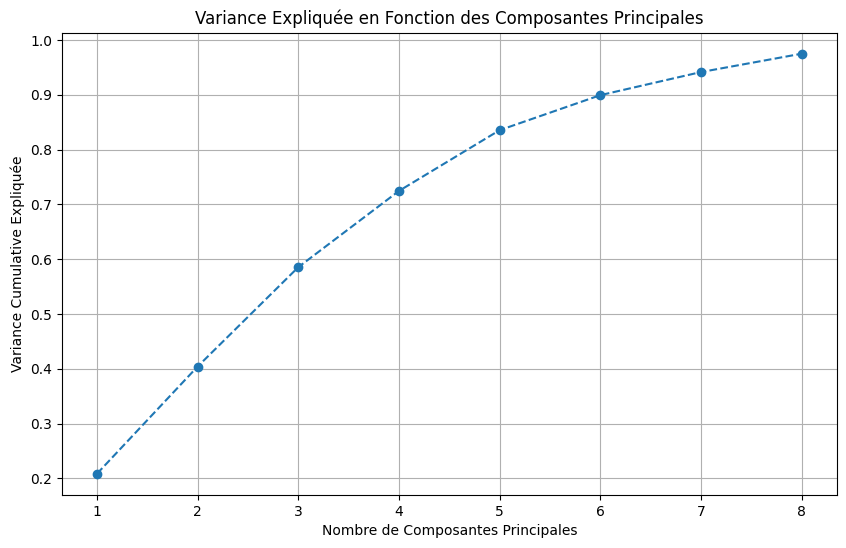

In [ ]:
explained_variance = preprocessor_with_pca.named_steps['pca'].explained_variance_ratio_

# Visualiser la variance expliquée par chaque composante principale
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.xlabel('Nombre de Composantes Principales')
plt.ylabel('Variance Cumulative Expliquée')
plt.title('Variance Expliquée en Fonction des Composantes Principales')
plt.grid(True)
plt.show()


### Modelisation

In [ ]:
X = data_transformed_full_pca
y = data['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Créer un modèle de régression logistique
reg_log_pca_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42, class_weight='balanced', max_iter=100)

# Entraîner le modèle avec les nouvelles composantes principales
reg_log_pca_model.fit(X_train, y_train)

# Prédire sur l'ensemble de validation
y_val_pred_prob = reg_log_pca_model.predict_proba(X_val)[:, 1]

# Calculer le score AUC
auc_score_pca = roc_auc_score(y_val, y_val_pred_prob)
print(f"AUC Score pour la régression logistique avec PCA: {auc_score_pca:.4f}")

AUC Score pour la régression logistique avec PCA: 0.7221


In [ ]:
models = {
    'Logistic Regression': reg_log_pca_model,
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
}

# Tester chaque modèle de la liste
for model_name, model in models.items():
    print(f"\n--- Entraînement et Évaluation du modèle: {model_name} ---")
    # Entraîner le modèle
    model.fit(X_train, y_train)
    
    # Prédire sur l'ensemble de validation
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    
    # Calculer le score AUC
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    print(f"AUC Score pour le modèle {model_name}: {auc_score:.4f}")


--- Entraînement et Évaluation du modèle: Logistic Regression ---
AUC Score pour le modèle Logistic Regression: 0.7221

--- Entraînement et Évaluation du modèle: Random Forest ---
AUC Score pour le modèle Random Forest: 0.8451

--- Entraînement et Évaluation du modèle: SVM ---
AUC Score pour le modèle SVM: 0.7661
